# Final Project: Vehicle Rounting Problem

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
import copy
import random
import timeit

## 1. Import, Data Investigation and Preprocessing

In [2]:
# VRP1
# import distance matrix
filepath = 'VRP1/distance.txt'
with open(filepath, 'r') as t:
    distance_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        distance_matrix.append(y)
        
    t.close()
    distance_matrix = np.array(distance_matrix)

# import demand matrix
filepath = 'VRP1/demand.txt'
with open(filepath, 'r') as t:
    demand_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        demand_matrix.append(y)
        
    t.close()
    demand_matrix = np.array(demand_matrix)
    demand_matrix = demand_matrix[0]
    # since demand matrix has length 100 but the distance_matrix has length 101, we add one demand with 0 to represent the depot 
    demand_matrix = np.insert(demand_matrix,0,0)

# import capacity matrix
filepath = 'VRP1/capacity.txt'
with open(filepath, 'r') as t:
    capacity_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        capacity_matrix.append(y)
        
    t.close()
    capacity_matrix = np.array(capacity_matrix)
    capacity_matrix = capacity_matrix[0]

# import transportation_cost matrix
filepath = 'VRP1/transportation_cost.txt'
with open(filepath, 'r') as t:
    transportation_cost = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        transportation_cost.append(y)
        
    t.close()
    transportation_cost = np.array(transportation_cost)
    transportation_cost = transportation_cost[0]

# VRP2

# import distance matrix
filepath = 'VRP2/distance.txt'
with open(filepath, 'r') as t:
    distance_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        distance_matrix_2.append(y)
        
    t.close()
    distance_matrix_2 = np.array(distance_matrix_2)

# import demand matrix
filepath = 'VRP2/demand.txt'
with open(filepath, 'r') as t:
    demand_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        demand_matrix_2.append(y)
        
    t.close()
    demand_matrix_2 = np.array(demand_matrix_2)
    demand_matrix_2 = demand_matrix_2[0]
    # since demand matrix has length 100 but the distance_matrix has length 101, we add one demand with 0 to represent the depot 
    demand_matrix_2 = np.insert(demand_matrix_2,0,0)

    
# import capacity matrix
filepath = 'VRP2/capacity.txt'
with open(filepath, 'r') as t:
    capacity_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        capacity_matrix_2.append(y)
        
    t.close()
    capacity_matrix_2 = np.array(capacity_matrix_2)
    capacity_matrix_2 = capacity_matrix_2[0]
    

    
# import transportation_cost matrix
filepath = 'VRP2/transportation_cost.txt'
with open(filepath, 'r') as t:
    transportation_cost_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        transportation_cost_2.append(y)
        
    t.close()
    transportation_cost_2 = np.array(transportation_cost_2)
    transportation_cost_2 = transportation_cost_2[0]

In [3]:
# information about the distance matrix for VRP1
print("Information about distance matric for VRP1 \n# columns: ", len(distance_matrix[0]))
print("# lines: ", len(distance_matrix))
asymmetric = (distance_matrix != np.transpose(distance_matrix))
print(np.unique(asymmetric))
print("Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric. \n")

# information about the distance matrix for VRP2
print("Information about distance matric for VRP2 \n# columns: ", len(distance_matrix_2[0]))
print("# lines: ", len(distance_matrix_2))
asymmetric_2 = (distance_matrix_2 != np.transpose(distance_matrix_2))
                
print(np.unique(asymmetric_2))
print("Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric.")

Information about distance matric for VRP1 
# columns:  101
# lines:  101
[False  True]
Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric. 

Information about distance matric for VRP2 
# columns:  101
# lines:  101
[False  True]
Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric.


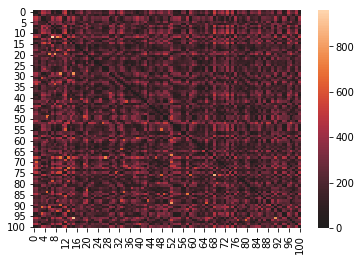

In [4]:
#heatmap
ax = sns.heatmap(distance_matrix, center=0)

The heatmap again illustrates the fact that we have to deal with an asymmetric distance matrix. This property is realistic if we think about. for example, one-way roads. Going from A to B does not strictly have to have the same distance than going from B to A. 

We further notice that we deal with a matrix that does note fulfill the triangle inequality, i.e. the distance from going from A to B has to be always smaller or equal than going from A to B over a third point C. This is not the case in the given distance matrices. This has the consequence that we cannot apply the k-means algorithm since a representation in a cartesian coordinate system is not uniquely possible. 

Our assumption is that the matrix consists of Manhatten distances.

## 2. Heuristic

The initial situation of the Vehicle Routing Problem (VRP) is that we are given a distance matrix, a capacity matrix, a demand matrix and a transportation cost matrix. The aim is to design a route with minimal costs. In order to set up an initial solution, which we then later want to optimize, we deal with the following heuristic: 

1. Take the capacity matrix and randomly pick a car from this list. Remove the entry from the capacity matrix.
2. Start with the customer that is farthest away from the depot and add it to our car. 
3. Keep adding customers to the car, as long as the car still has the capacity to fulfill the customer's demand. Always take the customer that is closest.
4. Stop filling the car when one customer does not fit into the car anymore. Start with 1 again until every customer's demand is fulfilled or we do not have any cars left.  

### 2.1 Helper functions

In [5]:
# find the customer which is closest to another given customer
def find_closest_customer(last_customer_visited, customer_indices,distance_matrix):
    distance_list = []
    for i in customer_indices:
        if i == last_customer_visited:
            # set the distance to customer's own position very high in order for it not the be chosen as the closest customer
            distance_list.append(max(distance_matrix[last_customer_visited]))
        else: 
            distance_list.append(distance_matrix[i][last_customer_visited])
    

    index = distance_list.index(min(distance_list))
    customer_index = customer_indices[index]
    return customer_index      

In [6]:
def total_demand_satisfied(route,demand_matrix):
    total_demand_satisfied = 0
    for i in route:
        total_demand_satisfied += demand_matrix[i]
    return total_demand_satisfied

In [7]:
# randomly pick a car from capacity matrix and return its capacity

def pick_random_car(capacity_matrix):
    car_type = random.randrange(len(capacity_matrix))
    cluster_size = capacity_matrix[car_type]
    return cluster_size

In [8]:
def get_cost_list(cars_used):
    unique_capacity = sorted(set(capacity_matrix)) #VRP1: 100, 300, 500, 1000
    unique_cost = sorted(set(transportation_cost)) #VRP1: 11, 13, 15, 18

    cars_costs = dict(zip(unique_capacity, unique_cost))
    cost_list = [cars_costs.get(value) for value in cars_used]
    return cost_list

### 2.2 Cluster initialization

In [9]:
def cluster_initialization_with_random_cars(demand_matrix,distance_matrix,capacity_matrix):
    clusters = []
    cars_used = []

    customers = copy.deepcopy(demand_matrix)
    capacity = list(copy.deepcopy(capacity_matrix))
    customer_indices = list(range(len(demand_matrix))[1:])

    # keep on creating clusters as long as customers are not satisfied    
    while any(item != 0 for item in customers):
        
        # determine cluster size by randomly pick a car
        cluster_size = pick_random_car(capacity)
        
        # append capacity_size to the list of cars being used
        cars_used.append(cluster_size)
        
        # remove capacity that has been used from the capacity_matrix
        capacity.remove(cluster_size)
        
        if cluster_size not in [100,300,500,1000]:
            car_capacity = capacity_matrix[random.randrange(len(capacity_matrix))]
        else:
            car_capacity = cluster_size

        visited_customers = []

        # keep adding customers as long as capacities are not full
        while car_capacity > 0 and any(item != 0 for item in customers):
            
            # for the starting customer of each car, choose the customer that is farthest away from the depot
            if visited_customers == []:
                max_distance = -1
                max_distance_index = -1
                
                for index in customer_indices:
                    new_distance = distance_matrix[0][index]
                    if new_distance > max_distance:
                        max_distance = new_distance
                        max_distance_index = index
                    
                next_customer = max_distance_index
            # else append everytime the nearest customer
            else:
                last_customer = visited_customers[-1]
                next_customer = find_closest_customer(last_customer,customer_indices,distance_matrix)

            # after choosing next customer only merge if demand is completely covered
            if customers[next_customer] <= car_capacity:
                visited_customers.append(next_customer)
                
                # reduce the capacity by the customer demand
                car_capacity -= customers[next_customer]

                # demand of the customer is fully satsified
                customers[next_customer] = 0
                
                # delete visited customers
                del customer_indices[customer_indices.index(next_customer)]
            else:
                car_capacity = 0

        # create and add this car object to our current solution        
        clusters.append([0]+visited_customers+[0])

    return clusters, cars_used

## 3. Genetic Algorithm

The nature inspired algorithm we use is the genetic algorithm. We want to apply it to our initialized clusters in order to optimize the route of the single cars. To be able to apply the genetic algorithm, we have to create a population (of possible routes a truck could take). Therefore we randomly create permutations of the initialzed clusters. How many permutations of one cluster shall be created, can be set by the parameter population_size.   

In [10]:
# get route and shuffle

def shuffle_cluster(cluster): 
    sliced_cluster = []
    sliced_cluster = cluster[1:len(cluster)-1]
    random.shuffle(sliced_cluster)
    sliced_cluster.append(0)
    sliced_cluster.insert(0,0)    
    return list(sliced_cluster)  

In [11]:
# create as many permutations as given with population_size. It returns a list in which every route is randomly
# shuffled n-times with n being the population size. 

def create_permutations(initialized_clusters, population_size):
    population_list = []
    sliced_shuffled = []
    
    for i in range(len(initialized_clusters)):
        for j in range(population_size):
            sliced_shuffled = shuffle_cluster(initialized_clusters[i])
            if sliced_shuffled not in population_list:
                population_list.append(sliced_shuffled)
            else: 
                unique = False
                while unique == False:
                    sliced_shuffled = shuffle_cluster(initialized_clusters[i])
                    if sliced_shuffled not in population_list:
                        population_list.append(sliced_shuffled)
                        unique = True
                    else: 
                        unique == False

    return population_list

### 3.1 Evaluate Fitness

Here the fitness of one cluster corresponds to the costs. Since we want to minimize our costs, a low evaluation value represents a high fitness. 

In [12]:
# helper function to get the total distance of one single cluster

def total_distance_cluster(cluster):
    total_distance = 0
    
    for i in range(len(cluster)-1):
        total_cluster_distance = total_distance + distance_matrix[cluster[i]][cluster[i+1]]
        total_distance = total_cluster_distance
    return total_distance

In [13]:
# evaluate one single cluster

def evaluate_cluster(transportation_cost,distance_matrix,cluster):
    total_distance = 0
    
    for i in range(len(cluster)-1):
        total_cluster_distance = total_distance + distance_matrix[cluster[i]][cluster[i+1]]
        total_distance = total_cluster_distance
    return transportation_cost * total_distance

In [14]:
# evaluate a list of clusters, i.e. one whole solution

def final_evaluation(list_of_clusters,cost_list):
    total_cost = 0 
    for i in range(len(list_of_clusters)):
        current_cluster = list_of_clusters[i]
        total_cost = total_cost + cost_list[i]*total_distance_cluster(current_cluster)
    return total_cost

### 3.2 Selection

The selection method we use is called tournament selection. It also takes the population (here: population_list), its fitness array and the mating pool size (how many chromosomes do we want to keep) as input. It basically takes the chromosomes that have the lowest cost values. Note that highest fitness level corresponds to lowest cost values in this example since our aim is to minimize the overall costs.

In [15]:
def tournament_selection(population_list, mating_pool_size,population_size,cost_list):
    mating_pool_big = []
    counter = 0
    for i in range(len(population_list)):
        if i % population_size == 0: 
            current_population = population_list[i:i+population_size]
            mating_pool = []
            cost = cost_list[counter]
            counter +=1 
            j = 0
            
            for j in range(mating_pool_size):
                participant1 = current_population[random.randint(0, population_size-1)]
                participant2 = current_population[random.randint(0, population_size-1)]
                
                if (participant1 != participant2):
                    j +=1
                    if evaluate_cluster(cost, distance_matrix, participant1) <= evaluate_cluster(cost, distance_matrix, participant2) :
                        mating_pool = mating_pool + [participant1]
                    else: 
                        mating_pool = mating_pool + [participant2]  
                else: 
                    mating_pool = mating_pool + [participant1] 
                    

            mating_pool_big = mating_pool_big + mating_pool 
    return mating_pool_big

### 3.3 Recombination

 

In recombination, two chromosomes are taken, called parent1 and parent2, and they are recombined (have children, here: child1 and child2) that might produce better outputs, i.e. lower cost.

In uniform_order_based_crossover, we use a template to create valid childs that still visit every customer on the route

In [16]:
def uniform_order_based_crossover(parent1,parent2):
    parent1 = parent1[1:-1]
    parent2 = parent2[1:-1]
    
    table = np.zeros(len(parent1))
    for i in range(len(parent1)):
        table[i]= random.randint(0,1)
    
    child1 = np.zeros(len(parent1))
    child2 = np.zeros(len(parent1))
    for i in range(len(table)):
        if table[i]==1:
            child1[i]=parent1[i]
            child2[i]=parent2[i]
        
    for i in range(len(table)):
        if child1[i]==0:
            for j in range(len(parent2)):
                if parent2[j] not in child1:
                    child1[i] = parent2[j]
                    break
        
        if child2[i]==0:
            for j in range(len(parent1)):
                if parent1[j] not in child2:
                    child2[i] = parent1[j]
                    break
                    
                
    child1 = np.insert(child1,0,0)
    child1 = np.insert(child1, len(child1),0)
    child2 = np.insert(child2,0,0)
    child2 = np.insert(child2, len(child2),0)
                    
    return child1, child2  

In [17]:
def recombine_uniform_order_based_crossover(population_size,mating_pool,crossover_probability, mating_pool_size):
    
    children_clusters_big = []
    
    for i in range(len(mating_pool)):
        if i % mating_pool_size == 0: 
            current_mating_pool = mating_pool[i:i+mating_pool_size]
            children_clusters = [] 

            j = 0
            while j < population_size:
                
                cluster1 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                cluster2 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                
                if cluster2 == cluster1:
                    cluster2 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                    
                if random.random() < crossover_probability:
                    child1, child2 = uniform_order_based_crossover(cluster1,cluster2)
                    child1 = child1.astype(int)
                    child2 = child2.astype(int)
                    child1 = list(child1)
                    child2 = list(child2)
                    children_clusters.append(child1)
                    children_clusters.append(child2)
                    
                    
                    
                else:
                    children_clusters.append(cluster1)
                    children_clusters.append(cluster2)
                
                j+=2
                
            children_clusters_big = children_clusters_big + children_clusters

    return children_clusters_big

### 3.4 Swap Mutation

Mutation (in contrast to recombination) operates locally and tries to improve the fitness level with local optimization techniques. Here we implement the swap mutation, i.e. that given a particular probability, we swap at two randomly chosen locations within the cluster. Mutation makes sense in this example since we deal with an asymmetric matrix. This means that sometimes it is shorter to go from A to B instead from B to A. It is basically a form of permutation, which we have already done in the beginning for a fixed population_size. Nevertheless, we will still consider swap mutation since we will not be able to permutate over all customer nodes of one cluster due to run time. With the help of swap mutation we still might be lucky to consider a better solution.

In [18]:
def swap(cluster,mutation_probability):
    mutated_cluster = np.copy(cluster)
    if random.random() < mutation_probability:
        
        # note that we consider all entries without the first one and the last one since this represents the depot
        location1 = np.random.randint(1,len(cluster)-1)
        location2 = np.random.randint(1,len(cluster)-1)
        
        while location1 == location2:
            location2 = np.random.randint(1,len(cluster)-1)
        help_variable = mutated_cluster[location1]
        mutated_cluster[location1] = mutated_cluster[location2]
        mutated_cluster[location2] = help_variable
        
    return mutated_cluster

In [19]:
def mutate_swap(cluster,mutation_probability):
    all_mutated_clusters = []
    for i in range(len(cluster)):
        mutated_cluster = swap(cluster[i],mutation_probability)
        mutated_cluster = list(mutated_cluster)
        all_mutated_clusters.append(mutated_cluster)
    return all_mutated_clusters

In [20]:
# After last episode, choose best sequence for each cluster. 

def choose_best(all_populations, cost_list,population_size):
    final_clusters = []
    counter = 0
    
    for i in range(len(all_populations)):
        if i % population_size == 0: 
            current_population = all_populations[i:i+population_size]
            cost = cost_list[counter]
            counter += 1
            
            current_best = current_population[0]
            for j in range(population_size):
                if evaluate_cluster(cost, distance_matrix, current_population[j]) < evaluate_cluster(cost, distance_matrix, current_best):
                    current_best = current_population[j]
            final_clusters.append(current_best)
    
    return final_clusters

## 4. Run

In [21]:
# uncomment to choose VRP 2

demand_matrix = demand_matrix_2
distance_matrix = distance_matrix_2
capacity_matrix = capacity_matrix_2
transportation_cost = transportation_cost_2

In [22]:
# parameter settings for genetic algorithm
population_size = 20
mating_pool_size = 8
crossover_probability = 0.7
mutation_probability = 0.1

# start intializing with out heuristic
starting_best, best_cars = cluster_initialization_with_random_cars(demand_matrix,distance_matrix,capacity_matrix)
best_cost_list = get_cost_list(best_cars)

# create x possible solutions with our heuristic and evaluate which one has the best (lowest) initial costs
for i in range(10000):

    #start of genetic algorithm
    initialized_clusters, cars_used = cluster_initialization_with_random_cars(demand_matrix,distance_matrix,capacity_matrix)
    cost_list = get_cost_list(cars_used)

    print("Initialized Clusters:")
    print(initialized_clusters, '\n')
    print("Demand satisfied with clusters: ")
    for cluster in initialized_clusters:
        print(total_demand_satisfied(cluster,demand_matrix))
    print('cars used', cars_used)
    print('cost list', cost_list)
    print("cost_before_genetic", final_evaluation(initialized_clusters, cost_list))
    print("starting best", final_evaluation(starting_best, best_cost_list))

    if (final_evaluation(initialized_clusters, cost_list)) < (final_evaluation(starting_best, best_cost_list)): 
        starting_best = initialized_clusters
        best_cost_list = cost_list
        best_cars = cars_used
        

# take the best initial clusters and optimize it with the genetic algorithm
all_populations = create_permutations(starting_best, population_size)
cost_list = best_cost_list
best = all_populations

# store all solutions in one list for plotting
solution_list = []

for i in range(1000):

    mating_pool = tournament_selection(all_populations,mating_pool_size,population_size, cost_list)
    new_generation = recombine_uniform_order_based_crossover(population_size,mating_pool,crossover_probability, mating_pool_size)
    mutation = mutate_swap(new_generation, mutation_probability)
    all_populations = mutation
    solution_list.append(final_evaluation(choose_best(all_populations, cost_list,population_size), cost_list))
    print("i", i, final_evaluation(choose_best(all_populations, cost_list,population_size), cost_list))
    if (final_evaluation(choose_best(all_populations, cost_list,population_size), cost_list)) < final_evaluation(choose_best(best, cost_list,population_size), cost_list):
        best = all_populations
            

last_solution = choose_best(all_populations, cost_list,population_size)
final_solution = choose_best(best, cost_list,population_size)

print("last cost:", final_evaluation(last_solution, cost_list),"\n")
print("best cost:", final_evaluation(final_solution, cost_list))
print("car types used: ", best_cars)
print("Final route: ",choose_best(best, cost_list,population_size))

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 62, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 80, 81, 99, 55, 94, 45, 20, 40, 37, 75, 0]] 

Demand satisfied with clusters: 
76
296
296
90
94
494
580
cars used [100, 300, 300, 100, 100, 500, 1000]
cost list [8, 12, 12, 8, 8, 16, 19]
cost_before_genetic 128666
starting best 131960
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 62, 2, 77, 15, 45, 0], [0, 75, 71, 93, 68, 63, 0], [0, 94, 55, 99, 81, 0], [0, 20, 80, 40, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
480
296
472
87
98
83
cars used [100, 100, 100, 100, 100, 500, 300, 500, 100, 100, 100]
cost list [8, 8, 8, 8, 8, 16, 12, 16, 8, 8, 8]
cost_before_genetic 121248
starting best 110520
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 49, 6

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 71, 93, 40, 37, 92, 50, 83, 98, 4, 20, 0]] 

Demand satisfied with clusters: 
76
75
988
489
97
201
cars used [100, 100, 1000, 500, 100, 300]
cost list [8, 8, 19, 16, 8, 12]
cost_before_genetic 127543
starting best 109320
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 47, 32, 35, 51, 60, 0], [0, 76, 8, 

285
94
100
65
cars used [100, 100, 100, 300, 100, 300, 500, 300, 100, 100, 100]
cost list [8, 8, 8, 12, 8, 12, 16, 12, 8, 8, 8]
cost_before_genetic 112780
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 23, 80, 81, 99, 0], [0, 94, 55, 45, 20, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0]] 

Demand satisfied with clusters: 
291
75
90
290
72
97
489
522
cars used [300, 100, 100, 300, 100, 100, 500, 1000]
cost list [12, 8, 8, 12, 8, 8, 16, 19]
cost_before_genetic 121542
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 5

477
94
72
97
97
91
474
298
cars used [100, 100, 100, 500, 100, 100, 100, 100, 100, 500, 300]
cost list [8, 8, 8, 16, 8, 8, 8, 8, 8, 16, 12]
cost_before_genetic 122968
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 32, 47, 35, 68, 25, 0], [0, 20, 63, 37, 79, 90, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
97
498
81
287
94
290
97
cars used [100, 100, 100, 100, 100, 100, 100, 500, 100, 300, 100, 300, 500]
cost list [8, 8, 8, 8, 8, 8, 8, 16, 8, 12, 8, 12, 16]
cost_before_genetic 129868
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54,

75
90
94
72
296
487
91
85
278
95
81
31
cars used [100, 100, 100, 100, 100, 100, 300, 500, 100, 100, 300, 100, 100, 300]
cost list [8, 8, 8, 8, 8, 8, 12, 16, 8, 8, 12, 8, 8, 12]
cost_before_genetic 120960
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 23, 17, 0], [0, 20, 2, 62, 77, 15, 13, 97, 28, 68, 93, 71, 37, 58, 10, 24, 0], [0, 90, 79, 25, 0]] 

Demand satisfied with clusters: 
291
296
90
290
72
291
94
85
87
296
34
cars used [300, 300, 100, 300, 100, 300, 100, 100, 100, 300, 100]
cost list [12, 12, 8, 12, 8, 12, 8, 8, 8, 12, 8]
cost_before_genetic 114024
starting best 107288
Initialized Clusters:
[[0, 41, 65, 5

488
298
94
755
cars used [300, 500, 300, 100, 1000]
cost list [12, 16, 12, 8, 19]
cost_before_genetic 133518
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 40, 37, 58, 10, 24, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 88, 62, 0], [0, 20, 63, 2, 77, 15, 68, 93, 71, 33, 84, 5, 72, 79, 90, 0]] 

Demand satisfied with clusters: 
76
75
75
477
94
72
496
288
273
cars used [100, 100, 100, 500, 100, 100, 500, 300, 300]
cost list [8, 8, 8, 16, 8, 8, 16, 12, 12]
cost_before_genetic 118312
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 68, 93, 71, 40, 19, 17, 28, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
279
97
97
96
752
cars used [100, 100, 100, 300, 100, 300, 100, 100, 100, 1000]
cost list [8, 8, 8, 12, 8, 12, 8, 8, 8, 19]
cost_before_genetic 123767
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 40, 37, 58, 10, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 90, 79, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 68, 93, 71, 0], [0, 24, 0]] 

Demand satisfied with clusters: 
291
995
287
72
81
94
80
26
cars used [300, 1000, 300, 100, 100, 100, 100, 100]
cost list [12, 19, 12, 8, 8, 8, 8, 8]
cost_before_genetic 122242
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 9

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 15, 77, 2, 62, 88, 82, 25, 63, 20, 68, 93, 71, 40, 43, 9, 39, 37, 0]] 

Demand satisfied with clusters: 
76
296
75
90
500
72
97
297
85
338
cars used [100, 300, 100, 100, 500, 100, 100, 300, 100, 500]
cost list [8, 12, 8, 8, 16, 8, 8, 12, 8, 16]
cost_before_genetic 121032
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 4

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 0], [0, 50, 92, 52, 39, 9, 43, 40, 37, 64, 36, 0]] 

Demand satisfied with clusters: 
1000
75
72
97
91
94
297
200
cars used [1000, 100, 100, 100, 100, 100, 300, 300]
cost list [19, 8, 8, 8, 8, 8, 12, 12]
cost_before_genetic 120432
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 79, 90, 58, 4, 3, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 32, 47, 0], [0, 75, 71, 93, 68, 35, 51, 0], [0, 94, 55, 99, 45, 20, 81, 80, 23, 60, 0]] 

Demand satisfied with clusters: 
291
488
90
94
72
97
497
98
199
cars used [300, 500, 100, 100, 100, 100, 500, 100, 500]
cost list [12, 16, 8, 8, 8, 8, 16, 8, 16]
cost_before_genetic 123600
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 

cost list [8, 12, 16, 8, 8, 12, 19]
cost_before_genetic 132900
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 17, 28, 19, 97, 15, 77, 13, 68, 93, 71, 40, 37, 75, 20, 0]] 

Demand satisfied with clusters: 
291
75
285
94
496
296
389
cars used [300, 100, 300, 100, 500, 300, 500]
cost list [12, 8, 12, 8, 16, 12, 16]
cost_before_genetic 122944
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 79, 90, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 37, 40, 32, 47, 35, 75, 0]] 

Demand satisfied with clusters: 
496
296
484
94
98
97
361
cars used [500, 300, 500, 100, 100, 100, 500]
cost list [16, 12, 16, 8, 8, 8, 16]
cost_before_genetic 130960
starting best 107288
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 68, 93, 71, 40, 19, 17, 28, 60, 97, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 0], [0, 20, 37, 4, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
279
97
97
96
477
65
cars used [100, 100, 500, 100, 100, 300, 100, 100, 100, 500, 100]
cost list [8, 8, 16, 8, 8, 12, 8, 8, 8, 16, 8]
cost_before_genetic 124024
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 0], [0, 87, 49, 66, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 20, 25, 40, 37, 58, 0], [0, 90, 79, 0]] 

Demand satisfied with clusters: 
291
75
490
494
72
91
298
89
26
cars used [300, 100, 500, 500, 100, 100, 300, 100, 500]
cost list [12, 8, 16, 16, 8, 8, 12, 8, 16]
cost_before_genetic 121016
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 5

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 25, 68, 93, 71, 40, 19, 17, 28, 35, 32, 47, 97, 37, 0], [0, 90, 79, 24, 10, 0]] 

Demand satisfied with clusters: 
76
296
75
285
94
72
97
284
94
480
73
cars used [100, 300, 100, 300, 100, 100, 100, 300, 100, 500, 500]
cost list [8, 12, 8, 12, 8, 8, 8, 12, 8, 16, 16]
cost_before_genetic 124816
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 0], [0, 87, 49, 66, 86, 0], [0, 61, 11, 34, 92, 0], [0, 52, 39, 9, 43, 40, 0], [0, 37, 0]] 

Demand satisfied with clusters: 
496
75
94
988
94
75
95
9
cars used [500, 100, 100, 1000, 100, 100, 100, 300]
cost list [16, 8, 8, 19, 8, 8, 8, 12]
cost_before_genetic 129636
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 4

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 37, 0], [0, 90, 79, 24, 10, 58, 0], [0, 18, 23, 17, 28, 97, 0]] 

Demand satisfied with clusters: 
496
296
94
290
72
291
94
97
82
114
cars used [500, 300, 100, 300, 100, 300, 100, 100, 100, 300]
cost list [16, 12, 8, 12, 8, 12, 8, 8, 8, 12]
cost_before_genetic 112656
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 42, 47, 32, 35, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 62, 2, 77, 15, 45, 0], [0, 94, 55, 99, 81, 0], [0, 20, 63, 25, 80, 0], [0, 83, 50, 92, 98, 4, 0], [0, 40, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
299
97
97
499
98
81
93
31
cars used [100, 300, 100, 100, 100, 300, 100, 100, 500, 100, 100, 100, 300]
cost list [8, 12, 8, 8, 8, 12, 8, 8, 16, 8, 8, 8, 12]
cost_before_genetic 119544
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 2, 62, 77, 15, 13, 97, 19, 17, 28, 35, 32, 47, 42, 43, 9, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 58, 4, 98, 83, 50, 92, 52, 39, 37, 40, 93, 71, 68, 25, 64, 36, 0]] 

Demand satisfied with clusters: 
291
75
285
94
72
97
97
91
94
285
445
cars used [300, 100, 300, 100, 100, 100, 100, 100, 100, 300, 500]
cost list [12, 8, 12, 8, 8, 8, 8, 8, 8, 12, 16]
cost_before_genetic 115240
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 79, 90, 84, 37, 40, 20, 0]] 

Demand satisfied with clusters: 
291
75
90
492
72
97
300
85
424
cars used [300, 100, 100, 500, 100, 100, 300, 100, 500]
cost list [12, 8, 8, 16, 8, 8, 12, 8, 16]
cost_before_genetic 123352
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 99, 8, 76, 89, 38, 30, 42, 29,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 82, 25, 88, 62, 2, 77, 15, 63, 0], [0, 91, 16, 100, 56, 0], [0, 20, 40, 37, 52, 0], [0, 83, 50, 92, 98, 4, 0]] 

Demand satisfied with clusters: 
76
75
75
477
276
279
97
284
94
100
93
cars used [100, 100, 100, 500, 300, 300, 100, 300, 100, 100, 500]
cost list [8, 8, 8, 16, 12, 12, 8, 12, 8, 8, 16]
cost_before_genetic 119880
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 


Demand satisfied with clusters: 
291
75
90
290
72
97
971
40
cars used [300, 100, 100, 300, 100, 100, 1000, 100]
cost list [12, 8, 8, 12, 8, 8, 19, 8]
cost_before_genetic 115332
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 80, 0], [0, 75, 37, 40, 45, 0], [0, 94, 55, 99, 81, 0], [0, 20, 0]] 

Demand satisfied with clusters: 
291
488
90
94
287
479
67
98
32
cars used [300, 500, 100, 100, 300, 500, 100, 100, 500]
cost list [12, 16, 8, 8, 12, 16, 8, 8, 16]
cost_before_genetic 121408
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 37, 40, 93, 71, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 20, 33, 84, 5, 72, 10, 24, 79, 90, 58, 0]] 

Demand satisfied with clusters: 
291
75
490
276
72
285
437
cars used [300, 100, 500, 300, 100, 300, 500]
cost list [12, 8, 16, 12, 8, 12, 16]
cost_before_genetic 115832
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 1, 74, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 20, 62, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 40, 19, 28, 97, 80, 81, 56, 100, 16, 91, 36, 64, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
495
91
637
cars used [100, 100, 300, 100, 100, 100, 500, 100, 1000]
cost list [8, 8, 12, 8, 8, 8, 16, 8, 19]
cost_before_genetic 132970
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 68, 25, 56, 100, 16, 91, 97, 19, 17, 28, 0], [0, 20, 18, 23, 60, 51, 35, 32, 47, 40, 37, 79, 90, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
97
498
296
204
cars used [500, 100, 100, 100, 100, 100, 500, 300, 500]
cost list [16, 8, 8, 8, 8, 8, 16, 12, 16]
cost_before_genetic 128408
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 40, 19, 28, 97, 18, 64, 36, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
495
91
94
415
cars used [500, 100, 100, 100, 100, 500, 100, 100, 500]
cost list [16, 8, 8, 8, 8, 16, 8, 8, 16]
cost_before_genetic 129232
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 9

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 40, 80, 81, 99, 55, 94, 45, 20, 25, 75, 0]] 

Demand satisfied with clusters: 
291
296
90
94
72
296
787
cars used [300, 300, 100, 100, 100, 300, 1000]
cost list [12, 12, 8, 8, 8, 12, 19]
cost_before_genetic 127215
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 45, 55, 94, 99, 81, 80, 43, 9, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 40, 37, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 79, 90, 0], [0, 75, 20, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
72
998
41
cars used [100, 100, 500, 100, 100, 100, 1000, 100]
cost list [8, 8, 16, 8, 8, 8, 19, 8]
cost_before_genetic 134422
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 52, 92, 50, 83, 98, 

starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 25, 56, 100, 16, 91, 20, 0], [0, 83, 50, 92, 98, 4, 0], [0, 37, 40, 0]] 

Demand satisfied with clusters: 
76
75
988
279
97
278
93
40
cars used [100, 100, 1000, 300, 100, 300, 100, 1000]
cost list [8, 8, 19, 12, 8, 12, 8, 19]
cost_before_genetic 125077
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 2

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 40, 37, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 79, 90, 0], [0, 75, 20, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
72
998
41
cars used [100, 100, 500, 100, 100, 100, 1000, 100]
cost list [8, 8, 16, 8, 8, 8, 19, 8]
cost_before_genetic 134422
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 

cost list [8, 8, 8, 8, 12, 8, 16, 8, 8, 8, 8, 8, 19]
cost_before_genetic 132826
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 75, 84, 33, 5, 72, 10, 0], [0, 90, 79, 24, 58, 37, 0], [0, 40, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
994
70
31
cars used [500, 100, 100, 100, 100, 1000, 100, 100]
cost list [16, 8, 8, 8, 8, 19, 8, 8]
cost_before_genetic 127132
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 37, 40, 0]] 

Demand satisfied with clusters: 
496
75
296
276
72
97
614
cars used [500, 100, 300, 300, 100, 100, 1000]
cost list [16, 8, 12, 12, 8, 8, 19]
cost_before_genetic 120386
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 8

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 20, 68, 93, 71, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 79, 90, 37, 42, 47, 32, 35, 0], [0, 81, 80, 51, 60, 23, 0]] 

Demand satisfied with clusters: 
291
488
90
94
72
97
97
94
493
110
cars used [300, 500, 100, 100, 100, 100, 100, 100, 500, 1000]
cost list [12, 16, 8, 8, 8, 8, 8, 8, 16, 19]
cost_before_genetic 126894
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90

cars used [100, 300, 100, 100, 1000, 300, 100, 100]
cost list [8, 12, 8, 8, 19, 12, 8, 8]
cost_before_genetic 123985
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 20, 25, 68, 93, 71, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 58, 4, 98, 83, 50, 92, 52, 0], [0, 36, 64, 40, 43, 9, 39, 37, 42, 47, 32, 35, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
97
97
91
85
94
294
88
288
170
cars used [300, 100, 100, 100, 100, 100, 100, 100, 100, 100, 300, 100, 300, 500]
cost list [12, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 8, 12, 16]
cost_before_genetic 117428
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0

cost list [8, 19, 8, 8, 8, 8, 8, 8, 16]
cost_before_genetic 131785
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 87, 49, 66, 79, 90, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 58, 75, 20, 0]] 

Demand satisfied with clusters: 
1000
484
98
344
cars used [1000, 500, 100, 500]
cost list [19, 16, 8, 16]
cost_before_genetic 131440
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24,

91
85
94
294
295
54
cars used [300, 100, 100, 100, 100, 300, 100, 100, 100, 100, 300, 300, 100]
cost list [12, 8, 8, 8, 8, 12, 8, 8, 8, 8, 12, 12, 8]
cost_before_genetic 108252
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 93, 71, 68, 33, 84, 5, 58, 37, 42, 47, 32, 35, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
997
94
72
97
440
cars used [100, 100, 100, 1000, 100, 100, 100, 500]
cost list [8, 8, 8, 19, 8, 8, 8, 16]
cost_before_genetic 133733
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 62, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 40, 37, 33, 84, 5, 72, 10, 24, 79, 90, 20, 81, 80, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
97
284
91
85
666
cars used [100, 100, 300, 100, 100, 100, 100, 300, 100, 100, 1000]
cost list [8, 8, 12, 8, 8, 8, 8, 12, 8, 8, 19]
cost_before_genetic 136788
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 2

starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0], [0, 75, 71, 93, 68, 21, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 63, 88, 62, 0], [0, 23, 17, 28, 19, 97, 44, 57, 13, 53, 2, 77, 15, 40, 32, 47, 35, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
480
97
284
82
85
92
100
296
cars used [100, 100, 100, 100, 100, 500, 100, 300, 100, 100, 100, 100, 500]
cost list [8, 8, 8, 8, 8, 16, 8, 12, 8, 8, 8, 8, 16]
cost_before_genetic 120136
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 4

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 20, 40, 43, 9, 39, 0], [0, 90, 79, 72, 10, 24, 5, 58, 4, 98, 83, 50, 92, 52, 37, 84, 0]] 

Demand satisfied with clusters: 
1000
75
72
97
300
99
283
cars used [1000, 100, 100, 100, 300, 100, 300]
cost list [19, 8, 8, 8, 12, 8, 12]
cost_before_genetic 118960
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 0], [0, 90, 79, 24, 10, 58, 4, 98, 83, 50, 92, 37, 40, 0]] 

Demand satisfied with clusters: 
76
296
988
72
97
94
88
215
cars used [100, 300, 1000, 100, 100, 100, 100, 300]
cost list [8, 12, 19, 8, 8, 8, 8, 12]
cost_before_genetic 117487
starting best 106756
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 62, 2, 77,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 0], [0, 75, 36, 64, 69, 71, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 79, 90, 0]] 

Demand satisfied with clusters: 
1000
75
72
497
89
94
99
cars used [1000, 100, 100, 500, 100, 100, 100]
cost list [19, 8, 8, 16, 8, 8, 8]
cost_before_genetic 119056
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 4

starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 0], [0, 87, 49, 66, 0], [0, 75, 84, 33, 5, 72, 10, 24, 58, 37, 71, 93, 68, 0]] 

Demand satisfied with clusters: 
76
981
95
495
72
207
cars used [100, 1000, 100, 500, 100, 300]
cost list [8, 19, 8, 16, 8, 12]
cost_before_genetic 126457
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 15, 77, 2, 62, 13, 0], [

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 37, 40, 19, 0], [0, 20, 18, 23, 60, 0], [0, 51, 35, 32, 47, 17, 28, 97, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
97
284
490
82
142
cars used [500, 100, 100, 100, 100, 100, 300, 500, 100, 300]
cost list [16, 8, 8, 8, 8, 8, 12, 16, 8, 12]
cost_before_genetic 121624
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [

cost list [12, 8, 12, 12, 8, 19]
cost_before_genetic 128229
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 71, 93, 68, 88, 0], [0, 78, 31, 29, 30, 0], [0, 22, 48, 59, 89, 38, 42, 47, 32, 35, 63, 20, 75, 0]] 

Demand satisfied with clusters: 
76
479
75
985
94
217
cars used [100, 500, 100, 1000, 100, 300]
cost list [8, 16, 8, 19, 8, 12]
cost_before_genetic 128414
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 63, 20, 53, 44, 57, 13, 0], [0, 81, 80, 28, 19, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 37, 0], [0, 97, 15, 40, 93, 71, 68, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
495
275
295
78
95
81
125
cars used [100, 100, 100, 100, 100, 100, 500, 300, 300, 100, 100, 100, 500]
cost list [8, 8, 8, 8, 8, 8, 16, 12, 12, 8, 8, 8, 16]
cost_before_genetic 120884
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 20, 25, 40, 43, 9, 0], [0, 90, 79, 58, 4, 98, 83, 50, 92, 52, 39, 37, 42, 47, 32, 35, 0]] 

Demand satisfied with clusters: 
291
75
490
94
72
97
97
91
298
91
230
cars used [300, 100, 500, 100, 100, 100, 100, 100, 300, 100, 300]
cost list [12, 8, 16, 8, 8, 8, 8, 8, 12, 8, 12]
cost_before_genetic 113728
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 4

starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 15, 13, 97, 19, 17, 28, 23, 80, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 20, 81, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 0]] 

Demand satisfied with clusters: 
291
75
90
290
72
97
91
298
622
cars used [300, 100, 100, 300, 100, 100, 100, 300, 1000]
cost list [12, 8, 8, 12, 8, 8, 8, 12, 19]
cost_before_genetic 124854
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 1

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 99, 8, 76, 89, 38, 30, 42, 29, 31, 0], [0, 78, 22, 48, 59, 47, 32, 35, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 37, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 4, 98, 83, 50, 0]] 

Demand satisfied with clusters: 
76
981
295
99
296
97
82
cars used [100, 1000, 300, 100, 300, 100, 300]
cost list [8, 19, 12, 8, 12, 8, 12]
cost_before_genetic 122081
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 0

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 38, 48, 22, 59, 89, 80, 81, 99, 55, 94, 45, 20, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 75, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
992
303
cars used [100, 300, 100, 100, 100, 1000, 500]
cost list [8, 12, 8, 8, 8, 19, 16]
cost_before_genetic 126943
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 0], [0, 91, 16, 100, 56, 0]

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 71, 93, 68, 88, 62, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 15, 77, 2, 63, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
90
500
480
294
95
85
156
cars used [100, 100, 100, 100, 500, 500, 300, 100, 100, 300]
cost list [8, 8, 8, 8, 16, 16, 12, 8, 8, 12]
cost_before_genetic 117672
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 40, 93, 71, 68, 25, 20, 75, 0]] 

Demand satisfied with clusters: 
76
296
490
80
984
cars used [100, 300, 500, 100, 1000]
cost list [8, 12, 16, 8, 19]
cost_before_genetic 134004
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 22, 48, 59, 89, 38, 42, 4

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 82, 21, 53, 44, 57, 13, 0], [0, 81, 80, 51, 60, 0], [0, 20, 63, 88, 62, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 35, 17, 28, 19, 97, 15, 77, 2, 25, 23, 40, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
97
97
91
85
299
92
100
95
488
cars used [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 300, 100, 100, 100, 500]
cost list [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 8, 8, 8, 16]
cost_before_genetic 122172
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 

90
290
492
97
287
40
cars used [100, 500, 100, 100, 300, 500, 100, 300, 300]
cost list [8, 16, 8, 8, 12, 16, 8, 12, 12]
cost_before_genetic 123856
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 40, 93, 71, 25, 20, 75, 0]] 

Demand satisfied with clusters: 
291
296
490
849
cars used [300, 300, 500, 1000]
cost list [12, 12, 16, 19]
cost_before_genetic 126978
starting best 105128
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 24, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 97, 19, 17, 0], [0, 90, 79, 58, 4, 98, 83, 50, 92, 42, 47, 32, 35, 28, 23, 40, 0]] 

Demand satisfied with clusters: 
76
479
286
90
94
98
97
97
82
85
92
94
256
cars used [100, 500, 300, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1000]
cost list [8, 16, 12, 8, 8, 8, 8, 8, 8, 8, 8, 8, 19]
cost_before_genetic 127888
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0]

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 40, 93, 71, 68, 82, 25, 88, 62, 2, 77, 15, 63, 20, 0], [0, 75, 0]] 

Demand satisfied with clusters: 
76
296
75
477
993
9
cars used [100, 300, 100, 500, 1000, 100]
cost list [8, 12, 8, 16, 19, 8]
cost_before_genetic 123398
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 62, 2, 77, 15, 13, 97

starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 56, 100, 16, 91, 0], [0, 94, 55, 99, 45, 20, 97, 19, 17, 28, 60, 23, 51, 35, 32, 0], [0, 81, 80, 47, 42, 43, 9, 0], [0, 83, 50, 92, 52, 39, 37, 4, 98, 40, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
279
97
97
478
296
92
177
cars used [100, 100, 100, 100, 100, 300, 100, 100, 500, 300, 100, 500]
cost list [8, 8, 8, 8, 8, 12, 8, 8, 16, 12, 8, 16]
cost_before_genetic 123088
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97,

75
296
90
94
72
97
97
91
85
94
92
99
288
82
198
cars used [100, 100, 300, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 300, 100, 1000]
cost list [8, 8, 12, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 8, 19]
cost_before_genetic 124018
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 63, 88, 0], [0, 90, 79, 24, 10, 58, 0], [0, 83, 50, 92, 52, 0], [0, 98, 4, 37, 39, 9, 43, 42, 47, 32, 35, 17, 28, 19, 97, 44, 57, 13, 53, 21, 62, 2, 77, 15, 23, 82, 25, 68, 93, 71, 0], [0, 40, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
72
97
97
94
85
92
89
82
85
471
31
cars used [100, 300, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 500, 300]
cost list [8, 12, 8, 8, 8, 8, 8

297
489
103
cars used [300, 300, 100, 100, 100, 100, 100, 300, 500, 500]
cost list [12, 12, 8, 8, 8, 8, 8, 12, 16, 16]
cost_before_genetic 121536
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 47, 32, 35, 51, 60, 23, 17, 28, 19, 97, 18, 27, 14, 81, 80, 0], [0, 76, 8, 99, 55, 0], [0, 87, 49, 66, 86, 0], [0, 61, 11, 34, 37, 40, 0], [0, 75, 20, 45, 12, 94, 0]] 

Demand satisfied with clusters: 
76
479
990
93
94
95
99
cars used [100, 500, 1000, 100, 100, 100, 100]
cost list [8, 16, 19, 8, 8, 8, 8]
cost_before_genetic 124358
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61

starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 44, 57, 13, 53, 21, 88, 62, 2, 77, 15, 45, 55, 94, 99, 81, 80, 63, 20, 68, 93, 71, 37, 75, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
480
840
cars used [100, 100, 100, 100, 300, 500, 1000]
cost list [8, 8, 8, 8, 12, 16, 19]
cost_before_genetic 129507
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83

270
40
cars used [300, 100, 100, 100, 300, 300, 500, 300, 1000]
cost list [12, 8, 8, 8, 12, 12, 16, 12, 19]
cost_before_genetic 114374
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 99, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 50, 83, 98, 3, 4, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 37, 86, 34, 11, 61, 75, 0]] 

Demand satisfied with clusters: 
76
981
487
382
cars used [100, 1000, 500, 500]
cost list [8, 19, 16, 16]
cost_before_genetic 133961
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 37, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 64, 0], [0, 87, 49, 66, 79, 71, 93, 68, 25, 56, 100, 16, 91, 36, 75, 0], [0, 20, 0]] 

Demand satisfied with clusters: 
76
75
490
486
483
284
32
cars used [100, 100, 500, 500, 500, 300, 100]
cost list [8, 8, 16, 16, 16, 12, 8]
cost_before_genetic 127376
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99

75
90
94
72
97
97
297
85
92
89
283
cars used [100, 500, 100, 100, 100, 100, 100, 100, 300, 100, 100, 100, 500]
cost list [8, 16, 8, 8, 8, 8, 8, 8, 12, 8, 8, 8, 16]
cost_before_genetic 124344
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 40, 37, 58, 10, 24, 72, 5, 33, 84, 49, 87, 66, 79, 90, 0], [0, 61, 11, 34, 71, 93, 0], [0, 75, 68, 20, 0]] 

Demand satisfied with clusters: 
291
995
496
82
62
cars used [300, 1000, 500, 100, 300]
cost list [12, 19, 16, 8, 12]
cost_before_genetic 126626
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 1


Demand satisfied with clusters: 
76
75
75
90
94
279
296
95
96
750
cars used [100, 100, 100, 100, 100, 300, 300, 100, 100, 1000]
cost list [8, 8, 8, 8, 8, 12, 12, 8, 8, 19]
cost_before_genetic 127515
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 62, 2, 77, 15, 45, 0], [0, 75, 37, 40, 80, 81, 99, 0], [0, 94, 55, 20, 0], [0, 25, 63, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
299
296
472
98
92
38
cars used [100, 300, 100, 100, 100, 300, 300, 500, 100, 100, 100]
cost list [8, 12, 8, 8, 8, 12, 12, 16, 8, 8, 8]
cost_before_genetic 117312
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0],

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 20, 62, 25, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 91, 16, 100, 56, 36, 64, 40, 19, 17, 28, 60, 23, 0], [0, 81, 80, 51, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 79, 90, 24, 37, 97, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
97
97
91
290
273
375
cars used [100, 100, 300, 100, 100, 100, 100, 100, 100, 300, 300, 500]
cost list [8, 8, 12, 8, 8, 8, 8, 8, 8, 12, 12, 16]
cost_before_genetic 121892
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 9

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 40, 37, 33, 0], [0, 94, 55, 99, 45, 20, 68, 93, 71, 84, 5, 72, 10, 24, 79, 90, 80, 81, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
97
284
491
351
cars used [100, 100, 300, 100, 100, 100, 100, 300, 500, 500]
cost list [8, 8, 12, 8, 8, 8, 8, 12, 16, 16]
cost_before_genetic 133972
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 

starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 37, 40, 19, 0], [0, 20, 18, 23, 60, 0], [0, 51, 35, 32, 47, 17, 0], [0, 28, 97, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
97
284
490
82
83
59
cars used [500, 100, 100, 100, 100, 100, 300, 500, 100, 100, 100]
cost list [16, 8, 8, 8, 8, 8, 12, 16, 8, 8, 8]
cost_before_genetic 121232
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 42, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 71, 93, 40, 43, 9, 0], [0, 20, 37, 39, 52, 0], [0, 83, 50, 92, 98, 4, 0]] 

Demand satisfied with clusters: 
1000
75
489
97
87
85
93
cars used [1000, 100, 500, 100, 100, 100, 100]
cost list [19, 8, 16, 8, 8, 8, 8]
cost_before_genetic 119680
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 

285
479
72
97
94
452
cars used [100, 300, 100, 300, 500, 100, 100, 100, 500]
cost list [8, 12, 8, 12, 16, 8, 8, 8, 16]
cost_before_genetic 118960
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 71, 93, 40, 37, 92, 0], [0, 20, 4, 98, 83, 0], [0, 50, 0]] 

Demand satisfied with clusters: 
76
75
988
489
97
96
74
31
cars used [100, 100, 1000, 500, 100, 100, 100, 100]
cost list [8, 8, 19, 16, 8, 8, 8, 8]
cost_before_genetic 127287
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 

cars used [100, 1000, 100, 100, 300, 100, 100, 100, 300]
cost list [8, 19, 8, 8, 12, 8, 8, 8, 12]
cost_before_genetic 125153
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 71, 93, 68, 75, 0]] 

Demand satisfied with clusters: 
76
981
95
774
cars used [100, 1000, 100, 1000]
cost list [8, 19, 8, 19]
cost_before_genetic 135747
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3

95
90
79
cars used [100, 100, 100, 100, 100, 100, 100, 100, 1000, 100, 100, 500]
cost list [8, 8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 16]
cost_before_genetic 129889
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 0], [0, 87, 49, 66, 0], [0, 75, 84, 33, 5, 72, 0], [0, 24, 10, 58, 37, 71, 93, 0], [0, 68, 0]] 

Demand satisfied with clusters: 
76
981
95
495
72
94
92
21
cars used [100, 1000, 100, 500, 100, 100, 100, 100]
cost list [8, 19, 8, 16, 8, 8, 8, 8]
cost_before_genetic 126729
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], 

cost_before_genetic 117428
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 25, 62, 2, 77, 15, 13, 97, 19, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 28, 40, 37, 20, 0]] 

Demand satisfied with clusters: 
291
75
90
94
279
495
279
85
94
144
cars used [300, 100, 100, 100, 300, 500, 300, 100, 100, 300]
cost list [12, 8, 8, 8, 12, 16, 12, 8, 8, 12]
cost_before_genetic 117400
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 9

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 40, 19, 17, 28, 60, 23, 51, 35, 32, 47, 80, 81, 99, 55, 94, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 97, 68, 93, 71, 69, 6, 64, 36, 100, 0], [0, 75, 16, 91, 56, 25, 63, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
279
97
1000
140
cars used [100, 100, 100, 100, 100, 300, 100, 1000, 300]
cost list [8, 8, 8, 8, 8, 12, 8, 19, 12]
cost_before_genetic 128079
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 8

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 40, 37, 58, 10, 24, 0], [0, 75, 84, 33, 5, 72, 79, 90, 71, 93, 68, 82, 25, 88, 62, 2, 77, 15, 0], [0, 20, 63, 0]] 

Demand satisfied with clusters: 
76
296
75
477
94
72
496
278
62
cars used [100, 300, 100, 500, 100, 100, 500, 300, 100]
cost list [8, 12, 8, 16, 8, 8, 16, 12, 8]
cost_before_genetic 118040
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 42, 3

279
31
cars used [500, 100, 500, 500, 100, 300, 100]
cost list [16, 8, 16, 16, 8, 12, 8]
cost_before_genetic 122112
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 71, 93, 68, 25, 62, 20, 75, 0]] 

Demand satisfied with clusters: 
76
296
296
492
766
cars used [100, 300, 300, 500, 1000]
cost list [8, 12, 12, 16, 19]
cost_before_genetic 133456
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38,

75
285
94
72
296
95
480
94
95
49
cars used [300, 100, 300, 100, 100, 300, 100, 500, 100, 100, 500]
cost list [12, 8, 12, 8, 8, 12, 8, 16, 8, 8, 16]
cost_before_genetic 120944
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 68, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 94, 55, 99, 45, 20, 81, 80, 51, 60, 23, 35, 32, 47, 40, 37, 0], [0, 91, 16, 100, 56, 0], [0, 90, 79, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
97
498
294
295
94
26
cars used [300, 100, 100, 100, 100, 100, 500, 300, 300, 100, 100]
cost list [12, 8, 8, 8, 8, 8, 16, 12, 12, 8, 8]
cost_before_genetic 114096
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 47, 32, 35, 51, 60, 23, 17, 28, 19, 97, 18, 27, 14, 81, 80, 0], [0, 76, 8, 99, 55, 0], [0, 87, 49, 66, 86, 34, 11, 61, 37, 40, 12, 45, 94, 20, 75, 0]] 

Demand satisfied with clusters: 
76
479
990
93
288
cars used [100, 500, 1000, 100, 300]
cost list [8, 16, 19, 8, 12]
cost_before_genetic 127806
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 56, 100, 16, 91, 0], [0, 9

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 40, 75, 0]] 

Demand satisfied with clusters: 
496
296
94
94
72
296
578
cars used [500, 300, 100, 100, 100, 300, 1000]
cost list [16, 12, 8, 8, 8, 12, 19]
cost_before_genetic 132106
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 2

75
490
486
279
295
225
cars used [100, 100, 500, 500, 300, 300, 1000]
cost list [8, 8, 16, 16, 12, 12, 19]
cost_before_genetic 132962
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 20, 63, 88, 68, 93, 71, 40, 19, 17, 28, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
279
97
97
96
277
475
cars used [100, 100, 100, 300, 100, 300, 100, 100, 100, 300, 1000]
cost list [8, 8, 8, 12, 8, 12, 8, 8, 8, 12, 19]
cost_before_genetic 121948
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 5

starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 0], [0, 20, 40, 37, 92, 50, 0]] 

Demand satisfied with clusters: 
76
75
988
72
97
495
123
cars used [100, 100, 1000, 100, 100, 500, 300]
cost list [8, 8, 19, 8, 8, 16, 12]
cost_before_genetic 130135
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 45, 55, 94, 99, 81, 80, 5

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 88, 63, 20, 97, 19, 17, 28, 35, 32, 47, 42, 38, 48, 22, 59, 89, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 37, 40, 75, 0]] 

Demand satisfied with clusters: 
76
479
75
285
94
917
cars used [100, 500, 100, 300, 100, 1000]
cost list [8, 16, 8, 12, 8, 19]
cost_before_genetic 131298
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 62, 2, 77, 15, 13, 9

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 88, 63, 20, 45, 55, 94, 99, 81, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 80, 51, 60, 23, 0], [0, 83, 50, 92, 98, 4, 0], [0, 42, 47, 32, 35, 17, 28, 19, 97, 40, 0]] 

Demand satisfied with clusters: 
76
479
75
90
94
492
97
97
82
79
93
172
cars used [100, 500, 100, 100, 100, 500, 100, 100, 100, 100, 100, 300]
cost list [8, 16, 8, 8, 8, 16, 8, 8, 8, 8, 8, 12]
cost_before_genetic 119944
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 25, 68, 93, 71, 40, 19, 17, 28, 35, 32, 47, 42, 43, 9, 39, 0], [0, 90, 79, 24, 10, 58, 4, 98, 83, 50, 92, 52, 37, 97, 0]] 

Demand satisfied with clusters: 
76
296
75
285
94
72
97
97
94
499
241
cars used [100, 300, 100, 300, 100, 100, 100, 100, 100, 500, 300]
cost list [8, 12, 8, 12, 8, 8, 8, 8, 8, 16, 12]
cost_before_genetic 117096
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 88, 62, 2, 77, 15, 63, 20, 68, 93, 71, 40, 37, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 75, 0]] 

Demand satisfied with clusters: 
76
75
75
477
276
947
cars used [100, 100, 100, 500, 300, 1000]
cost list [8, 8, 8, 16, 12, 19]
cost_before_genetic 129060
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0],

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 45, 0], [0, 94, 55, 99, 81, 0], [0, 20, 68, 93, 71, 33, 0], [0, 80, 50, 92, 83, 98, 4, 58, 10, 24, 72, 5, 79, 90, 84, 37, 0]] 

Demand satisfied with clusters: 
76
75
296
90
495
72
97
267
98
94
266
cars used [100, 100, 300, 100, 500, 100, 100, 300, 100, 100, 300]
cost list [8, 8, 12, 8, 16, 8, 8, 12, 8, 8, 12]
cost_before_genetic 123124
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 47, 32, 35, 50, 83, 98, 4, 58, 10, 24, 72, 0], [0, 75, 84, 33, 5, 79, 90, 0], [0, 20, 63, 88, 0], [0, 37, 71, 93, 68, 0]] 

Demand satisfied with clusters: 
76
479
75
492
94
72
97
297
98
89
57
cars used [100, 500, 100, 500, 100, 100, 100, 300, 100, 100, 300]
cost list [8, 16, 8, 16, 8, 8, 8, 12, 8, 8, 12]
cost_before_genetic 121704
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 35, 0], [

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 20, 63, 88, 0], [0, 47, 17, 28, 19, 0], [0, 97, 40, 37, 71, 93, 0], [0, 68, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
279
296
95
96
277
89
72
96
21
cars used [100, 100, 100, 300, 100, 300, 300, 100, 100, 300, 100, 100, 100, 100]
cost list [8, 8, 8, 12, 8, 12, 12, 8, 8, 12, 8, 8, 8, 8]
cost_before_genetic 108364
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32

[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 25, 56, 100, 16, 91, 97, 19, 0], [0, 20, 18, 23, 17, 28, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0]] 

Demand satisfied with clusters: 
496
75
94
290
279
97
281
314
cars used [500, 100, 100, 300, 300, 100, 300, 500]
cost list [16, 8, 8, 12, 12, 8, 12, 16]
cost_before_genetic 118792
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16

90
94
72
97
97
91
291
94
470
164
cars used [300, 100, 100, 100, 100, 100, 100, 100, 300, 100, 500, 500]
cost list [12, 8, 8, 8, 8, 8, 8, 8, 12, 8, 16, 16]
cost_before_genetic 120232
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 0], [0, 87, 49, 66, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 62, 25, 68, 93, 71, 33, 84, 5, 24, 58, 37, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
296
492
479
72
91
94
251
cars used [100, 100, 300, 500, 500, 100, 100, 100, 300]
cost list [8, 8, 12, 16, 16, 8, 8, 8, 12]
cost_before_genetic 122828
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 

75
94
498
72
97
91
297
85
121
cars used [500, 100, 100, 500, 100, 100, 100, 300, 100, 500]
cost list [16, 8, 8, 16, 8, 8, 8, 12, 8, 16]
cost_before_genetic 125304
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 19, 0], [0, 75, 71, 93, 68, 88, 63, 20, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 35, 32, 47, 97, 0]] 

Demand satisfied with clusters: 
76
479
75
90
94
72
97
488
455
cars used [100, 500, 100, 100, 100, 100, 100, 500, 1000]
cost list [8, 16, 8, 8, 8, 8, 8, 16, 19]
cost_before_genetic 129124
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 37, 58, 10, 24, 0], [0, 20, 63, 88, 68, 93, 71, 79, 90, 47, 0]] 

Demand satisfied with clusters: 
76
479
75
90
94
72
296
95
94
85
298
172
cars used [100, 500, 100, 100, 100, 100, 300, 100, 100, 100, 300, 500]
cost list [8, 16, 8, 8, 8, 8, 12, 8, 8, 8, 12, 16]
cost_before_genetic 129056
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 8

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 56, 100, 16, 91, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 40, 37, 79, 90, 20, 45, 55, 94, 99, 81, 80, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
97
498
849
cars used [100, 100, 100, 100, 100, 100, 100, 500, 1000]
cost list [8, 8, 8, 8, 8, 8, 8, 16, 19]
cost_before_genetic 139053
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 3

starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 80, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 37, 40, 93, 71, 68, 20, 0], [0, 94, 55, 99, 45, 0], [0, 81, 0]] 

Demand satisfied with clusters: 
291
488
90
94
72
479
296
85
31
cars used [300, 500, 100, 100, 100, 500, 300, 100, 100]
cost list [12, 16, 8, 8, 8, 16, 12, 8, 8]
cost_before_genetic 120880
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 86, 34, 11, 61, 39, 9, 43, 42, 38, 48, 22, 59, 0], [0, 75, 37, 40, 19, 17, 0], [0, 94, 55, 99, 45, 20, 97, 60, 23, 51, 35, 32, 47, 89, 28, 0], [0, 81, 80, 0]] 

Demand satisfied with clusters: 
76
479
488
90
94
276
82
299
42
cars used [100, 500, 500, 100, 100, 300, 100, 300, 500]
cost list [8, 16, 16, 8, 8, 12, 8, 12, 16]
cost_before_genetic 125920
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 0], [0, 87, 49, 66, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 58, 84, 37, 40, 0]] 

Demand satisfied with clusters: 
496
75
296
494
72
300
95
98
cars used [500, 100, 300, 500, 100, 300, 100, 300]
cost list [16, 8, 12, 16, 8, 12, 8, 12]
cost_before_genetic 120824
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 17, 28, 19, 9

cost_before_genetic 116492
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 0], [0, 87, 49, 66, 5, 72, 10, 24, 58, 33, 84, 71, 93, 68, 37, 75, 0]] 

Demand satisfied with clusters: 
76
981
95
495
279
cars used [100, 1000, 100, 500, 500]
cost list [8, 19, 8, 16, 16]
cost_before_genetic 133961
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 6

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 23, 17, 0], [0, 20, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 25, 68, 0], [0, 90, 79, 24, 10, 58, 0], [0, 83, 50, 92, 52, 0], [0, 98, 4, 37, 39, 9, 43, 0], [0, 28, 19, 97, 40, 0], [0, 71, 93, 0]] 

Demand satisfied with clusters: 
76
296
75
90
290
72
97
94
85
87
293
82
85
81
96
27
cars used [100, 300, 100, 100, 300, 100, 100, 100, 100, 100, 300, 100, 100, 100, 100, 500]
cost list [8, 12, 8, 8, 12, 8, 8, 8, 8, 8, 12, 8, 8, 8, 8, 16]
cost_before_genetic 116412
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 88, 63, 20, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 37, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 47, 0]] 

Demand satisfied with clusters: 
76
479
75
90
94
999
95
18
cars used [100, 500, 100, 100, 100, 1000, 100, 500]
cost list [8, 16, 8, 8, 8, 19, 8, 16]
cost_before_genetic 133234
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92

[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 40, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 0], [0, 90, 79, 24, 10, 58, 0], [0, 83, 50, 92, 52, 39, 9, 43, 98, 4, 37, 97, 18, 0]] 

Demand satisfied with clusters: 
496
296
94
94
72
97
97
94
299
82
205
cars used [500, 300, 100, 100, 100, 100, 100, 100, 300, 100, 300]
cost list [16, 12, 8, 8, 8, 8, 8, 8, 12, 8, 12]
cost_before_genetic 119720
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 6

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 71, 93, 68, 25, 62, 45, 55, 94, 99, 81, 80, 20, 75, 0]] 

Demand satisfied with clusters: 
76
296
296
90
495
72
601
cars used [100, 300, 300, 100, 500, 100, 1000]
cost list [8, 12, 12, 8, 16, 8, 19]
cost_before_genetic 138950
starting best 104920
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 4

cost_before_genetic 128946
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 71, 93, 75, 20, 45, 55, 94, 99, 81, 80, 0]] 

Demand satisfied with clusters: 
291
75
90
492
489
489
cars used [300, 100, 100, 500, 500, 500]
cost list [12, 8, 8, 16, 16, 16]
cost_before_genetic 119824
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 20, 97, 60, 37, 0], [0, 90, 79, 72, 10, 24, 5, 58, 84, 0]] 

Demand satisfied with clusters: 
76
75
490
80
297
72
291
300
92
153
cars used [100, 100, 500, 100, 300, 100, 300, 300, 100, 300]
cost list [8, 8, 16, 8, 12, 8, 12, 12, 8, 12]
cost_before_genetic 117312
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 0], [0, 61, 11, 37, 40, 75, 20, 0]] 

Demand satisfied with clusters: 
76
296
75
90
984
287
118
cars used [100, 300, 100, 100, 1000, 300, 300]
cost list [8, 12, 8, 8, 19, 12, 12]
cost_before_genetic 130449
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 87, 49, 66, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 86, 34, 11, 61, 75, 20, 0]] 

Demand satisfied with clusters: 
1000
484
442
cars used [1000, 500, 500]
cost list [19, 16, 16]
cost_before_genetic 132592
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 62, 2, 77, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 87, 49, 66, 79, 90, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 20, 40, 92, 0], [0, 83, 50, 98, 4, 58, 0]] 

Demand satisfied with clusters: 
1000
484
98
97
82
83
82
cars used [1000, 500, 100, 100, 100, 100, 100]
cost list [19, 16, 8, 8, 8, 8, 8]
cost_before_genetic 123408
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 0], [0, 78, 31, 29, 30, 0], [

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 97, 19, 17, 28, 0], [0, 20, 18, 23, 60, 51, 47, 40, 37, 58, 10, 24, 72, 5, 33, 84, 0], [0, 90, 79, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
296
95
91
287
300
26
cars used [500, 100, 100, 100, 100, 300, 100, 100, 300, 300, 100]
cost list [16, 8, 8, 8, 8, 12, 8, 8, 12, 12, 8]
cost_before_genetic 117328
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 40, 37, 71, 93, 68, 0], [0, 75, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
990
488
38
cars used [100, 100, 100, 100, 100, 1000, 500, 100]
cost list [8, 8, 8, 8, 8, 19, 16, 8]
cost_before_genetic 120261
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58

35
cars used [100, 500, 100, 100, 500, 500, 100, 100, 100]
cost list [8, 16, 8, 8, 16, 16, 8, 8, 8]
cost_before_genetic 126600
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 37, 42, 38, 48, 22, 59, 89, 35, 32, 47, 88, 63, 20, 75, 0]] 

Demand satisfied with clusters: 
76
479
75
492
94
287
423
cars used [100, 500, 100, 500, 100, 300, 1000]
cost list [8, 16, 8, 16, 8, 12, 19]
cost_before_genetic 138014
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 23, 17, 0], [0, 20, 63, 88, 68, 93, 71, 40, 19, 28, 97, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 79, 90, 37, 0]] 

Demand satisfied with clusters: 
76
479
75
90
290
72
97
94
85
87
481
cars used [100, 500, 100, 100, 300, 100, 100, 100, 100, 100, 1000]
cost list [8, 16, 8, 8, 12, 8, 8, 8, 8, 8, 19]
cost_before_genetic 129306
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 30, 29, 31, 78, 0], [0, 87, 49, 66, 86, 0], [0, 61, 11, 34, 37, 40, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 25, 20, 35, 32, 47, 0]] 

Demand satisfied with clusters: 
291
296
976
94
95
97
77
cars used [300, 300, 1000, 100, 100, 100, 100]
cost list [12, 12, 19, 8, 8, 8, 8]
cost_before_genetic 115807
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 63, 8

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 68, 93, 71, 40, 19, 17, 28, 35, 32, 47, 42, 38, 48, 22, 59, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 83, 50, 92, 98, 4, 0], [0, 89, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
993
97
82
93
56
cars used [100, 100, 100, 300, 100, 1000, 100, 100, 100, 500]
cost list [8, 8, 8, 12, 8, 19, 8, 8, 8, 16]
cost_before_genetic 130401
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 94, 55, 99, 45, 20, 63, 88, 25, 56, 100, 16, 91, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 40, 37, 79, 90, 80, 81, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
97
498
277
572
cars used [100, 100, 100, 100, 100, 100, 100, 500, 300, 1000]
cost list [8, 8, 8, 8, 8, 8, 8, 16, 12, 19]
cost_before_genetic 140618
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 58, 33, 84, 74, 1, 6, 0], [0, 22, 48, 59, 89, 38, 42, 47, 32, 35, 68, 93, 71, 69, 64, 36, 100, 0], [0, 75, 16, 91, 56, 25, 0], [0, 20, 37, 0]] 

Demand satisfied with clusters: 
76
75
490
486
94
294
292
78
41
cars used [100, 100, 500, 500, 100, 300, 300, 100, 100]
cost list [8, 8, 16, 16, 8, 12, 12, 8, 8]
cost_before_genetic 121896
starting best 104704
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 6

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 0], [0, 87, 49, 66, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 20, 0], [0, 5, 24, 58, 33, 84, 71, 93, 68, 37, 0]] 

Demand satisfied with clusters: 
76
75
296
492
479
72
281
155
cars used [100, 100, 300, 500, 500, 100, 300, 300]
cost list [8, 8, 12, 16, 16, 8, 12, 12]
cost_before_genetic 122228
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 3

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 71, 93, 68, 88, 63, 20, 45, 55, 94, 99, 0], [0, 75, 80, 81, 0]] 

Demand satisfied with clusters: 
76
479
75
90
94
72
989
51
cars used [100, 500, 100, 100, 100, 100, 1000, 100]
cost list [8, 16, 8, 8, 8, 8, 19, 8]
cost_before_genetic 133074
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 0], [0, 94, 55, 9

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 45, 55, 94, 99, 0], [0, 75, 71, 93, 68, 19, 17, 28, 60, 23, 51, 35, 32, 47, 40, 37, 79, 90, 0], [0, 81, 80, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
97
994
282
71
cars used [100, 100, 100, 100, 100, 100, 100, 1000, 300, 100]
cost list [8, 8, 8, 8, 8, 8, 8, 19, 12, 8]
cost_before_genetic 125763
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 43, 9

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 0], [0, 20, 25, 93, 71, 40, 0], [0, 42, 43, 9, 39, 37, 32, 47, 35, 0]] 

Demand satisfied with clusters: 
291
296
490
94
72
97
97
297
98
94
cars used [300, 300, 500, 100, 100, 100, 100, 300, 100, 300]
cost list [12, 12, 16, 8, 8, 8, 8, 12, 8, 12]
cost_before_genetic 111528
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43,

291
995
287
72
81
94
106
cars used [300, 1000, 300, 100, 100, 100, 300]
cost list [12, 19, 12, 8, 8, 8, 12]
cost_before_genetic 124722
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 44, 57, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 15, 77, 2, 0], [0, 20, 63, 88, 0], [0, 25, 82, 21, 53, 0], [0, 62, 13, 68, 93, 71, 37, 0]] 

Demand satisfied with clusters: 
76
296
75
90
290
72
97
490
85
94
89
75
97
cars used [100, 300, 100, 100, 300, 100, 100, 500, 100, 100, 100, 100, 300]
cost list [8, 12, 8, 8, 12, 8, 8, 16, 8, 8, 8, 8, 12]
cost_before_genetic 118280
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82,

72
997
447
cars used [100, 100, 100, 100, 100, 100, 1000, 500]
cost list [8, 8, 8, 8, 8, 8, 19, 16]
cost_before_genetic 137437
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 37, 40, 93, 71, 68, 25, 20, 0]] 

Demand satisfied with clusters: 
76
296
988
72
97
397
cars used [100, 300, 1000, 100, 100, 500]
cost list [8, 12, 19, 8, 8, 16]
cost_before_genetic 126471
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44

479
75
285
496
72
97
346
cars used [100, 500, 100, 300, 500, 100, 100, 500]
cost list [8, 16, 8, 12, 16, 8, 8, 16]
cost_before_genetic 124800
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 0], [0, 90, 79, 24, 10, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 35, 0], [0, 60, 17, 28, 19, 0], [0, 97, 40, 37, 0]] 

Demand satisfied with clusters: 
76
296
490
80
94
72
97
97
94
88
288
85
69
cars used [100, 300, 500, 100, 100, 100, 100, 100, 100, 100, 300, 100, 300]
cost list [8, 12, 16, 8, 8, 8, 8, 8, 8, 8, 12, 8, 12]
cost_before_genetic 115672
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 38, 48, 22, 59, 89, 80, 81, 99, 55, 94, 45, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 71, 93, 68, 40, 43, 0], [0, 20, 37, 39, 9, 52, 92, 50, 83, 98, 4, 0]] 

Demand satisfied with clusters: 
291
75
90
94
993
97
94
192
cars used [300, 100, 100, 100, 1000, 100, 100, 500]
cost list [12, 8, 8, 8, 19, 8, 8, 16]
cost_before_genetic 126018
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 97, 19, 17, 28, 60, 23, 51, 47, 40, 37, 58, 10, 24, 72, 0], [0, 20, 18, 33, 84, 0], [0, 90, 79, 5, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
296
95
91
482
75
56
cars used [500, 100, 100, 100, 100, 300, 100, 100, 500, 100, 300]
cost list [16, 8, 8, 8, 8, 12, 8, 8, 16, 8, 12]
cost_before_genetic 129128
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0]

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 97, 19, 17, 0], [0, 81, 80, 23, 28, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 20, 37, 33, 84, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
72
97
91
85
489
287
74
95
30
cars used [100, 100, 100, 100, 300, 100, 100, 100, 100, 500, 300, 100, 100, 100]
cost list [8, 8, 8, 8, 12, 8, 8, 8, 8, 16, 12, 8, 8, 8]
cost_before_genetic 126520
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 0], [0, 20, 62, 25, 68, 93, 71, 0], [0, 90, 79, 24, 10, 58, 0], [0, 83, 98, 4, 37, 0]] 

Demand satisfied with clusters: 
76
296
296
90
290
72
97
94
85
298
99
82
51
cars used [100, 300, 300, 100, 300, 100, 100, 100, 100, 300, 100, 100, 300]
cost list [8, 12, 12, 8, 12, 8, 8, 8, 8, 12, 8, 8, 12]
cost_before_genetic 115492
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 3

cars used [500, 100, 100, 100, 100, 300, 100, 100, 100, 300, 100, 100, 100]
cost list [16, 8, 8, 8, 8, 12, 8, 8, 8, 12, 8, 8, 8]
cost_before_genetic 116080
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 40, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 0], [0, 90, 79, 24, 10, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 37, 97, 18, 0]] 

Demand satisfied with clusters: 
496
296
94
94
72
97
97
94
299
287
cars used [500, 300, 100, 100, 100, 100, 100, 100, 300, 500]
cost list [16, 12, 8, 8, 8, 8, 8, 8, 12, 16]
cost_before_genetic 122504
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 20, 40, 43, 9, 39, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 58, 4, 98, 83, 50, 92, 52, 37, 84, 0]] 

Demand satisfied with clusters: 
1000
75
72
97
300
99
95
188
cars used [1000, 100, 100, 100, 300, 100, 100, 300]
cost list [19, 8, 8, 8, 12, 8, 8, 12]
cost_before_genetic 122264
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 99, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 71, 93, 68, 75, 0]] 

Demand satisfied with clusters: 
76
981
869
cars used [100, 1000, 1000]
cost list [8, 19, 19]
cost_before_genetic 133619
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 

297
72
97
275
100
574
cars used [100, 100, 100, 300, 300, 100, 100, 300, 100, 1000]
cost list [8, 8, 8, 12, 12, 8, 8, 12, 8, 19]
cost_before_genetic 119238
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 0], [0, 90, 79, 24, 10, 58, 0], [0, 83, 50, 92, 52, 0], [0, 98, 4, 37, 39, 9, 43, 42, 47, 32, 35, 17, 28, 19, 97, 60, 40, 0]] 

Demand satisfied with clusters: 
76
296
490
80
94
72
97
97
94
88
82
85
275
cars used [100, 300, 500, 100, 100, 100, 100, 100, 100, 100, 100, 100, 300]
cost list [8, 12, 16, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12]
cost_before_genetic 116408
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 25, 63, 20, 15, 80, 81, 0], [0, 91, 16, 100, 56, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 71, 93, 68, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
75
90
500
72
97
91
299
94
457
cars used [100, 100, 100, 100, 500, 100, 100, 100, 300, 100, 500]
cost list [8, 8, 8, 8, 16, 8, 8, 8, 12, 8, 16]
cost_before_genetic 123864
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 37, 58, 10, 24, 72, 5, 0], [0, 22, 48, 59, 89, 38, 42, 71, 93, 68, 33, 84, 79, 90, 75, 0]] 

Demand satisfied with clusters: 
76
981
95
87
94
72
287
234
cars used [100, 1000, 100, 100, 100, 100, 300, 500]
cost list [8, 19, 8, 8, 8, 8, 12, 16]
cost_before_genetic 136601
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 16, 91, 56, 93, 71, 0], [0, 20, 68, 35, 32, 47, 42, 37, 58, 0]] 

Demand satisfied with clusters: 
76
75
75
997
94
295
97
97
120
cars used [100, 100, 100, 1000, 100, 300, 100, 100, 300]
cost list [8, 8, 8, 19, 8, 12, 8, 8, 12]
cost_before_genetic 124445
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 35, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 40, 37, 71, 93, 68, 20, 0]] 

Demand satisfied with clusters: 
291
488
298
94
72
97
97
489
cars used [300, 500, 300, 100, 100, 100, 100, 500]
cost list [12, 16, 12, 8, 8, 8, 8, 16]
cost_before_genetic 116968
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 0], [0, 61, 11

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 68, 93, 71, 37, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
285
297
279
291
96
452
cars used [100, 100, 100, 300, 300, 300, 300, 100, 1000]
cost list [8, 8, 8, 12, 12, 12, 12, 8, 19]
cost_before_genetic 119713
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0],

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 56, 100, 16, 91, 97, 19, 17, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 23, 28, 35, 32, 47, 40, 37, 79, 90, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
97
498
498
85
266
cars used [100, 100, 100, 100, 100, 100, 100, 500, 500, 100, 300]
cost list [8, 8, 8, 8, 8, 8, 8, 16, 16, 8, 12]
cost_before_genetic 129752
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 97, 19, 28, 0], [0, 81, 80, 40, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
495
91
85
492
281
cars used [100, 100, 100, 100, 100, 100, 500, 100, 100, 500, 300]
cost list [8, 8, 8, 8, 8, 8, 16, 8, 8, 16, 12]
cost_before_genetic 126704
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 90, 79, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 40, 37, 58, 10, 24, 71, 93, 68, 20, 0]] 

Demand satisfied with clusters: 
291
995
90
72
81
94
85
218
cars used [300, 1000, 100, 100, 100, 100, 100, 300]
cost list [12, 19, 8, 8, 8, 8, 8, 12]
cost_before_genetic 124234
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 37, 0], [0, 36, 64, 40, 19, 0], [0, 35, 32, 47, 17, 28, 0], [0, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
72
97
284
91
94
487
82
85
29
cars used [100, 100, 100, 300, 100, 100, 100, 300, 100, 100, 500, 100, 100, 300]
cost list [8, 8, 8, 12, 8, 8, 8, 12, 8, 8, 16, 8, 8, 12]
cost_before_genetic 118792
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 2, 62, 77, 15, 0], [0, 90, 79, 24, 10, 58, 0], [0, 83, 50, 92, 52, 0], [0, 98, 4, 37, 39, 9, 43, 0], [0, 25, 68, 93, 71, 40, 19, 17, 28, 35, 32, 47, 42, 97, 13, 0]] 

Demand satisfied with clusters: 
291
296
285
94
72
97
97
94
95
82
85
81
257
cars used [300, 300, 300, 100, 100, 100, 100, 100, 100, 100, 100, 100, 500]
cost list [12, 12, 12, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16]
cost_before_genetic 114888
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 35, 51, 0], [0, 18, 23, 60, 17, 28, 19, 97, 40, 37, 64, 36, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
97
97
91
94
489
227
cars used [500, 100, 100, 100, 100, 100, 100, 100, 100, 500, 500]
cost list [16, 8, 8, 8, 8, 8, 8, 8, 8, 16, 16]
cost_before_genetic 127760
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 68, 93, 71, 40, 43, 9, 39, 52, 92, 50, 0], [0, 20, 37, 4, 98, 83, 0]] 

Demand satisfied with clusters: 
1000
75
279
97
96
296
83
cars used [1000, 100, 300, 100, 100, 300, 100]
cost list [19, 8, 12, 8, 8, 12, 8]
cost_before_genetic 117984
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 0], [0, 37, 40, 0]] 

Demand satisfied with clusters: 
496
75
94
94
279
296
274
96
94
88
40
cars used [500, 100, 100, 100, 300, 300, 300, 100, 100, 100, 1000]
cost list [16, 8, 8, 8, 12, 12, 12, 8, 8, 8, 19]
cost_before_genetic 114974
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 47, 32, 35, 51, 60, 0], [0, 76, 8, 81, 80, 0], [0, 87, 49, 66, 86, 0], [0, 61, 11, 34, 37, 40, 0], [0, 75, 19, 17, 28, 23, 0], [0, 20, 18, 97, 0]] 

Demand satisfied with clusters: 
496
986
94
94
95
90
71
cars used [500, 1000, 100, 100, 100, 100, 100]
cost list [16, 19, 8, 8, 8, 8, 8]
cost_before_genetic 122358
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 63, 20, 97, 19, 0], [0, 81, 80, 51, 60, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 37, 40, 17, 28, 23, 47, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
296
95
91
287
292
92
95
196
cars used [100, 100, 100, 100, 100, 100, 300, 100, 100, 300, 300, 100, 100, 500]
cost list [8, 8, 8, 8, 8, 8, 12, 8, 8, 12, 12, 8, 8, 16]
cost_before_genetic 121924
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 25, 88, 62, 2, 77, 15, 45, 55, 94, 99, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 63, 20, 0], [0, 81, 80, 0]] 

Demand satisfied with clusters: 
76
296
75
90
500
482
294
71
42
cars used [100, 300, 100, 100, 500, 500, 300, 100, 500]
cost list [8, 12, 8, 8, 16, 16, 12, 8, 16]
cost_before_genetic 123080
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 6

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 37, 92, 50, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 40, 4, 98, 83, 0]] 

Demand satisfied with clusters: 
291
75
90
992
299
97
82
cars used [300, 100, 100, 1000, 300, 100, 100]
cost list [12, 8, 8, 19, 12, 8, 8]
cost_before_genetic 123329
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 82, 25, 88, 62, 2, 77, 15, 63, 20, 56, 100, 16, 91, 40, 37, 52, 92, 0], [0, 83, 50, 98, 4, 0]] 

Demand satisfied with clusters: 
76
75
75
477
276
279
97
498
73
cars used [100, 100, 100, 500, 300, 300, 100, 500, 100]
cost list [8, 8, 8, 16, 12, 12, 8, 16, 8]
cost_before_genetic 125368
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0],

75
90
500
72
97
91
85
297
468
cars used [100, 100, 100, 100, 500, 100, 100, 100, 100, 300, 1000]
cost list [8, 8, 8, 8, 16, 8, 8, 8, 8, 12, 19]
cost_before_genetic 129388
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 0], [0, 87, 49, 66, 84, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 93, 71, 68, 20, 37, 58, 0]] 

Demand satisfied with clusters: 
76
75
75
285
996
91
328
cars used [100, 100, 100, 300, 1000, 100, 500]
cost list [8, 8, 8, 12, 19, 8, 16]
cost_before_genetic 130869
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0],

296
90
492
72
97
94
85
78
88
82
97
64
cars used [300, 300, 100, 500, 100, 100, 100, 100, 100, 100, 100, 100, 1000]
cost list [12, 12, 8, 16, 8, 8, 8, 8, 8, 8, 8, 8, 19]
cost_before_genetic 118858
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 40, 19, 17, 28, 60, 23, 51, 35, 32, 47, 80, 0], [0, 75, 25, 88, 21, 53, 0], [0, 94, 55, 99, 45, 77, 2, 62, 63, 20, 15, 44, 57, 13, 97, 0], [0, 81, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
299
97
485
99
284
31
cars used [100, 300, 100, 100, 100, 300, 100, 500, 100, 300, 100]
cost list [8, 12, 8, 8, 8, 12, 8, 16, 8, 12, 8]
cost_before_genetic 119728
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0,

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 19, 17, 28, 60, 23, 51, 35, 32, 47, 97, 18, 20, 25, 68, 93, 71, 75, 0]] 

Demand satisfied with clusters: 
496
296
94
94
72
97
777
cars used [500, 300, 100, 100, 100, 100, 1000]
cost list [16, 12, 8, 8, 8, 8, 19]
cost_before_genetic 133362
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 4

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 33, 84, 5, 58, 37, 42, 47, 32, 35, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
997
94
72
97
91
349
cars used [100, 100, 100, 1000, 100, 100, 100, 100, 500]
cost list [8, 8, 8, 19, 8, 8, 8, 8, 16]
cost_before_genetic 133173
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 37, 58, 49, 87, 0], [0, 78, 31, 29, 30, 0], [0, 22, 48, 59, 89, 38, 42, 47, 32, 35, 20, 66, 75, 0]] 

Demand satisfied with clusters: 
76
75
490
987
94
204
cars used [100, 100, 500, 1000, 100, 500]
cost list [8, 8, 16, 19, 8, 16]
cost_before_genetic 146776
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 15, 13, 97, 19, 17, 28, 60, 0], [0, 91, 16, 100, 56, 36, 6

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 71, 93, 68, 21, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 63, 20, 53, 44, 57, 13, 15, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 0], [0, 81, 80, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 40, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
480
97
97
82
500
260
cars used [100, 100, 100, 100, 100, 500, 100, 100, 100, 500, 300]
cost list [8, 8, 8, 8, 8, 16, 8, 8, 8, 16, 12]
cost_before_genetic 117168
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 1

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 20, 62, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 0], [0, 91, 16, 100, 56, 36, 64, 40, 19, 17, 28, 60, 23, 0], [0, 81, 80, 51, 35, 32, 47, 42, 43, 9, 37, 97, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
97
97
91
488
273
177
cars used [100, 100, 300, 100, 100, 100, 100, 100, 100, 500, 300, 300]
cost list [8, 8, 12, 8, 8, 8, 8, 8, 8, 16, 12, 12]
cost_before_genetic 120476
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 23, 17, 0], [0, 20, 2, 62, 77, 15, 0], [0, 25, 68, 93, 71, 40, 19, 0], [0, 39, 9, 43, 37, 13, 97, 28, 0]] 

Demand satisfied with clusters: 
291
296
90
290
72
97
297
85
87
95
93
133
cars used [300, 300, 100, 300, 100, 100, 300, 100, 100, 100, 100, 500]
cost list [12, 12, 8, 12, 8, 8, 12, 8, 8, 8, 8, 16]
cost_before_genetic 113008
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 2

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 20, 97, 19, 60, 43, 0], [0, 90, 79, 72, 10, 24, 5, 58, 4, 98, 83, 50, 92, 52, 39, 9, 37, 40, 84, 0]] 

Demand satisfied with clusters: 
76
75
490
80
297
72
97
300
95
344
cars used [100, 100, 500, 100, 300, 100, 100, 300, 100, 500]
cost list [8, 8, 16, 8, 12, 8, 8, 12, 8, 16]
cost_before_genetic 124352
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 99, 8, 76, 

cost_before_genetic 136421
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 71, 93, 68, 25, 62, 20, 0]] 

Demand satisfied with clusters: 
76
75
296
90
290
279
97
96
85
94
448
cars used [100, 100, 300, 100, 300, 300, 100, 100, 100, 100, 1000]
cost list [8, 8, 12, 8, 12, 12, 8, 8, 8, 8, 19]
cost_before_genetic 125768
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18,


Demand satisfied with clusters: 
76
296
75
90
290
72
1000
27
cars used [100, 300, 100, 100, 300, 100, 1000, 500]
cost list [8, 12, 8, 8, 12, 8, 19, 16]
cost_before_genetic 132929
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 20, 40, 43, 9, 39, 52, 92, 50, 83, 98, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 37, 4, 0]] 

Demand satisfied with clusters: 
1000
296
491
97
42
cars used [1000, 300, 500, 100, 100]
cost list [19, 12, 16, 8, 8]
cost_before_genetic 122928
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 20, 40, 37, 92, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 58, 4, 98, 83, 0], [0, 84, 50, 0]] 

Demand satisfied with clusters: 
76
75
988
72
97
300
92
95
81
50
cars used [100, 100, 1000, 100, 100, 300, 100, 100, 100, 100]
cost list [8, 8, 19, 8, 8, 12, 8, 8, 8, 8]
cost_before_genetic 128431
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 

cost_before_genetic 122952
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 28, 19, 97, 40, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 71, 93, 68, 25, 63, 20, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
495
91
287
94
477
cars used [100, 100, 100, 100, 100, 100, 500, 100, 300, 100, 500]
cost list [8, 8, 8, 8, 8, 8, 16, 8, 12, 8, 16]
cost_before_genetic 129084
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 1

cost list [16, 8, 16, 8, 8, 19]
cost_before_genetic 134202
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 0], [0, 20, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 35, 17, 0], [0, 28, 19, 97, 40, 0], [0, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
72
97
97
470
480
96
9
cars used [100, 100, 100, 300, 100, 100, 100, 100, 500, 500, 100, 100]
cost list [8, 8, 8, 12, 8, 8, 8, 8, 16, 16, 8, 8]
cost_before_genetic 118160
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 86, 34, 11, 61, 66, 49, 87, 75, 20, 0]] 

Demand satisfied with clusters: 
1000
926
cars used [1000, 1000]
cost list [19, 19]
cost_before_genetic 132924
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 62, 97, 19, 17, 28, 0], [0, 81, 80, 23, 40, 43, 0], [0, 2

cars used [300, 500, 100, 100, 300, 1000]
cost list [12, 16, 8, 8, 12, 19]
cost_before_genetic 122882
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 75, 84, 33, 5, 72, 10, 0], [0, 90, 79, 24, 58, 37, 0], [0, 40, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
994
70
31
cars used [500, 100, 100, 100, 100, 1000, 100, 300]
cost list [16, 8, 8, 8, 8, 19, 8, 12]
cost_before_genetic 127644
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 97, 19, 17, 28, 23, 80, 81, 63, 25, 68, 93, 71, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 56, 100, 16, 91, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
279
97
96
848
cars used [100, 100, 100, 100, 300, 300, 100, 100, 1000]
cost list [8, 8, 8, 8, 12, 12, 8, 8, 19]
cost_before_genetic 133169
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 21, 53, 44,

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 43, 9, 39, 52, 92, 50, 83, 98, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 20, 40, 37, 4, 58, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 0]] 

Demand satisfied with clusters: 
76
75
490
80
487
72
97
91
300
158
cars used [100, 100, 500, 100, 500, 100, 100, 100, 300, 300]
cost list [8, 8, 16, 8, 16, 8, 8, 8, 12, 12]
cost_before_genetic 126520
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 4

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 0], [0, 90, 79, 24, 10, 58, 4, 98, 83, 50, 92, 37, 40, 0]] 

Demand satisfied with clusters: 
76
296
988
72
97
94
88
215
cars used [100, 300, 1000, 100, 100, 100, 100, 500]
cost list [8, 12, 19, 8, 8, 8, 8, 16]
cost_before_genetic 120999
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36,

74
89
cars used [100, 100, 500, 100, 300, 100, 100, 300, 300, 100, 500]
cost list [8, 8, 16, 8, 12, 8, 8, 12, 12, 8, 16]
cost_before_genetic 125504
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 62, 25, 68, 93, 71, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 4, 0], [0, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 35, 17, 28, 19, 97, 40, 37, 98, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
296
285
94
72
97
97
91
94
99
95
96
359
cars used [100, 100, 300, 300, 100, 100, 100, 100, 100, 100, 100, 100, 100, 500]
cost list [8, 8, 12, 12, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16]
cost_before_genetic 123052
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 

291
75
90
492
72
97
91
85
94
78
297
164
cars used [300, 100, 100, 500, 100, 100, 100, 100, 100, 100, 300, 1000]
cost list [12, 8, 8, 16, 8, 8, 8, 8, 8, 8, 12, 19]
cost_before_genetic 125318
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 42, 47, 32, 35, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 62, 2, 77, 15, 45, 55, 94, 99, 81, 80, 63, 25, 20, 40, 92, 50, 83, 98, 4, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
299
97
97
802
cars used [100, 300, 100, 100, 100, 300, 100, 100, 1000]
cost list [8, 12, 8, 8, 8, 12, 8, 8, 19]
cost_before_genetic 129967
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 37, 58, 5, 0], [0, 87, 49, 66, 84, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 68, 93, 71, 33, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
75
997
288
91
91
94
139
cars used [100, 100, 100, 1000, 300, 100, 100, 100, 300]
cost list [8, 8, 8, 19, 12, 8, 8, 8, 12]
cost_before_genetic 125877
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 21, 53, 44,

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 45, 55, 94, 99, 81, 80, 23, 17, 28, 19, 97, 40, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 37, 71, 93, 68, 75, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
1000
320
cars used [100, 100, 100, 100, 300, 1000, 1000]
cost list [8, 8, 8, 8, 12, 19, 19]
cost_before_genetic 127491
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 71, 93, 20, 45, 55, 94, 99, 81, 80, 0]] 

Demand satisfied with clusters: 
291
75
90
492
489
294
195
cars used [300, 100, 100, 500, 500, 300, 300]
cost list [12, 8, 8, 16, 16, 12, 12]
cost_before_genetic 110952
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72,

90
984
72
85
91
94
284
cars used [100, 100, 100, 100, 1000, 100, 100, 100, 100, 1000]
cost list [8, 8, 8, 8, 19, 8, 8, 8, 8, 19]
cost_before_genetic 141527
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 32, 47, 35, 68, 93, 71, 33, 84, 5, 72, 0], [0, 90, 79, 24, 10, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
97
284
981
82
cars used [100, 100, 100, 100, 100, 100, 100, 300, 1000, 300]
cost list [8, 8, 8, 8, 8, 8, 8, 12, 19, 12]
cost_before_genetic 127763
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 4

97
94
85
87
495
29
cars used [300, 300, 100, 300, 100, 100, 100, 100, 100, 500, 100]
cost list [12, 12, 8, 12, 8, 8, 8, 8, 8, 16, 8]
cost_before_genetic 114064
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 18, 20, 25, 68, 93, 71, 0], [0, 75, 36, 64, 69, 6, 37, 56, 100, 16, 91, 0]] 

Demand satisfied with clusters: 
496
75
94
290
279
493
199
cars used [500, 100, 100, 300, 300, 500, 300]
cost list [16, 8, 8, 12, 12, 16, 12]
cost_before_genetic 121256
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99,

cars used [300, 100, 100, 100, 100, 300, 100, 300, 500, 1000]
cost list [12, 8, 8, 8, 8, 12, 8, 12, 16, 19]
cost_before_genetic 119726
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 68, 93, 71, 40, 19, 17, 28, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
279
97
97
96
752
cars used [100, 100, 100, 300, 100, 300, 100, 100, 100, 1000]
cost list [8, 8, 8, 12, 8, 12, 8, 8, 8, 19]
cost_before_genetic 123767
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70

76
75
75
90
94
72
97
97
275
85
92
100
481
100
90
27
cars used [100, 100, 100, 100, 100, 100, 100, 100, 300, 100, 100, 100, 500, 100, 100, 1000]
cost list [8, 8, 8, 8, 8, 8, 8, 8, 12, 8, 8, 8, 16, 8, 8, 19]
cost_before_genetic 118304
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 37, 40, 60, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
72
492
91
94
88
95
179
cars used [100, 100, 500, 100, 100, 100, 500, 100, 100, 100, 100, 300]
cost list [8, 8, 16, 8, 8, 8, 16, 8, 8, 8, 8, 12]
cost_before_genetic 125968
starting best

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 20, 84, 5, 72, 10, 24, 79, 90, 58, 0]] 

Demand satisfied with clusters: 
1000
75
72
294
300
185
cars used [1000, 100, 100, 300, 300, 300]
cost list [19, 8, 8, 12, 12, 12]
cost_before_genetic 118016
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 99, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 50, 83, 98, 3, 4, 0], 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 0], [0, 20, 25, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 79, 90, 37, 0]] 

Demand satisfied with clusters: 
291
296
90
290
72
97
94
85
292
319
cars used [300, 300, 100, 300, 100, 100, 100, 100, 300, 500]
cost list [12, 12, 8, 12, 8, 8, 8, 8, 12, 16]
cost_before_genetic 115516
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 0], [0, 75, 37, 40, 13, 57, 0], [0, 20, 63, 88, 0], [0, 25, 21, 53, 62, 2, 77, 15, 0]] 

Demand satisfied with clusters: 
76
296
75
285
94
299
498
88
89
126
cars used [100, 300, 100, 300, 100, 300, 500, 100, 100, 300]
cost list [8, 12, 8, 12, 8, 12, 16, 8, 8, 12]
cost_before_genetic 110152
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], 

cars used [300, 500, 100, 100, 100, 100, 100, 100, 100, 500, 300]
cost list [12, 16, 8, 8, 8, 8, 8, 8, 8, 16, 12]
cost_before_genetic 121272
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 97, 23, 17, 28, 80, 81, 63, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 64, 36, 100, 16, 91, 56, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
72
291
91
866
cars used [100, 100, 100, 100, 300, 100, 300, 100, 1000]
cost list [8, 8, 8, 8, 12, 8, 12, 8, 19]
cost_before_genetic 130631
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0], [0, 75, 71, 93, 68, 19, 17, 28, 60, 23, 51, 35, 32, 47, 40, 97, 80, 0], [0, 94, 55, 99, 45, 0], [0, 81, 20, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
479
97
284
287
85
63
cars used [100, 100, 300, 100, 100, 500, 100, 300, 300, 100, 500]
cost list [8, 8, 12, 8, 8, 16, 8, 12, 12, 8, 16]
cost_before_genetic 127068
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 37, 40, 19, 17, 28, 60, 23, 51, 80, 81, 99, 55, 94, 45, 77, 2, 62, 88, 21, 53, 44, 57, 13, 15, 0], [0, 20, 63, 25, 97, 47, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
299
296
95
497
108
cars used [100, 300, 100, 100, 100, 300, 300, 100, 500, 300]
cost list [8, 12, 8, 8, 8, 12, 12, 8, 16, 12]
cost_before_genetic 114872
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 37, 11, 61, 75, 0]] 

Demand satisfied with clusters: 
291
75
285
981
294
cars used [300, 100, 300, 1000, 1000]
cost list [12, 8, 12, 19, 19]
cost_before_genetic 141455
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 36

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 0], [0, 75, 16, 100, 56, 0], [0, 91, 84, 33, 5, 0], [0, 90, 79, 72, 10, 24, 0], [0, 58, 37, 40, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
296
489
85
81
95
49
cars used [500, 100, 100, 100, 100, 300, 500, 100, 100, 100, 500]
cost list [16, 8, 8, 8, 8, 12, 16, 8, 8, 8, 16]
cost_before_genetic 130360
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0]

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 25, 62, 45, 55, 94, 99, 81, 80, 0], [0, 91, 16, 100, 56, 0], [0, 20, 37, 92, 50, 83, 0], [0, 98, 4, 0]] 

Demand satisfied with clusters: 
76
75
296
90
495
279
97
290
94
98
36
cars used [100, 100, 300, 100, 500, 300, 100, 300, 100, 100, 100]
cost list [8, 8, 12, 8, 16, 12, 8, 12, 8, 8, 8]
cost_before_genetic 120772
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61,

cost list [8, 19, 8, 8, 8, 12, 16]
cost_before_genetic 131369
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 88, 63, 20, 97, 19, 17, 28, 35, 32, 47, 42, 38, 48, 22, 59, 89, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 37, 40, 75, 0]] 

Demand satisfied with clusters: 
76
479
75
285
94
917
cars used [100, 500, 100, 300, 100, 1000]
cost list [8, 16, 8, 12, 8, 19]
cost_before_genetic 131298
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33

90
94
94
496
98
11
cars used [100, 500, 500, 100, 100, 100, 500, 100, 100]
cost list [8, 16, 16, 8, 8, 8, 16, 8, 8]
cost_before_genetic 135704
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 25, 68, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 4, 0], [0, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 35, 17, 28, 19, 97, 40, 0], [0, 98, 37, 71, 93, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
72
97
97
91
94
293
95
96
293
93
cars used [100, 100, 100, 300, 100, 100, 100, 100, 100, 100, 300, 100, 100, 300, 300]
cost list [8, 8, 8, 12, 8, 8, 8, 8, 8, 8, 12, 8, 8, 12, 12]
cost_before_genetic 116380
starting best 101664
Initialized Clusters:
[[

95
98
61
cars used [100, 100, 500, 100, 100, 100, 300, 100, 300, 100, 100, 100, 300]
cost list [8, 8, 16, 8, 8, 8, 12, 8, 12, 8, 8, 8, 12]
cost_before_genetic 120016
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 37, 40, 93, 71, 69, 6, 0], [0, 75, 36, 64, 56, 0], [0, 91, 16, 100, 68, 25, 20, 0]] 

Demand satisfied with clusters: 
76
75
988
279
299
84
125
cars used [100, 100, 1000, 300, 300, 100, 300]
cost list [8, 8, 19, 12, 12, 8, 12]
cost_before_genetic 123407
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14,

cost list [16, 12, 8, 8, 12, 19]
cost_before_genetic 129098
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 75, 71, 93, 68, 35, 32, 47, 42, 38, 48, 0], [0, 22, 59, 89, 37, 58, 0], [0, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
997
94
489
88
32
cars used [100, 100, 100, 1000, 100, 500, 100, 500]
cost list [8, 8, 8, 19, 8, 16, 8, 16]
cost_before_genetic 135157
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0]

cost list [16, 12, 8, 8, 8, 16, 19]
cost_before_genetic 127624
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 86, 34, 11, 61, 66, 49, 0], [0, 87, 75, 25, 20, 0]] 

Demand satisfied with clusters: 
291
296
285
982
72
cars used [300, 300, 300, 1000, 500]
cost list [12, 12, 12, 19, 16]
cost_before_genetic 130781
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43,

490
94
72
97
97
474
99
137
cars used [300, 100, 500, 100, 100, 100, 100, 500, 100, 300]
cost list [12, 8, 16, 8, 8, 8, 8, 16, 8, 12]
cost_before_genetic 120720
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 71, 93, 68, 0], [0, 75, 88, 63, 20, 45, 55, 94, 99, 81, 80, 0]] 

Demand satisfied with clusters: 
76
479
75
90
981
225
cars used [100, 500, 100, 100, 1000, 300]
cost list [8, 16, 8, 8, 19, 12]
cost_before_genetic 123404
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 4

cost_before_genetic 132924
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 40, 37, 58, 10, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 20, 84, 5, 0], [0, 90, 79, 72, 24, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
72
296
288
300
81
74
cars used [100, 100, 500, 100, 100, 100, 300, 300, 300, 100, 300]
cost list [8, 8, 16, 8, 8, 8, 12, 12, 12, 8, 12]
cost_before_genetic 125792
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 40, 19, 17, 28, 35, 32, 47, 97, 44, 57, 13, 0], [0, 75, 25, 88, 21, 53, 0], [0, 20, 63, 2, 62, 0], [0, 77, 15, 0]] 

Demand satisfied with clusters: 
76
296
75
285
94
299
97
480
99
90
35
cars used [100, 300, 100, 300, 100, 300, 100, 500, 100, 100, 500]
cost list [8, 12, 8, 12, 8, 12, 8, 16, 8, 8, 16]
cost_before_genetic 115984
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 

cost list [8, 8, 19, 8, 12, 8, 16]
cost_before_genetic 131743
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 37, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 40, 75, 0]] 

Demand satisfied with clusters: 
291
75
90
992
478
cars used [300, 100, 100, 1000, 500]
cost list [12, 8, 8, 19, 16]
cost_before_genetic 128641
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 1

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 71, 93, 68, 13, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 77, 15, 97, 19, 17, 28, 23, 35, 32, 47, 42, 43, 9, 39, 52, 0], [0, 83, 50, 92, 98, 4, 0], [0, 37, 40, 0]] 

Demand satisfied with clusters: 
291
75
90
94
496
97
97
86
85
92
290
93
40
cars used [300, 100, 100, 100, 500, 100, 100, 100, 100, 100, 300, 100, 300]
cost list [12, 8, 8, 8, 16, 8, 8, 8, 8, 8, 12, 8, 12]
cost_before_genetic 112880
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0]

cars used [100, 100, 100, 1000, 500, 100, 300]
cost list [8, 8, 8, 19, 16, 8, 12]
cost_before_genetic 129861
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 0], [0, 87, 49, 66, 58, 37, 40, 93, 71, 68, 20, 75, 0]] 

Demand satisfied with clusters: 
76
75
490
80
995
210
cars used [100, 100, 500, 100, 1000, 300]
cost list [8, 8, 16, 8, 19, 12]
cost_before_genetic 131034
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 37, 40, 19, 17, 28, 60, 23, 51, 80, 81, 99, 55, 94, 45, 0], [0, 20, 63, 88, 0], [0, 47, 97, 68, 93, 71, 0]] 

Demand satisfied with clusters: 
76
479
75
90
94
72
296
95
474
89
86
cars used [100, 500, 100, 100, 100, 100, 300, 100, 500, 100, 100]
cost list [8, 16, 8, 8, 8, 8, 12, 8, 16, 8, 8]
cost_before_genetic 117536
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0]

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 19, 0], [0, 75, 71, 93, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 97, 28, 17, 35, 32, 47, 20, 0]] 

Demand satisfied with clusters: 
76
296
75
285
94
72
97
488
443
cars used [100, 300, 100, 300, 100, 100, 100, 500, 1000]
cost list [8, 12, 8, 12, 8, 8, 8, 16, 19]
cost_before_genetic 133335
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 6

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 23, 80, 81, 99, 0], [0, 94, 55, 45, 0], [0, 20, 68, 93, 71, 33, 0], [0, 90, 79, 72, 10, 24, 5, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 84, 0]] 

Demand satisfied with clusters: 
291
75
90
290
72
97
489
78
94
350
cars used [300, 100, 100, 300, 100, 100, 500, 100, 100, 500]
cost list [12, 8, 8, 12, 8, 8, 16, 8, 8, 16]
cost_before_genetic 121440
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 97, 19, 17, 28, 23, 80, 81, 99, 55, 94, 45, 20, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0]] 

Demand satisfied with clusters: 
76
75
296
90
290
72
97
930
cars used [100, 100, 300, 100, 300, 100, 100, 1000]
cost list [8, 8, 12, 8, 12, 8, 8, 19]
cost_before_genetic 121830
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 97, 19, 17, 28, 60,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 37, 4, 3, 98, 83, 50, 34, 11, 61, 86, 42, 38, 48, 22, 59, 89, 75, 0]] 

Demand satisfied with clusters: 
76
981
95
87
94
593
cars used [100, 1000, 100, 100, 100, 1000]
cost list [8, 19, 8, 8, 8, 19]
cost_before_genetic 143253
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 63, 88, 21, 53, 44, 57, 13, 15, 77, 2, 62, 25, 97, 19, 0], [0, 83, 50, 92, 98, 4, 0], [0, 42, 47, 32, 35, 17, 28, 23, 40, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
299
97
97
82
85
92
295
93
155
cars used [100, 300, 100, 100, 100, 300, 100, 100, 100, 100, 100, 300, 100, 300]
cost list [8, 12, 8, 8, 8, 12, 8, 8, 8, 8, 8, 12, 8, 12]
cost_before_genetic 113408
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 40, 64, 36, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
296
274
91
94
340
cars used [500, 100, 100, 100, 100, 300, 300, 100, 100, 1000]
cost list [16, 8, 8, 8, 8, 12, 12, 8, 8, 19]
cost_before_genetic 128640
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 37, 40, 58, 10, 24, 0], [0, 75, 84, 33, 5, 72, 79, 90, 0]] 

Demand satisfied with clusters: 
291
75
90
992
72
286
120
cars used [300, 100, 100, 1000, 100, 300, 300]
cost list [12, 8, 8, 19, 8, 12, 12]
cost_before_genetic 127225
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5,

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 37, 40, 93, 71, 69, 6, 0], [0, 75, 1, 74, 84, 33, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 64, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 58, 36, 0]] 

Demand satisfied with clusters: 
76
75
988
72
299
82
94
72
95
73
cars used [100, 100, 1000, 100, 300, 100, 100, 100, 100, 500]
cost list [8, 8, 19, 8, 12, 8, 8, 8, 8, 16]
cost_before_genetic 133839
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 2

cost_before_genetic 138122
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 20, 18, 40, 42, 0], [0, 83, 50, 92, 98, 4, 0]] 

Demand satisfied with clusters: 
496
296
94
94
483
97
97
82
94
93
cars used [500, 300, 100, 100, 500, 100, 100, 100, 100, 100]
cost list [16, 12, 8, 8, 16, 8, 8, 8, 8, 8]
cost_before_genetic 118272
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 

86
75
cars used [300, 100, 100, 100, 100, 100, 100, 100, 100, 500, 300, 100, 100]
cost list [12, 8, 8, 8, 8, 8, 8, 8, 8, 16, 12, 8, 8]
cost_before_genetic 119912
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 45, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 37, 40, 80, 81, 99, 55, 0], [0, 94, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
979
299
26
cars used [300, 100, 100, 100, 100, 1000, 300, 100]
cost list [12, 8, 8, 8, 8, 19, 12, 8]
cost_before_genetic 126461
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 7

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 37, 40, 93, 71, 69, 6, 0], [0, 75, 36, 64, 56, 0], [0, 91, 16, 100, 68, 25, 0], [0, 20, 0]] 

Demand satisfied with clusters: 
76
75
988
279
299
84
93
32
cars used [100, 100, 1000, 300, 300, 100, 100, 500]
cost list [8, 8, 19, 12, 12, 8, 8, 16]
cost_before_genetic 126175
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 

cost list [12, 16, 8, 8, 8, 12, 8, 16]
cost_before_genetic 113720
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 64, 36, 100, 16, 91, 56, 75, 37, 40, 0]] 

Demand satisfied with clusters: 
496
75
94
94
279
296
592
cars used [500, 100, 100, 100, 300, 300, 1000]
cost list [16, 8, 8, 8, 12, 12, 19]
cost_before_genetic 126486
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 5

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 32, 47, 35, 42, 50, 92, 83, 98, 4, 88, 63, 20, 0]] 

Demand satisfied with clusters: 
76
479
75
90
94
287
97
97
82
85
464
cars used [100, 500, 100, 100, 100, 300, 100, 100, 100, 100, 500]
cost list [8, 16, 8, 8, 8, 12, 8, 8, 8, 8, 16]
cost_before_genetic 125720
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 8

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 71, 93, 68, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 28, 19, 0], [0, 20, 97, 40, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
480
495
277
85
78
101
cars used [100, 100, 100, 100, 100, 500, 500, 300, 100, 100, 300]
cost list [8, 8, 8, 8, 8, 16, 16, 12, 8, 8, 12]
cost_before_genetic 122080
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 15, 13, 97, 19, 17, 28, 23, 80, 0], [0, 91, 16, 100, 56, 0], [0, 81, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 93, 71, 68, 25, 20, 64, 0], [0, 36, 0]] 

Demand satisfied with clusters: 
291
75
90
290
72
97
91
298
94
494
34
cars used [300, 100, 100, 300, 100, 100, 100, 300, 100, 500, 100]
cost list [12, 8, 8, 12, 8, 8, 8, 12, 8, 16, 8]
cost_before_genetic 127432
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 0], [0, 87, 49, 66, 0], [0, 61, 11, 90, 79, 72, 10, 24, 5, 33, 84, 58, 37, 40, 93, 71, 68, 0], [0, 75, 20, 0]] 

Demand satisfied with clusters: 
76
296
75
90
984
72
292
41
cars used [100, 300, 100, 100, 1000, 100, 300, 500]
cost list [8, 12, 8, 8, 19, 8, 12, 16]
cost_before_genetic 136257
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 87, 49, 66, 5, 72

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 80, 81, 99, 55, 94, 45, 20, 68, 93, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 84, 33, 5, 72, 0], [0, 90, 79, 24, 10, 58, 71, 0]] 

Demand satisfied with clusters: 
291
488
90
500
72
294
94
97
cars used [300, 500, 100, 500, 100, 300, 100, 100]
cost list [12, 16, 8, 16, 8, 12, 8, 8]
cost_before_genetic 111728
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 8

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 62, 2, 77, 15, 13, 97, 19, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 37, 75, 20, 0]] 

Demand satisfied with clusters: 
291
296
285
297
757
cars used [300, 300, 300, 300, 1000]
cost list [12, 12, 12, 12, 19]
cost_before_genetic 121754
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 0], [0, 94, 55, 99, 45, 0],

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 37, 58, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 0], [0, 87, 49, 66, 71, 93, 0], [0, 75, 91, 56, 68, 0], [0, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
997
494
99
78
32
cars used [100, 100, 100, 1000, 500, 100, 100, 300]
cost list [8, 8, 8, 19, 16, 8, 8, 12]
cost_before_genetic 128829
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 35, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 47, 32, 43, 9, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 71, 93, 68, 25, 62, 0], [0, 75, 20, 45, 55, 0], [0, 94, 99, 81, 80, 0]] 

Demand satisfied with clusters: 
76
296
296
90
1000
93
75
cars used [100, 300, 300, 100, 1000, 100, 500]
cost list [8, 12, 12, 8, 19, 8, 16]
cost_before_genetic 129182
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 71, 93, 68, 25, 20, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 0], [0, 75, 38, 89, 59, 0]] 

Demand satisfied with clusters: 
76
296
490
989
75
cars used [100, 300, 500, 1000, 500]
cost list [8, 12, 16, 19, 16]
cost_before_genetic 141052
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 71, 93, 68, 82, 25, 88, 62, 2, 77, 15, 45, 55, 94, 99, 81, 80, 63, 20, 0]] 

Demand satisfied with clusters: 
76
296
75
90
500
72
97
720
cars used [100, 300, 100, 100, 500, 100, 100, 1000]
cost list [8, 12, 8, 8, 16, 8, 8, 19]
cost_before_genetic 127424
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 4

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 87, 49, 66, 79, 90, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 37, 39, 9, 52, 43, 50, 92, 83, 98, 4, 58, 40, 20, 0]] 

Demand satisfied with clusters: 
1000
484
98
97
247
cars used [1000, 500, 100, 100, 300]
cost list [19, 16, 8, 8, 12]
cost_before_genetic 125776
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68

91
85
887
cars used [100, 100, 100, 100, 100, 100, 100, 300, 100, 100, 1000]
cost list [8, 8, 8, 8, 8, 8, 8, 12, 8, 8, 19]
cost_before_genetic 136281
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 99, 8, 76, 89, 38, 30, 42, 29, 31, 0], [0, 78, 22, 48, 59, 47, 32, 35, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 0], [0, 87, 49, 66, 0], [0, 75, 84, 33, 5, 72, 0], [0, 24, 10, 58, 37, 71, 93, 0], [0, 68, 0]] 

Demand satisfied with clusters: 
76
981
295
295
72
94
92
21
cars used [100, 1000, 300, 300, 100, 100, 100, 100]
cost list [8, 19, 12, 12, 8, 8, 8, 8]
cost_before_genetic 120681
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 9

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 0], [0, 87, 49, 66, 0], [0, 61, 11, 90, 79, 72, 0], [0, 75, 84, 33, 5, 10, 0], [0, 20, 68, 93, 71, 40, 37, 58, 24, 0]] 

Demand satisfied with clusters: 
76
296
75
90
984
72
85
93
155
cars used [100, 300, 100, 100, 1000, 100, 100, 100, 300]
cost list [8, 12, 8, 8, 19, 8, 8, 8, 12]
cost_before_genetic 130329
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 68, 93, 71, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 20, 0]] 

Demand satisfied with clusters: 
1000
75
279
97
96
379
cars used [1000, 100, 300, 100, 100, 500]
cost list [19, 8, 12, 8, 8, 16]
cost_before_genetic 125168
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 20, 40, 37, 92, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 4, 0], [0, 83, 50, 98, 0]] 

Demand satisfied with clusters: 
76
75
988
72
97
91
287
95
96
49
cars used [100, 100, 1000, 100, 100, 100, 300, 100, 100, 300]
cost list [8, 8, 19, 8, 8, 8, 12, 8, 8, 12]
cost_before_genetic 130559
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 4

cost_before_genetic 120456
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0], [0, 75, 71, 93, 68, 97, 0], [0, 35, 32, 47, 40, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
990
97
284
86
59
cars used [100, 100, 100, 100, 100, 1000, 100, 300, 100, 100]
cost list [8, 8, 8, 8, 8, 19, 8, 12, 8, 8]
cost_before_genetic 113157
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 4

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 90, 79, 72, 10, 24, 5, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 0], [0, 84, 37, 40, 32, 47, 35, 0], [0, 42, 0]] 

Demand satisfied with clusters: 
496
75
296
94
72
97
97
300
291
87
21
cars used [500, 100, 300, 100, 100, 100, 100, 300, 300, 100, 300]
cost list [16, 8, 12, 8, 8, 8, 8, 12, 12, 8, 12]
cost_before_genetic 118384
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 20, 62, 25, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 50, 92, 83, 0], [0, 90, 79, 24, 58, 4, 98, 37, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
296
90
495
72
97
91
290
94
99
151
cars used [100, 100, 300, 100, 500, 100, 100, 100, 300, 100, 100, 300]
cost list [8, 8, 12, 8, 16, 8, 8, 8, 12, 8, 8, 12]
cost_before_genetic 125172
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 15, 77, 2, 0], [0, 20, 63, 88, 0], [0, 90, 79, 24, 10, 58, 37, 0], [0, 25, 82, 21, 53, 13, 62, 68, 93, 71, 40, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
72
296
280
94
85
94
89
91
194
cars used [100, 300, 100, 100, 100, 100, 300, 300, 100, 100, 100, 100, 100, 500]
cost list [8, 12, 8, 8, 8, 8, 12, 12, 8, 8, 8, 8, 8, 16]
cost_before_genetic 117816
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 3

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 0], [0, 90, 79, 24, 10, 58, 37, 0], [0, 18, 97, 19, 28, 0], [0, 40, 0]] 

Demand satisfied with clusters: 
496
296
94
94
72
495
94
88
91
75
31
cars used [500, 300, 100, 100, 100, 500, 100, 100, 100, 100, 300]
cost list [16, 12, 8, 8, 8, 16, 8, 8, 8, 8, 12]
cost_before_genetic 114224
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 82, 21, 53, 57, 13, 15, 77, 0], [0, 91, 16, 100, 56, 25, 88, 62, 2, 63, 20, 40, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
279
498
285
259
cars used [100, 100, 100, 300, 100, 300, 500, 300, 300]
cost list [8, 8, 8, 12, 8, 12, 16, 12, 12]
cost_before_genetic 112892
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 37, 0], [0, 40, 0]] 

Demand satisfied with clusters: 
291
75
90
992
72
97
278
31
cars used [300, 100, 100, 1000, 100, 100, 300, 500]
cost list [12, 8, 8, 19, 8, 8, 12, 16]
cost_before_genetic 121345
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 0], [0, 61, 11

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 23, 17, 0], [0, 20, 63, 25, 68, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 28, 97, 37, 71, 93, 64, 0], [0, 36, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
72
97
91
287
94
87
91
467
34
cars used [100, 100, 100, 100, 300, 100, 100, 100, 300, 100, 100, 100, 500, 100]
cost list [8, 8, 8, 8, 12, 8, 8, 8, 12, 8, 8, 8, 16, 8]
cost_before_genetic 123132
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 47, 32, 35, 51, 60, 0], [0, 76, 8, 81, 80, 23, 17, 28, 19, 97, 18, 20, 40, 37, 86, 34, 11, 61, 66, 49, 87, 75, 0]] 

Demand satisfied with clusters: 
496
986
444
cars used [500, 1000, 500]
cost list [16, 19, 16]
cost_before_genetic 129734
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 15, 13, 97, 19, 17, 28, 60, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 51, 23, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 64, 36, 100, 16, 91, 56, 75, 37, 40, 0]] 

Demand satisfied with clusters: 
496
75
94
94
279
296
592
cars used [500, 100, 100, 100, 300, 300, 1000]
cost list [16, 8, 8, 8, 12, 12, 19]
cost_before_genetic 126486
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 25, 56, 100, 16, 91, 97, 19, 0], [0, 20, 60, 43, 9, 39, 0], [0, 83, 50, 92, 52, 98, 0], [0, 4, 37, 40, 0]] 

Demand satisfied with clusters: 
76
75
490
80
297
279
97
281
90
97
64
cars used [100, 100, 500, 100, 300, 300, 100, 300, 100, 100, 100]
cost list [8, 8, 16, 8, 12, 12, 8, 12, 8, 8, 8]
cost_before_genetic 118672
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 24, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 20, 97, 19, 17, 0], [0, 90, 79, 58, 4, 98, 83, 50, 92, 42, 47, 32, 35, 28, 40, 0]] 

Demand satisfied with clusters: 
76
479
286
285
94
98
97
97
82
94
238
cars used [100, 500, 300, 300, 100, 100, 100, 100, 100, 100, 300]
cost list [8, 16, 12, 12, 8, 8, 8, 8, 8, 8, 12]
cost_before_genetic 115576
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 20, 68, 93, 71, 37, 0]] 

Demand satisfied with clusters: 
76
296
75
90
290
72
97
930
cars used [100, 300, 100, 100, 300, 100, 100, 1000]
cost list [8, 12, 8, 8, 12, 8, 8, 19]
cost_before_genetic 124483
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90,

296
94
94
946
cars used [500, 300, 100, 100, 1000]
cost list [16, 12, 8, 8, 19]
cost_before_genetic 136338
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 71, 93, 68, 75, 0]] 

Demand satisfied with clusters: 
76
981
95
87
687
cars used [100, 1000, 100, 100, 1000]
cost list [8, 19, 8, 8, 19]
cost_before_genetic 135407
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 76, 8, 8

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 71, 93, 40, 37, 92, 0], [0, 20, 4, 98, 83, 0], [0, 50, 0]] 

Demand satisfied with clusters: 
76
75
988
489
97
96
74
31
cars used [100, 100, 1000, 500, 100, 100, 100, 300]
cost list [8, 8, 19, 16, 8, 8, 8, 12]
cost_before_genetic 129111
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 63, 88, 0], [0, 90, 79, 24, 10, 58, 37, 40, 47, 15, 77, 2, 62, 82, 25, 68, 93, 71, 0]] 

Demand satisfied with clusters: 
76
296
75
477
94
72
296
95
94
89
262
cars used [100, 300, 100, 500, 100, 100, 300, 100, 100, 100, 300]
cost list [8, 12, 8, 16, 8, 8, 12, 8, 8, 8, 12]
cost_before_genetic 113104
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 0], [0, 87, 49, 66, 0], [0, 61, 11, 90, 79, 72, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 93, 71, 68, 0], [0, 20, 40, 37, 58, 10, 24, 5, 33, 84, 0]] 

Demand satisfied with clusters: 
76
75
75
90
984
72
85
278
191
cars used [100, 100, 100, 100, 1000, 100, 100, 300, 300]
cost list [8, 8, 8, 8, 19, 8, 8, 12, 12]
cost_before_genetic 129545
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 37, 58, 49, 87, 0], [0, 78, 31, 29, 30, 0], [0, 22, 48, 59, 89, 38, 42, 47, 32, 35, 20, 66, 75, 0]] 

Demand satisfied with clusters: 
76
75
490
987
94
204
cars used [100, 100, 500, 1000, 100, 300]
cost list [8, 8, 16, 19, 8, 12]
cost_before_genetic 137712
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 80, 81, 99, 55, 0], [0, 75, 71, 93, 68, 20, 45, 94, 37, 0]] 

Demand satisfied with clusters: 
76
75
296
90
290
479
478
142
cars used [100, 100, 300, 100, 300, 500, 500, 300]
cost list [8, 8, 12, 8, 12, 16, 16, 12]
cost_before_genetic 123548
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 4, 0], [0, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 35, 40, 37, 98, 71, 93, 68, 25, 64, 36, 0]] 

Demand satisfied with clusters: 
496
75
296
94
72
97
97
91
94
95
96
323
cars used [500, 100, 300, 100, 100, 100, 100, 100, 100, 100, 100, 1000]
cost list [16, 8, 12, 8, 8, 8, 8, 8, 8, 8, 8, 19]
cost_before_genetic 136346
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 37, 86, 34, 11, 61, 80, 81, 99, 55, 94, 45, 20, 75, 0]] 

Demand satisfied with clusters: 
76
479
286
90
94
901
cars used [100, 500, 300, 100, 100, 1000]
cost list [8, 16, 12, 8, 8, 19]
cost_before_genetic 136546
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 97, 88, 63, 20, 0], [0, 37, 71, 93, 68, 0]] 

Demand satisfied with clusters: 
76
479
75
285
297
72
97
488
57
cars used [100, 500, 100, 300, 300, 100, 100, 500, 300]
cost list [8, 16, 8, 12, 12, 8, 8, 16, 12]
cost_before_genetic 118384
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 99, 8, 76, 89, 38, 30, 42, 29

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 22, 48, 59, 89, 38, 42, 47, 32, 35, 68, 93, 71, 69, 6, 74, 1, 64, 0], [0, 75, 36, 100, 16, 0], [0, 91, 56, 84, 33, 5, 58, 37, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
997
94
72
287
89
161
cars used [100, 100, 100, 1000, 100, 100, 300, 100, 500]
cost list [8, 8, 8, 19, 8, 8, 12, 8, 16]
cost_before_genetic 136805
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 0], [0, 61, 11, 34, 86, 37, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 42, 47, 32, 35, 51, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 23, 60, 0], [0, 20, 0]] 

Demand satisfied with clusters: 
291
488
90
94
495
86
97
86
85
82
32
cars used [300, 500, 100, 100, 500, 100, 100, 100, 100, 100, 100]
cost list [12, 16, 8, 8, 16, 8, 8, 8, 8, 8, 8]
cost_before_genetic 118304
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 78, 31, 29, 30, 0]

993
94
294
98
cars used [100, 100, 300, 1000, 100, 300, 500]
cost list [8, 8, 12, 19, 8, 12, 16]
cost_before_genetic 131234
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 44, 57, 13, 53, 21, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 88, 62, 0], [0, 94, 55, 99, 45, 77, 2, 63, 20, 15, 80, 81, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
72
495
288
465
cars used [100, 100, 100, 100, 300, 100, 500, 300, 500]
cost list [8, 8, 8, 8, 12, 8, 16, 12, 16]
cost_before_genetic 121080
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99,

85
93
44
cars used [300, 100, 300, 1000, 100, 100, 100, 300]
cost list [12, 8, 12, 19, 8, 8, 8, 12]
cost_before_genetic 130961
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 99, 8, 76, 89, 38, 30, 42, 29, 31, 0], [0, 78, 22, 48, 59, 47, 32, 35, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 37, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 4, 98, 83, 50, 0]] 

Demand satisfied with clusters: 
76
981
295
99
296
97
82
cars used [100, 1000, 300, 100, 300, 100, 100]
cost list [8, 19, 12, 8, 12, 8, 8]
cost_before_genetic 117897
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 

cars used [100, 100, 100, 500, 100, 100, 300, 100, 100, 500, 300]
cost list [8, 8, 8, 16, 8, 8, 12, 8, 8, 16, 12]
cost_before_genetic 126816
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 50, 83, 98, 0], [0, 87, 49, 66, 24, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 37, 4, 58, 79, 90, 20, 0]] 

Demand satisfied with clusters: 
76
479
286
492
289
98
97
109
cars used [100, 500, 300, 500, 300, 100, 100, 300]
cost list [8, 16, 12, 16, 12, 8, 8, 12]
cost_before_genetic 126472
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 47, 32, 35, 51, 60, 23, 17, 28, 19, 97, 18, 27, 14, 81, 80, 0], [0, 76, 8, 99, 55, 0], [0, 87, 49, 66, 86, 34, 11, 61, 37, 40, 12, 45, 94, 20, 75, 0]] 

Demand satisfied with clusters: 
76
479
990
93
288
cars used [100, 500, 1000, 100, 500]
cost list [8, 16, 19, 8, 16]
cost_before_genetic 136934
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 40, 37, 58, 10, 24, 72, 5, 

76
75
75
285
94
72
296
95
91
489
278
cars used [100, 100, 100, 300, 100, 100, 300, 100, 100, 500, 500]
cost list [8, 8, 8, 12, 8, 8, 12, 8, 8, 16, 16]
cost_before_genetic 125176
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 37, 40, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 68, 33, 84, 5, 72, 10, 24, 79, 90, 58, 75, 20, 0]] 

Demand satisfied with clusters: 
76
75
988
72
715
cars used [100, 100, 1000, 100, 1000]
cost list [8, 8, 19, 8, 19]
cost_before_genetic 142461
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 0], [0, 75, 71, 93, 68, 40, 37, 0], [0, 20, 0]] 

Demand satisfied with clusters: 
76
75
296
285
94
479
492
97
32
cars used [100, 100, 300, 300, 100, 500, 500, 100, 100]
cost list [8, 8, 12, 12, 8, 16, 16, 8, 8]
cost_before_genetic 114348
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 6

94
279
97
284
96
85
675
cars used [100, 100, 100, 100, 100, 300, 100, 300, 100, 100, 1000]
cost list [8, 8, 8, 8, 8, 12, 8, 12, 8, 8, 19]
cost_before_genetic 123701
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 40, 37, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 93, 71, 79, 90, 75, 20, 0]] 

Demand satisfied with clusters: 
291
75
490
94
72
904
cars used [300, 100, 500, 100, 100, 1000]
cost list [12, 8, 16, 8, 8, 19]
cost_before_genetic 135466
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 8

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 0], [0, 87, 49, 66, 84, 58, 37, 71, 93, 68, 20, 75, 0]] 

Demand satisfied with clusters: 
76
296
75
285
996
198
cars used [100, 300, 100, 300, 1000, 500]
cost list [8, 12, 8, 12, 19, 16]
cost_before_genetic 132469
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 40, 37, 71, 93, 68, 0], [0, 75, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
990
488
38
cars used [100, 100, 100, 100, 100, 1000, 500, 100]
cost list [8, 8, 8, 8, 8, 19, 16, 8]
cost_before_genetic 120261
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 8

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 23, 80, 81, 99, 55, 94, 45, 20, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 0], [0, 37, 40, 0]] 

Demand satisfied with clusters: 
291
75
90
290
72
97
971
40
cars used [300, 100, 100, 300, 100, 100, 1000, 100]
cost list [12, 8, 8, 12, 8, 8, 19, 8]
cost_before_genetic 115332
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 25, 62, 97, 19, 17, 28, 60, 23, 0], [0, 94, 55, 99, 45, 20, 81, 80, 51, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 40, 56, 100, 0], [0, 91, 16, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
279
97
97
295
496
31
cars used [100, 100, 300, 100, 100, 300, 100, 100, 300, 500, 100]
cost list [8, 8, 12, 8, 8, 12, 8, 8, 12, 16, 8]
cost_before_genetic 124756
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 0]

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 37, 40, 93, 71, 69, 6, 64, 36, 100, 16, 91, 56, 25, 68, 20, 0], [0, 75, 0]] 

Demand satisfied with clusters: 
76
75
988
279
499
9
cars used [100, 100, 1000, 300, 500, 300]
cost list [8, 8, 19, 12, 16, 12]
cost_before_genetic 130087
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0

290
72
97
91
287
493
95
96
89
cars used [100, 100, 100, 100, 300, 100, 100, 100, 300, 500, 100, 100, 100]
cost list [8, 8, 8, 8, 12, 8, 8, 8, 12, 16, 8, 8, 8]
cost_before_genetic 123212
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 2, 62, 77, 15, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 58, 37, 40, 19, 17, 28, 97, 0], [0, 36, 64, 93, 71, 68, 25, 13, 47, 0]] 

Demand satisfied with clusters: 
291
75
285
94
72
296
95
91
94
95
299
139
cars used [300, 100, 300, 100, 100, 300, 100, 100, 100, 100, 300, 1000]
cost list [12, 8, 12, 8, 8, 12, 8, 8, 8, 8, 12, 19]
cost_before_genetic 117520
starting best 101664
Initialized Clusters:
[[0, 41, 65,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 42, 47, 32, 35, 51, 60, 23, 17, 28, 19, 97, 40, 92, 50, 83, 98, 4, 62, 45, 55, 0], [0, 94, 99, 81, 80, 0], [0, 20, 0]] 

Demand satisfied with clusters: 
76
296
296
90
94
295
97
97
478
75
32
cars used [100, 300, 300, 100, 100, 300, 100, 100, 500, 100, 100]
cost list [8, 12, 12, 8, 8, 12, 8, 8, 16, 8, 8]
cost_before_genetic 127868
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 37, 39, 9, 52, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 40, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 75, 16, 100, 56, 91, 0]] 

Demand satisfied with clusters: 
496
75
479
94
782
cars used [500, 100, 500, 100, 1000]
cost list [16, 8, 16, 8, 19]
cost_before_genetic 134808
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 84, 33, 5

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 40, 19, 28, 97, 18, 37, 0]] 

Demand satisfied with clusters: 
496
75
94
94
279
495
96
94
203
cars used [500, 100, 100, 100, 300, 500, 100, 100, 300]
cost list [16, 8, 8, 8, 12, 16, 8, 8, 12]
cost_before_genetic 119416
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2,

cost_before_genetic 121708
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 62, 25, 0], [0, 94, 55, 99, 45, 20, 68, 93, 71, 37, 80, 81, 0]] 

Demand satisfied with clusters: 
76
296
296
90
290
72
97
493
216
cars used [100, 300, 300, 100, 300, 100, 100, 500, 300]
cost list [8, 12, 12, 8, 12, 8, 8, 16, 12]
cost_before_genetic 121708
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7,

296
90
94
72
97
97
94
795
cars used [300, 300, 100, 100, 100, 100, 100, 100, 1000]
cost list [12, 12, 8, 8, 8, 8, 8, 8, 19]
cost_before_genetic 125318
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 82, 25, 88, 62, 2, 77, 15, 45, 0], [0, 94, 55, 99, 81, 0], [0, 91, 16, 100, 56, 63, 20, 80, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 40, 0]] 

Demand satisfied with clusters: 
76
75
75
90
500
279
97
272
98
364
cars used [100, 100, 100, 100, 500, 300, 100, 300, 100, 500]
cost list [8, 8, 8, 8, 16, 12, 8, 12, 8, 16]
cost_before_genetic 125056
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 

Demand satisfied with clusters: 
291
75
90
290
72
97
91
85
475
100
95
96
69
cars used [300, 100, 100, 300, 100, 100, 100, 100, 500, 100, 100, 100, 100]
cost list [12, 8, 8, 12, 8, 8, 8, 8, 16, 8, 8, 8, 8]
cost_before_genetic 120928
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 47, 32, 35, 51, 60, 0], [0, 76, 8, 81, 80, 0], [0, 87, 49, 66, 86, 34, 11, 61, 37, 40, 19, 17, 28, 23, 97, 0], [0, 75, 20, 18, 0]] 

Demand satisfied with clusters: 
496
986
94
299
51
cars used [500, 1000, 100, 300, 300]
cost list [16, 19, 8, 12, 12]
cost_before_genetic 126862
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45,

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 97, 19, 17, 28, 0], [0, 20, 18, 23, 60, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 35, 51, 40, 37, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
97
97
91
287
82
441
cars used [500, 100, 100, 100, 100, 100, 100, 100, 300, 100, 500]
cost list [16, 8, 8, 8, 8, 8, 8, 8, 12, 8, 16]
cost_before_genetic 120096
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 62, 25, 68, 93, 71, 69, 0], [0, 75, 1, 74, 6, 64, 0], [0, 94, 55, 99, 45, 20, 81, 80, 37, 58, 10, 24, 72, 5, 33, 0], [0, 91, 16, 100, 56, 36, 84, 79, 90, 0]] 

Demand satisfied with clusters: 
76
75
296
90
290
72
482
82
290
173
cars used [100, 100, 300, 100, 300, 100, 500, 100, 300, 1000]
cost list [8, 8, 12, 8, 12, 8, 16, 8, 12, 19]
cost_before_genetic 132796
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 0], [0, 87, 49, 66, 86, 0], [0, 61, 11, 34, 92, 52, 39, 9, 43, 40, 37, 0]] 

Demand satisfied with clusters: 
496
75
94
988
94
179
cars used [500, 100, 100, 1000, 100, 300]
cost list [16, 8, 8, 19, 8, 12]
cost_before_genetic 128716
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 1,

76
75
296
90
94
479
97
97
90
85
447
cars used [100, 100, 300, 100, 100, 500, 100, 100, 100, 100, 500]
cost list [8, 8, 12, 8, 8, 16, 8, 8, 8, 8, 16]
cost_before_genetic 122676
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 0], [0, 87, 49, 66, 86, 34, 11, 61, 92, 52, 39, 9, 43, 40, 37, 0]] 

Demand satisfied with clusters: 
496
75
94
988
273
cars used [500, 100, 100, 1000, 1000]
cost list [16, 8, 8, 19, 19]
cost_before_genetic 133882
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30,

76
94
40
cars used [300, 100, 500, 100, 300, 500, 100, 100, 300]
cost list [12, 8, 16, 8, 12, 16, 8, 8, 12]
cost_before_genetic 117896
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 90, 79, 24, 10, 37, 0]] 

Demand satisfied with clusters: 
1000
296
72
97
94
285
82
cars used [1000, 300, 100, 100, 100, 300, 100]
cost list [19, 12, 8, 8, 8, 12, 8]
cost_before_genetic 116368
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 30, 29, 0], [0, 78, 31, 22, 48, 0], [0, 87, 49, 66, 86, 0], [0, 61, 11, 34, 37, 40, 32, 47, 35, 89, 38, 59, 0]] 

Demand satisfied with clusters: 
496
75
987
85
94
189
cars used [500, 100, 1000, 100, 100, 300]
cost list [16, 8, 19, 8, 8, 12]
cost_before_genetic 129316
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 4

94
72
296
95
718
cars used [300, 100, 300, 100, 100, 300, 100, 1000]
cost list [12, 8, 12, 8, 8, 12, 8, 19]
cost_before_genetic 123064
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 19, 0], [0, 75, 71, 93, 68, 25, 97, 60, 17, 28, 35, 32, 47, 20, 0]] 

Demand satisfied with clusters: 
76
296
490
80
94
72
97
488
233
cars used [100, 300, 500, 100, 100, 100, 100, 500, 500]
cost list [8, 12, 16, 8, 8, 8, 8, 16, 16]
cost_before_genetic 133176
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 20, 63, 88, 62, 0], [0, 83, 50, 92, 98, 4, 0], [0, 25, 2, 77, 15, 40, 32, 47, 35, 42, 0]] 

Demand satisfied with clusters: 
76
296
75
477
94
299
97
97
82
100
93
140
cars used [100, 300, 100, 500, 100, 300, 100, 100, 100, 100, 100, 300]
cost list [8, 12, 8, 16, 8, 12, 8, 8, 8, 8, 8, 12]
cost_before_genetic 115576
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34

cars used [100, 300, 300, 500, 100, 100, 100, 100, 100, 1000]
cost list [8, 12, 12, 16, 8, 8, 8, 8, 8, 19]
cost_before_genetic 135192
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0], [0, 75, 40, 19, 17, 0], [0, 94, 55, 99, 45, 77, 2, 62, 15, 13, 97, 60, 23, 51, 35, 32, 47, 28, 80, 81, 20, 0]] 

Demand satisfied with clusters: 
291
296
90
94
295
97
284
73
406
cars used [300, 300, 100, 100, 300, 100, 300, 100, 1000]
cost list [12, 12, 8, 8, 12, 8, 12, 8, 19]
cost_before_genetic 119898
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 0], [0, 75, 71, 93, 68, 40, 37, 0], [0, 66, 58, 20, 0]] 

Demand satisfied with clusters: 
291
488
992
97
58
cars used [300, 500, 1000, 100, 100]
cost list [12, 16, 19, 8, 8]
cost_before_genetic 117742
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 0], [0, 87, 49, 66, 5, 72, 1

cars used [100, 100, 100, 100, 100, 300, 500, 100, 500, 1000]
cost list [8, 8, 8, 8, 8, 12, 16, 8, 16, 19]
cost_before_genetic 135454
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 79, 90, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 37, 40, 19, 17, 0], [0, 20, 18, 23, 60, 51, 28, 97, 47, 58, 0]] 

Demand satisfied with clusters: 
496
484
94
94
98
296
95
82
187
cars used [500, 500, 100, 100, 100, 300, 100, 100, 1000]
cost list [16, 16, 8, 8, 8, 12, 8, 8, 19]
cost_before_genetic 134672
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 40, 19, 17, 28, 60, 97, 35, 32, 47, 93, 71, 75, 20, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
489
97
525
cars used [100, 100, 500, 100, 100, 500, 100, 1000]
cost list [8, 8, 16, 8, 8, 16, 8, 19]
cost_before_genetic 140464
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 42, 30, 29, 31, 78,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 37, 58, 10, 24, 72, 0], [0, 75, 84, 33, 5, 79, 90, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 88, 63, 20, 68, 93, 71, 0]] 

Demand satisfied with clusters: 
76
479
75
90
495
72
277
98
85
179
cars used [100, 500, 100, 100, 500, 100, 300, 100, 100, 1000]
cost list [8, 16, 8, 8, 16, 8, 12, 8, 8, 19]
cost_before_genetic 130646
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 8

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 40, 37, 64, 0], [0, 36, 0]] 

Demand satisfied with clusters: 
291
75
90
492
72
97
91
497
94
93
34
cars used [300, 100, 100, 500, 100, 100, 100, 500, 100, 100, 100]
cost list [12, 8, 8, 16, 8, 8, 8, 16, 8, 8, 8]
cost_before_genetic 118224
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25

265
cars used [100, 500, 100, 300, 100, 300, 100, 100, 100, 100, 500]
cost list [8, 16, 8, 12, 8, 12, 8, 8, 8, 8, 16]
cost_before_genetic 119504
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 87, 49, 66, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 86, 34, 11, 61, 75, 20, 0]] 

Demand satisfied with clusters: 
1000
484
442
cars used [1000, 500, 500]
cost list [19, 16, 16]
cost_before_genetic 132592
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 50, 83, 98, 3, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 0], [0, 75, 84, 33, 5, 72, 0], [0, 90, 79, 24, 10, 58, 0], [0, 4, 37, 71, 93, 68, 0]] 

Demand satisfied with clusters: 
76
981
95
87
281
72
77
94
82
81
cars used [100, 1000, 100, 100, 300, 100, 100, 100, 100, 100]
cost list [8, 19, 8, 8, 12, 8, 8, 8, 8, 8]
cost_before_genetic 124233
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 42, 47, 32, 35, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 40, 92, 50, 83, 98, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 20, 4, 0]] 

Demand satisfied with clusters: 
291
296
90
94
295
97
97
483
85
98
cars used [300, 300, 100, 100, 300, 100, 100, 500, 100, 1000]
cost list [12, 12, 8, 8, 12, 8, 8, 16, 8, 19]
cost_before_genetic 134068
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 40, 19, 17, 28, 60, 23, 51, 35, 32, 47, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 68, 93, 71, 97, 18, 20, 0]] 

Demand satisfied with clusters: 
496
75
94
94
279
97
474
96
221
cars used [500, 100, 100, 100, 300, 100, 500, 100, 300]
cost list [16, 8, 8, 8, 12, 8, 16, 8, 12]
cost_before_genetic 120624
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99,

90
94
72
97
97
91
977
42
cars used [300, 100, 100, 100, 100, 100, 100, 100, 1000, 500]
cost list [12, 8, 8, 8, 8, 8, 8, 8, 19, 16]
cost_before_genetic 135384
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 62, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 0], [0, 83, 50, 92, 52, 0], [0, 98, 39, 9, 43, 42, 47, 32, 35, 17, 28, 19, 97, 40, 37, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
296
285
94
72
97
97
91
94
290
85
274
cars used [100, 100, 300, 300, 100, 100, 100, 100, 100, 100, 300, 100, 500]
cost list [8, 8, 12, 12, 8, 8, 8, 8, 8, 8, 12, 8, 16]
cost_before_genetic 122332
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 25, 62, 2, 77, 15, 13, 97, 19, 0], [0, 94, 55, 99, 45, 20, 81, 80, 51, 60, 23, 17, 28, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0], [0, 91, 16, 100, 56, 0], [0, 40, 0]] 

Demand satisfied with clusters: 
291
75
90
94
279
97
97
279
499
94
31
cars used [300, 100, 100, 100, 300, 100, 100, 300, 500, 100, 100]
cost list [12, 8, 8, 8, 12, 8, 8, 12, 16, 8, 8]
cost_before_genetic 109568
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 

cost list [12, 12, 16, 16, 12, 8]
cost_before_genetic 109744
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 62, 20, 81, 80, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
296
295
91
85
456
cars used [100, 100, 300, 100, 100, 100, 300, 300, 100, 100, 500]
cost list [8, 8, 12, 8, 8, 8, 12, 12, 8, 8, 16]
cost_before_genetic 124124
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 82, 21, 53, 44, 57, 13, 15, 77, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 25, 88, 62, 2, 63, 20, 97, 19, 28, 0], [0, 81, 80, 40, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
279
495
291
85
284
82
cars used [100, 100, 100, 100, 100, 300, 500, 300, 100, 300, 100]
cost list [8, 8, 8, 8, 8, 12, 16, 12, 8, 12, 8]
cost_before_genetic 116348
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 94, 55, 99, 45, 20, 81, 80, 51, 60, 23, 35, 32, 47, 42, 50, 92, 83, 98, 4, 40, 0]] 

Demand satisfied with clusters: 
291
296
90
94
479
97
97
82
400
cars used [300, 300, 100, 100, 500, 100, 100, 100, 1000]
cost list [12, 12, 8, 8, 16, 8, 8, 8, 19]
cost_before_genetic 120352
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 

cost_before_genetic 126532
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 15, 13, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 58, 37, 40, 19, 17, 28, 23, 0], [0, 47, 97, 68, 93, 71, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
296
95
284
85
92
78
288
86
cars used [300, 100, 100, 100, 100, 300, 100, 300, 100, 100, 100, 300, 100]
cost list [12, 8, 8, 8, 8, 12, 8, 12, 8, 8, 8, 12, 8]
cost_before_genetic 109112
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 0], [0, 20, 15, 13, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 35, 17, 28, 19, 97, 40, 37, 71, 93, 68, 0]] 

Demand satisfied with clusters: 
291
75
285
94
72
97
97
284
78
95
458
cars used [300, 100, 300, 100, 100, 100, 100, 300, 100, 100, 1000]
cost list [12, 8, 12, 8, 8, 8, 8, 12, 8, 8, 19]
cost_before_genetic 117246
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 35, 0], [0, 20, 68, 93, 71, 0], [0, 83, 50, 92, 52, 0], [0, 98, 4, 37, 39, 9, 43, 0], [0, 42, 47, 32, 40, 0]] 

Demand satisfied with clusters: 
291
75
285
94
279
97
97
96
299
80
85
81
67
cars used [300, 100, 300, 100, 300, 100, 100, 100, 300, 100, 100, 100, 100]
cost list [12, 8, 12, 8, 12, 8, 8, 8, 12, 8, 8, 8, 8]
cost_before_genetic 106976
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 8

91
85
641
cars used [300, 100, 100, 300, 100, 300, 100, 100, 1000]
cost list [12, 8, 8, 12, 8, 12, 8, 8, 19]
cost_before_genetic 127184
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 56, 100, 16, 91, 97, 19, 17, 0], [0, 94, 55, 99, 45, 20, 81, 80, 51, 60, 23, 28, 35, 32, 47, 0], [0, 90, 79, 37, 40, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
97
498
498
285
66
cars used [100, 100, 100, 100, 100, 100, 100, 500, 500, 300, 100]
cost list [8, 8, 8, 8, 8, 8, 8, 16, 16, 12, 8]
cost_before_genetic 122672
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12

cost_before_genetic 121016
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 15, 77, 13, 68, 93, 71, 37, 75, 20, 45, 55, 94, 99, 81, 80, 0]] 

Demand satisfied with clusters: 
291
75
90
290
496
684
cars used [300, 100, 100, 300, 500, 1000]
cost list [12, 8, 8, 12, 16, 19]
cost_before_genetic 128483
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 49, 66, 0]

96
97
215
cars used [300, 100, 1000, 100, 100, 100, 100, 1000]
cost list [12, 8, 19, 8, 8, 8, 8, 19]
cost_before_genetic 136677
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 47, 32, 35, 51, 60, 0], [0, 76, 8, 81, 80, 23, 17, 28, 19, 97, 18, 20, 40, 37, 86, 34, 11, 61, 66, 49, 87, 75, 0]] 

Demand satisfied with clusters: 
496
986
444
cars used [500, 1000, 500]
cost list [16, 19, 16]
cost_before_genetic 129734
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 93, 71, 33, 84, 0], [0, 20, 40, 43, 9, 39, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 58, 4, 98, 83, 0], [0, 50, 92, 52, 37, 0], [0, 42, 47, 32, 35, 0]] 

Demand satisfied with clusters: 
291
75
490
94
72
97
97
298
99
95
81
88
49
cars used [300, 100, 500, 100, 100, 100, 100, 300, 100, 100, 100, 100, 300]
cost list [12, 8, 16, 8, 8, 8, 8, 12, 8, 8, 8, 8, 12]
cost_before_genetic 118456
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 71, 93, 0], [0, 75, 68, 25, 20, 0]] 

Demand satisfied with clusters: 
1000
296
72
488
70
cars used [1000, 300, 100, 500, 100]
cost list [19, 12, 8, 16, 8]
cost_before_genetic 119024
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 40, 37, 79, 90, 68, 0], [0, 81, 80, 20, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
97
498
81
85
469
74
cars used [300, 100, 100, 100, 100, 100, 500, 100, 100, 500, 100]
cost list [12, 8, 8, 8, 8, 8, 16, 8, 8, 16, 8]
cost_before_genetic 121872
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 45, 55, 94, 99, 81, 80, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 0], [0, 90, 79, 72, 5, 33, 84, 71, 93, 68, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
72
97
983
168
cars used [100, 100, 100, 100, 300, 100, 100, 1000, 500]
cost list [8, 8, 8, 8, 12, 8, 8, 19, 16]
cost_before_genetic 126987
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 25, 56, 100, 16, 91, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 40, 18, 20, 0]] 

Demand satisfied with clusters: 
496
75
94
94
279
97
97
694
cars used [500, 100, 100, 100, 300, 100, 100, 1000]
cost list [16, 8, 8, 8, 12, 8, 8, 19]
cost_before_genetic 132482
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 86, 0], [0, 61, 11, 34, 39, 9, 43, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 40, 19, 17, 0], [0, 94, 55, 99, 45, 20, 97, 60, 23, 51, 35, 32, 47, 42, 28, 0], [0, 81, 80, 0]] 

Demand satisfied with clusters: 
76
479
488
90
94
94
91
97
82
293
42
cars used [100, 500, 500, 100, 100, 100, 100, 100, 100, 300, 1000]
cost list [8, 16, 16, 8, 8, 8, 8, 8, 8, 12, 19]
cost_before_genetic 129986
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 40, 37, 71, 93, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 68, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
279
994
96
147
cars used [100, 100, 100, 100, 100, 300, 1000, 100, 500]
cost list [8, 8, 8, 8, 8, 12, 19, 8, 16]
cost_before_genetic 129293
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 50,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 88, 63, 20, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 37, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 75, 0]] 

Demand satisfied with clusters: 
76
479
75
90
94
999
113
cars used [100, 500, 100, 100, 100, 1000, 500]
cost list [8, 16, 8, 8, 8, 19, 16]
cost_before_genetic 135362
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 8

cost_before_genetic 141895
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 77, 2, 62, 15, 13, 97, 19, 17, 28, 60, 0], [0, 81, 80, 51, 23, 35, 32, 47, 40, 37, 71, 93, 68, 25, 20, 10, 24, 79, 90, 0]] 

Demand satisfied with clusters: 
291
296
90
94
72
97
284
94
291
317
cars used [300, 300, 100, 100, 100, 100, 300, 100, 300, 1000]
cost list [12, 12, 8, 8, 8, 8, 12, 8, 12, 19]
cost_before_genetic 129970
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35,

cost list [12, 12, 12, 8, 16, 8, 16]
cost_before_genetic 123912
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 40, 37, 75, 0]] 

Demand satisfied with clusters: 
496
296
296
494
344
cars used [500, 300, 300, 500, 500]
cost list [16, 12, 12, 16, 16]
cost_before_genetic 124728
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66,

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 62, 97, 19, 17, 28, 0], [0, 81, 80, 51, 60, 0], [0, 20, 23, 35, 32, 47, 40, 37, 33, 84, 5, 72, 10, 24, 79, 90, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
97
284
91
85
298
92
276
cars used [100, 100, 300, 100, 100, 100, 100, 300, 100, 100, 300, 100, 300]
cost list [8, 8, 12, 8, 8, 8, 8, 12, 8, 8, 12, 8, 12]
cost_before_genetic 118356
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 23, 80, 81, 99, 0], [0, 94, 55, 45, 0], [0, 20, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0]] 

Demand satisfied with clusters: 
291
75
90
290
72
97
489
78
444
cars used [300, 100, 100, 300, 100, 100, 500, 100, 1000]
cost list [12, 8, 8, 12, 8, 8, 16, 8, 19]
cost_before_genetic 122856
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 71, 93, 40, 19, 17, 0], [0, 20, 97, 60, 0], [0, 83, 50, 92, 52, 0], [0, 98, 4, 37, 39, 9, 43, 0], [0, 42, 47, 32, 35, 28, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
489
97
97
100
83
85
81
79
cars used [100, 100, 500, 100, 100, 500, 100, 100, 100, 100, 100, 100, 300]
cost list [8, 8, 16, 8, 8, 16, 8, 8, 8, 8, 8, 8, 12]
cost_before_genetic 122472
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 93, 71, 33, 84, 0], [0, 90, 79, 72, 10, 24, 5, 58, 4, 98, 83, 50, 92, 52, 37, 40, 64, 36, 0]] 

Demand satisfied with clusters: 
291
75
490
276
72
97
91
94
100
340
cars used [300, 100, 500, 300, 100, 100, 100, 100, 100, 500]
cost list [12, 8, 16, 12, 8, 8, 8, 8, 8, 16]
cost_before_genetic 117120
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 71, 93, 68, 0], [0, 75, 88, 63, 20, 0], [0, 94, 55, 99, 45, 81, 80, 0]] 

Demand satisfied with clusters: 
76
479
75
90
981
98
127
cars used [100, 500, 100, 100, 1000, 100, 500]
cost list [8, 16, 8, 8, 19, 8, 16]
cost_before_genetic 129940
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 0]

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 63, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 0], [0, 20, 40, 43, 9, 39, 0], [0, 83, 50, 92, 52, 98, 0], [0, 36, 64, 37, 4, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
97
97
91
496
94
295
99
97
78
cars used [100, 100, 100, 100, 100, 100, 100, 100, 100, 500, 100, 300, 100, 100, 100]
cost list [8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 8, 12, 8, 8, 8]
cost_before_genetic 123640
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 15, 13, 97, 19, 17, 28, 23, 80, 0], [0, 91, 16, 100, 56, 0], [0, 81, 43, 9, 39, 52, 0], [0, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 0], [0, 50, 92, 37, 40, 64, 36, 0]] 

Demand satisfied with clusters: 
291
75
90
290
72
97
91
298
94
95
297
136
cars used [300, 100, 100, 300, 100, 100, 100, 300, 100, 100, 300, 1000]
cost list [12, 8, 8, 12, 8, 8, 8, 12, 8, 8, 12, 19]
cost_before_genetic 123868
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36,

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 90, 79, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 40, 37, 58, 0], [0, 20, 68, 93, 71, 10, 24, 0]] 

Demand satisfied with clusters: 
291
995
90
72
81
94
85
91
127
cars used [300, 1000, 100, 100, 100, 100, 100, 100, 500]
cost list [12, 19, 8, 8, 8, 8, 8, 8, 16]
cost_before_genetic 129394
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 0], [0, 36, 64, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
285
297
72
291
91
94
496
74
cars used [100, 100, 100, 300, 300, 100, 300, 100, 100, 500, 1000]
cost list [8, 8, 8, 12, 12, 8, 12, 8, 8, 16, 19]
cost_before_genetic 121656
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 0], [0, 20, 63, 88, 0], [0, 83, 50, 92, 52, 98, 0], [0, 4, 37, 40, 93, 71, 68, 82, 25, 62, 2, 77, 15, 0]] 

Demand satisfied with clusters: 
76
75
75
477
276
279
97
96
94
89
97
195
cars used [100, 100, 100, 500, 300, 300, 100, 100, 100, 100, 100, 500]
cost list [8, 8, 8, 16, 12, 12, 8, 8, 8, 8, 8, 16]
cost_before_genetic 119272
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 47, 32, 35, 50, 92, 83, 98, 4, 58, 10, 24, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 37, 0], [0, 90, 79, 0]] 

Demand satisfied with clusters: 
76
296
490
289
94
72
97
295
94
97
26
cars used [100, 300, 500, 300, 100, 100, 100, 300, 100, 100, 300]
cost list [8, 12, 16, 12, 8, 8, 8, 12, 8, 8, 12]
cost_before_genetic 121768
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 58, 37, 0], [0, 20, 68, 93, 71, 0], [0, 42, 47, 32, 35, 0]] 

Demand satisfied with clusters: 
76
296
75
997
94
72
97
90
80
49
cars used [100, 300, 100, 1000, 100, 100, 100, 100, 100, 500]
cost list [8, 12, 8, 19, 8, 8, 8, 8, 8, 16]
cost_before_genetic 122261
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 10

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 37, 58, 5, 0], [0, 87, 49, 66, 84, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 33, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
997
288
91
91
233
cars used [100, 100, 100, 1000, 300, 100, 100, 300]
cost list [8, 8, 8, 19, 12, 8, 8, 12]
cost_before_genetic 125829
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 93, 71, 68, 20, 0]] 

Demand satisfied with clusters: 
291
75
285
94
72
97
97
915
cars used [300, 100, 300, 100, 100, 100, 100, 1000]
cost list [12, 8, 12, 8, 8, 8, 8, 19]
cost_before_genetic 122432
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 7

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 63, 88, 62, 2, 77, 15, 44, 57, 13, 53, 97, 19, 17, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 71, 93, 0], [0, 23, 28, 35, 32, 47, 40, 37, 68, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
97
284
275
85
92
289
95
90
137
cars used [100, 100, 100, 100, 100, 100, 100, 300, 300, 100, 100, 300, 100, 100, 300]
cost list [8, 8, 8, 8, 8, 8, 8, 12, 12, 8, 8, 12, 8, 8, 12]
cost_before_genetic 118836
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 0], [0, 87, 49, 66, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 20, 25, 40, 37, 58, 0], [0, 90, 79, 0]] 

Demand satisfied with clusters: 
291
75
490
494
72
91
298
89
26
cars used [300, 100, 500, 500, 100, 100, 300, 100, 100]
cost list [12, 8, 16, 16, 8, 8, 12, 8, 8]
cost_before_genetic 116520
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 50, 83, 98, 3, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 37, 0], [0, 61, 11, 34, 86, 4, 75, 0]] 

Demand satisfied with clusters: 
76
981
95
87
281
296
110
cars used [100, 1000, 100, 100, 300, 300, 300]
cost list [8, 19, 8, 8, 12, 12, 12]
cost_before_genetic 125513
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 93, 71, 68, 20, 45, 55, 94, 99, 0], [0, 81, 80, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
97
97
987
42
cars used [100, 100, 300, 100, 100, 100, 100, 100, 1000, 100]
cost list [8, 8, 12, 8, 8, 8, 8, 8, 19, 8]
cost_before_genetic 131248
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48

291
995
90
287
95
93
75
cars used [300, 1000, 100, 300, 100, 100, 100]
cost list [12, 19, 8, 12, 8, 8, 8]
cost_before_genetic 115458
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 79, 90, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 42, 47, 32, 35, 40, 92, 50, 83, 98, 4, 58, 0]] 

Demand satisfied with clusters: 
496
296
484
94
98
97
97
264
cars used [500, 300, 500, 100, 100, 100, 100, 1000]
cost list [16, 12, 16, 8, 8, 8, 8, 19]
cost_before_genetic 133090
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 0], [0, 87, 49, 66, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 93, 71, 33, 84, 0], [0, 20, 40, 37, 58, 10, 24, 72, 5, 79, 90, 0]] 

Demand satisfied with clusters: 
291
75
490
494
72
298
206
cars used [300, 100, 500, 500, 100, 300, 300]
cost list [12, 8, 16, 16, 8, 12, 12]
cost_before_genetic 116904
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0], [0, 75, 40, 19, 17, 0], [0, 94, 55, 99, 45, 20, 63, 88, 97, 60, 23, 51, 35, 32, 47, 28, 80, 81, 0]] 

Demand satisfied with clusters: 
76
479
75
90
94
287
97
284
73
371
cars used [100, 500, 100, 100, 100, 300, 100, 300, 100, 1000]
cost list [8, 16, 8, 8, 8, 12, 8, 12, 8, 19]
cost_before_genetic 125056
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 40, 37, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 79, 90, 75, 0]] 

Demand satisfied with clusters: 
496
75
296
94
72
893
cars used [500, 100, 300, 100, 100, 1000]
cost list [16, 8, 12, 8, 8, 19]
cost_before_genetic 132594
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 4

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 37, 86, 34, 11, 61, 80, 81, 99, 55, 94, 45, 20, 75, 0]] 

Demand satisfied with clusters: 
76
479
286
90
94
901
cars used [100, 500, 300, 100, 100, 1000]
cost list [8, 16, 12, 8, 8, 19]
cost_before_genetic 136546
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100

cars used [1000, 500, 300, 100, 100]
cost list [19, 16, 12, 8, 8]
cost_before_genetic 119560
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 2, 62, 77, 15, 0], [0, 90, 79, 24, 10, 58, 0], [0, 83, 50, 92, 52, 0], [0, 98, 4, 37, 39, 9, 43, 0], [0, 25, 68, 93, 71, 40, 19, 0], [0, 42, 47, 32, 35, 17, 0], [0, 23, 28, 97, 0], [0, 13, 0]] 

Demand satisfied with clusters: 
291
296
90
94
72
97
97
94
85
92
95
82
85
81
93
76
77
29
cars used [300, 300, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 300]
cost list [12, 12, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12]
cost_before_genetic 112832
starting best 101664
Initialized Cluster


Demand satisfied with clusters: 
76
75
75
285
479
72
294
91
479
cars used [100, 100, 100, 300, 500, 100, 300, 100, 500]
cost list [8, 8, 8, 12, 16, 8, 12, 8, 16]
cost_before_genetic 121504
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 33, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 84, 75, 25, 20, 0], [0, 61, 11, 34, 86, 0]] 

Demand satisfied with clusters: 
291
296
285
486
491
77
cars used [300, 300, 300, 500, 500, 100]
cost list [12, 12, 12, 16, 16, 8]
cost_before_genetic 119720
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26,

277
cars used [100, 100, 100, 100, 100, 300, 100, 100, 100, 500, 100, 100, 500]
cost list [8, 8, 8, 8, 8, 12, 8, 8, 8, 16, 8, 8, 16]
cost_before_genetic 123112
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 77, 2, 62, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 43, 9, 39, 52, 92, 0], [0, 81, 80, 40, 37, 4, 98, 83, 50, 58, 10, 24, 79, 90, 71, 93, 68, 25, 20, 0]] 

Demand satisfied with clusters: 
291
296
90
94
72
97
97
94
470
325
cars used [300, 300, 100, 100, 100, 100, 100, 100, 500, 500]
cost list [12, 12, 8, 8, 8, 8, 8, 8, 16, 16]
cost_before_genetic 125632
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 88, 63, 20, 68, 93, 71, 37, 92, 50, 83, 98, 4, 58, 10, 24, 79, 90, 0]] 

Demand satisfied with clusters: 
76
479
75
90
495
72
97
94
85
363
cars used [100, 500, 100, 100, 500, 100, 100, 100, 100, 1000]
cost list [8, 16, 8, 8, 16, 8, 8, 8, 8, 19]
cost_before_genetic 135642
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 5

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 36, 64, 69, 6, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 37, 71, 93, 68, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
279
495
96
85
94
467
cars used [100, 100, 100, 100, 100, 300, 500, 100, 100, 100, 500]
cost list [8, 8, 8, 8, 8, 12, 16, 8, 8, 8, 16]
cost_before_genetic 124360
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89

285
479
72
497
367
cars used [100, 100, 100, 300, 500, 100, 500, 1000]
cost list [8, 8, 8, 12, 16, 8, 16, 19]
cost_before_genetic 139770
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 71, 93, 68, 88, 62, 2, 77, 15, 63, 20, 40, 43, 9, 39, 0], [0, 83, 50, 92, 52, 98, 0], [0, 4, 37, 42, 47, 32, 35, 0]] 

Demand satisfied with clusters: 
76
75
75
477
94
480
97
97
276
97
82
cars used [100, 100, 100, 500, 100, 500, 100, 100, 300, 100, 100]
cost list [8, 8, 8, 16, 8, 16, 8, 8, 12, 8, 8]
cost_before_genetic 120752
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 5

94
487
97
9
cars used [100, 1000, 100, 100, 100, 500, 100, 100]
cost list [8, 19, 8, 8, 8, 16, 8, 8]
cost_before_genetic 129273
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 37, 58, 10, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 79, 0], [0, 75, 84, 33, 5, 72, 0], [0, 90, 24, 0]] 

Demand satisfied with clusters: 
291
75
986
279
72
96
94
33
cars used [300, 100, 1000, 300, 100, 100, 100, 100]
cost list [12, 8, 19, 12, 8, 8, 8, 8]
cost_before_genetic 128401
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60,

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 40, 37, 71, 93, 69, 6, 64, 36, 100, 16, 91, 56, 75, 68, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
279
296
941
cars used [100, 100, 100, 100, 100, 300, 300, 1000]
cost list [8, 8, 8, 8, 8, 12, 12, 19]
cost_before_genetic 132459
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25

97
91
94
497
cars used [1000, 100, 100, 100, 100, 100, 1000]
cost list [19, 8, 8, 8, 8, 8, 19]
cost_before_genetic 129688
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0]] 

Demand satisfied with clusters: 
1000
75
279
97
96
94
285
cars used [1000, 100, 300, 100, 100, 100, 300]
cost list [19, 8, 12, 8, 8, 8, 12]
cost_before_genetic 114416
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0],

cost_before_genetic 120264
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 71, 93, 0], [0, 75, 68, 25, 20, 45, 55, 94, 99, 81, 80, 0]] 

Demand satisfied with clusters: 
291
296
90
492
72
488
197
cars used [300, 300, 100, 500, 100, 500, 500]
cost list [12, 12, 8, 16, 8, 16, 16]
cost_before_genetic 120976
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 25, 56, 100, 16, 91, 97, 19, 17, 28, 60, 35, 32, 47, 40, 20, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
279
97
284
451
cars used [100, 100, 500, 100, 100, 300, 100, 300, 1000]
cost list [8, 8, 16, 8, 8, 12, 8, 12, 19]
cost_before_genetic 134672
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 3

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 40, 32, 47, 35, 51, 60, 23, 80, 81, 99, 55, 0], [0, 75, 20, 45, 94, 0]] 

Demand satisfied with clusters: 
291
296
90
94
479
97
494
85
cars used [300, 300, 100, 100, 500, 100, 500, 300]
cost list [12, 12, 8, 8, 16, 8, 16, 12]
cost_before_genetic 122184
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 68, 93, 71, 40, 19, 17, 28, 23, 97, 18, 20, 37, 39, 9, 52, 43, 50, 92, 83, 98, 4, 0]] 

Demand satisfied with clusters: 
496
75
94
290
279
97
96
499
cars used [500, 100, 100, 300, 300, 100, 100, 500]
cost list [16, 8, 8, 12, 12, 8, 8, 16]
cost_before_genetic 124224
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42

236
cars used [300, 300, 100, 100, 100, 500, 100, 100, 100, 100, 300]
cost list [12, 12, 8, 8, 8, 16, 8, 8, 8, 8, 12]
cost_before_genetic 113744
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 23, 35, 32, 47, 42, 0], [0, 83, 50, 92, 98, 4, 40, 0]] 

Demand satisfied with clusters: 
291
296
90
94
479
97
97
82
85
92
99
124
cars used [300, 300, 100, 100, 500, 100, 100, 100, 100, 100, 100, 1000]
cost list [12, 12, 8, 8, 16, 8, 8, 8, 8, 8, 8, 19]
cost_before_genetic 118194
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53

97
284
493
349
cars used [100, 300, 100, 100, 100, 100, 100, 300, 500, 1000]
cost list [8, 12, 8, 8, 8, 8, 8, 12, 16, 19]
cost_before_genetic 127955
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 71, 93, 68, 88, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 63, 0], [0, 75, 20, 0]] 

Demand satisfied with clusters: 
76
479
75
985
270
41
cars used [100, 500, 100, 1000, 300, 100]
cost list [8, 16, 8, 19, 12, 8]
cost_before_genetic 126342
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14

72
97
97
91
94
297
96
58
cars used [100, 100, 500, 300, 100, 100, 100, 100, 100, 100, 300, 100, 100]
cost list [8, 8, 16, 12, 8, 8, 8, 8, 8, 8, 12, 8, 8]
cost_before_genetic 121400
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 68, 93, 71, 40, 19, 97, 43, 9, 39, 52, 92, 50, 83, 98, 3, 0], [0, 61, 11, 34, 86, 4, 37, 75, 0]] 

Demand satisfied with clusters: 
76
75
75
285
297
999
119
cars used [100, 100, 100, 300, 300, 1000, 500]
cost list [8, 8, 8, 12, 12, 19, 16]
cost_before_genetic 129641
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 62, 20, 35, 32, 47, 42, 38, 48, 22, 59, 89, 50, 83, 98, 3, 4, 86, 34, 11, 61, 37, 75, 0]] 

Demand satisfied with clusters: 
76
296
296
492
94
672
cars used [100, 300, 300, 500, 100, 1000]
cost list [8, 12, 12, 16, 8, 19]
cost_before_genetic 136324
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 50, 83,

cost_before_genetic 140838
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 40, 37, 75, 0]] 

Demand satisfied with clusters: 
496
75
296
494
565
cars used [500, 100, 300, 500, 1000]
cost list [16, 8, 12, 16, 19]
cost_before_genetic 129428
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0,

cars used [100, 500, 100, 1000, 300, 1000]
cost list [8, 16, 8, 19, 12, 19]
cost_before_genetic 138706
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 97, 19, 17, 28, 23, 80, 81, 99, 55, 94, 45, 20, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 0], [0, 61, 11, 34, 86, 4, 37, 75, 0]] 

Demand satisfied with clusters: 
76
296
75
90
290
980
119
cars used [100, 300, 100, 100, 300, 1000, 300]
cost list [8, 12, 8, 8, 12, 19, 12]
cost_before_genetic 125701
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72

cost_before_genetic 126083
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 40, 37, 79, 90, 68, 0], [0, 81, 80, 20, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
97
498
81
85
469
74
cars used [300, 100, 100, 100, 100, 100, 500, 100, 100, 500, 100]
cost list [12, 8, 8, 8, 8, 8, 16, 8, 8, 16, 8]
cost_before_genetic 121872
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 7

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 82, 88, 62, 2, 77, 15, 63, 20, 68, 93, 71, 40, 37, 52, 92, 50, 83, 98, 4, 0]] 

Demand satisfied with clusters: 
76
75
75
477
276
279
97
96
475
cars used [100, 100, 100, 500, 300, 300, 100, 100, 1000]
cost list [8, 8, 8, 16, 12, 12, 8, 8, 19]
cost_before_genetic 124858
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61,

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 37, 4, 3, 98, 83, 50, 34, 11, 61, 86, 42, 0], [0, 22, 48, 59, 89, 38, 75, 0]] 

Demand satisfied with clusters: 
76
981
95
87
94
487
106
cars used [100, 1000, 100, 100, 100, 500, 300]
cost list [8, 19, 8, 8, 8, 16, 12]
cost_before_genetic 134433
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 9

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 0], [0, 81, 80, 51, 60, 0], [0, 20, 63, 25, 68, 0], [0, 90, 79, 24, 10, 71, 93, 0], [0, 23, 17, 28, 19, 97, 40, 32, 47, 35, 37, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
72
97
284
94
287
92
91
100
178
cars used [100, 300, 100, 100, 100, 100, 100, 300, 100, 300, 100, 100, 100, 300]
cost list [8, 12, 8, 8, 8, 8, 8, 12, 8, 12, 8, 8, 8, 12]
cost_before_genetic 115420
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 4

429
cars used [100, 100, 100, 100, 100, 1000, 100, 500]
cost list [8, 8, 8, 8, 8, 19, 8, 16]
cost_before_genetic 124693
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 71, 93, 68, 19, 17, 28, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 0], [0, 20, 97, 40, 37, 4, 98, 0]] 

Demand satisfied with clusters: 
76
75
296
285
94
479
97
97
290
137
cars used [100, 100, 300, 300, 100, 500, 100, 100, 300, 1000]
cost list [8, 8, 12, 12, 8, 16, 8, 8, 12, 19]
cost_before_genetic 127476
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2

cost list [8, 8, 8, 8, 12, 8, 8, 12, 16, 16]
cost_before_genetic 122220
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 86, 34, 11, 61, 66, 49, 0], [0, 87, 75, 25, 20, 0]] 

Demand satisfied with clusters: 
291
296
285
982
72
cars used [300, 300, 300, 1000, 300]
cost list [12, 12, 12, 19, 12]
cost_before_genetic 125357
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 62, 2, 77, 15, 13, 0], [0, 20, 97, 19, 17, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 37, 0], [0, 47, 28, 40, 0]] 

Demand satisfied with clusters: 
291
75
285
94
72
296
95
91
287
94
95
81
70
cars used [300, 100, 300, 100, 100, 300, 100, 100, 300, 100, 100, 100, 100]
cost list [12, 8, 12, 8, 8, 12, 8, 8, 12, 8, 8, 8, 8]
cost_before_genetic 106536
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 66, 58, 37, 71, 93, 68, 0], [0, 75, 88, 63, 20, 0], [0, 94, 55, 99, 45, 81, 80, 0]] 

Demand satisfied with clusters: 
76
479
75
90
981
98
127
cars used [100, 500, 100, 100, 1000, 100, 500]
cost list [8, 16, 8, 8, 19, 8, 16]
cost_before_genetic 129940
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0]

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 82, 21, 53, 44, 57, 13, 0], [0, 81, 80, 23, 17, 28, 97, 15, 77, 2, 62, 88, 63, 25, 0], [0, 20, 37, 58, 10, 24, 0], [0, 90, 79, 72, 5, 33, 84, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
72
291
91
85
299
274
97
111
cars used [100, 100, 100, 100, 300, 100, 300, 100, 100, 300, 300, 100, 300]
cost list [8, 8, 8, 8, 12, 8, 12, 8, 8, 12, 12, 8, 12]
cost_before_genetic 116224
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 71, 93, 68, 97, 0], [0, 47, 40, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
990
296
95
86
49
cars used [100, 100, 100, 100, 100, 1000, 300, 100, 100, 100]
cost list [8, 8, 8, 8, 8, 19, 12, 8, 8, 8]
cost_before_genetic 113069
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 87, 

75
90
94
72
97
284
842
cars used [100, 300, 100, 100, 100, 100, 100, 300, 1000]
cost list [8, 12, 8, 8, 8, 8, 8, 12, 19]
cost_before_genetic 128307
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 97, 19, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 23, 17, 28, 35, 32, 47, 40, 37, 33, 84, 5, 72, 10, 24, 79, 90, 71, 93, 68, 20, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
97
284
284
85
473
cars used [100, 100, 300, 100, 100, 100, 100, 300, 300, 100, 500]
cost list [8, 8, 12, 8, 8, 8, 8, 12, 12, 8, 16]
cost_before_genetic 121836
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], 

287
95
93
75
cars used [300, 1000, 100, 300, 100, 100, 300]
cost list [12, 19, 8, 12, 8, 8, 12]
cost_before_genetic 118522
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 77, 2, 62, 15, 13, 97, 23, 17, 28, 80, 81, 20, 25, 68, 93, 71, 37, 58, 10, 24, 79, 0], [0, 90, 0]] 

Demand satisfied with clusters: 
291
296
90
290
72
291
94
495
7
cars used [300, 300, 100, 300, 100, 300, 100, 500, 100]
cost list [12, 12, 8, 12, 8, 12, 8, 16, 8]
cost_before_genetic 118560
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48,

cost list [8, 8, 12, 8, 16, 8, 8, 8, 8, 8, 12, 12]
cost_before_genetic 126804
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 40, 19, 17, 28, 60, 97, 35, 32, 47, 42, 43, 0], [0, 83, 50, 92, 52, 39, 9, 98, 4, 37, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
279
97
97
96
94
288
160
cars used [100, 100, 500, 100, 100, 300, 100, 100, 100, 100, 300, 300]
cost list [8, 8, 16, 8, 8, 12, 8, 8, 8, 8, 12, 12]
cost_before_genetic 118152
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 25, 63, 20, 15, 80, 81, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 0], [0, 91, 16, 100, 56, 0], [0, 90, 79, 72, 24, 5, 33, 84, 71, 93, 68, 64, 36, 40, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
500
72
97
91
486
94
270
cars used [100, 100, 100, 100, 500, 100, 100, 100, 500, 100, 300]
cost list [8, 8, 8, 8, 16, 8, 8, 8, 16, 8, 12]
cost_before_genetic 126920
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 40, 32, 47, 35, 37, 79, 90, 25, 56, 100, 16, 91, 0], [0, 20, 0]] 

Demand satisfied with clusters: 
291
75
490
94
72
97
498
277
32
cars used [300, 100, 500, 100, 100, 100, 500, 300, 300]
cost list [12, 8, 16, 8, 8, 8, 16, 12, 12]
cost_before_genetic 124992
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28

Demand satisfied with clusters: 
76
296
296
90
94
72
97
488
76
299
42
cars used [100, 300, 300, 100, 100, 100, 100, 500, 100, 300, 100]
cost list [8, 12, 12, 8, 8, 8, 8, 16, 8, 12, 8]
cost_before_genetic 118516
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 79, 90, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 42, 47, 32, 35, 51, 60, 23, 17, 28, 19, 97, 18, 20, 40, 92, 50, 83, 98, 4, 58, 0]] 

Demand satisfied with clusters: 
496
484
94
94
98
97
97
466
cars used [500, 500, 100, 100, 100, 100, 100, 500]
cost list [16, 16, 8, 8, 8, 8, 8, 16]
cost_before_genetic 129904
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 20, 62, 25, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 79, 90, 24, 37, 42, 47, 32, 0], [0, 36, 64, 35, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
97
97
91
290
94
496
58
cars used [100, 100, 300, 100, 100, 100, 100, 100, 100, 300, 100, 500, 100]
cost list [8, 8, 12, 8, 8, 8, 8, 8, 8, 12, 8, 16, 8]
cost_before_genetic 123452
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 

cars used [300, 300, 100, 100, 500, 100, 100, 300, 100, 500]
cost list [12, 12, 8, 8, 16, 8, 8, 12, 8, 16]
cost_before_genetic 116120
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 20, 33, 84, 5, 0], [0, 90, 79, 72, 10, 24, 0], [0, 58, 0]] 

Demand satisfied with clusters: 
1000
75
72
294
91
290
95
9
cars used [1000, 100, 100, 300, 100, 300, 100, 300]
cost list [19, 8, 8, 12, 8, 12, 8, 12]
cost_before_genetic 123720
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6


Demand satisfied with clusters: 
76
75
75
90
290
72
291
91
287
94
87
91
95
96
86
30
cars used [100, 100, 100, 100, 300, 100, 300, 100, 300, 100, 100, 100, 100, 100, 100, 1000]
cost list [8, 8, 8, 8, 12, 8, 12, 8, 12, 8, 8, 8, 8, 8, 8, 19]
cost_before_genetic 119018
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 0], [0, 75, 71, 93, 68, 21, 53, 13, 15, 77, 2, 62, 88, 63, 20, 0], [0, 94, 55, 99, 45, 81, 80, 40, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
480
296
280
293
167
cars used [100, 100, 100, 100, 100, 500, 300, 300, 300, 1000]
cost list [8, 8, 8, 8, 8, 16, 12, 12, 12, 19]
cost_before_genetic 124794
starting bes

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 0], [0, 25, 68, 93, 71, 40, 37, 0]] 

Demand satisfied with clusters: 
496
75
296
494
279
96
94
96
cars used [500, 100, 300, 500, 300, 100, 100, 100]
cost list [16, 8, 12, 16, 12, 8, 8, 8]
cost_before_genetic 114376
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100,

cost_before_genetic 116856
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 40, 37, 58, 10, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 68, 93, 71, 33, 84, 5, 72, 24, 79, 90, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
997
91
94
262
cars used [100, 100, 100, 100, 100, 100, 1000, 100, 100, 300]
cost list [8, 8, 8, 8, 8, 8, 19, 8, 8, 12]
cost_before_genetic 129861
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64,

379
cars used [1000, 100, 300, 100, 100, 500]
cost list [19, 8, 12, 8, 8, 16]
cost_before_genetic 125168
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 71, 93, 68, 20, 75, 0]] 

Demand satisfied with clusters: 
76
296
75
285
94
72
296
732
cars used [100, 300, 100, 300, 100, 100, 300, 1000]
cost list [8, 12, 8, 12, 8, 8, 12, 19]
cost_before_genetic 134887
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 1

92
89
93
300
61
cars used [100, 300, 100, 100, 100, 300, 100, 100, 100, 100, 100, 100, 100, 300, 100]
cost list [8, 12, 8, 8, 8, 12, 8, 8, 8, 8, 8, 8, 8, 12, 8]
cost_before_genetic 112632
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 37, 40, 58, 10, 24, 72, 5, 33, 84, 79, 90, 75, 0]] 

Demand satisfied with clusters: 
291
75
90
992
72
406
cars used [300, 100, 100, 1000, 100, 500]
cost list [12, 8, 8, 19, 8, 16]
cost_before_genetic 131921
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 9

cars used [300, 100, 100, 100, 1000, 100, 100, 500]
cost list [12, 8, 8, 8, 19, 8, 8, 16]
cost_before_genetic 126018
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
285
297
72
291
755
cars used [100, 100, 100, 300, 300, 100, 300, 1000]
cost list [8, 8, 8, 12, 12, 8, 12, 19]
cost_before_genetic 120331
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 8

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 50, 83, 98, 3, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 71, 93, 68, 75, 0]] 

Demand satisfied with clusters: 
76
981
95
87
281
72
334
cars used [100, 1000, 100, 100, 300, 100, 1000]
cost list [8, 19, 8, 8, 12, 8, 19]
cost_before_genetic 137431
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 8

cars used [100, 500, 100, 100, 300, 100, 500, 100, 500]
cost list [8, 16, 8, 8, 12, 8, 16, 8, 16]
cost_before_genetic 130568
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 38, 48, 22, 59, 89, 80, 81, 99, 55, 94, 45, 20, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 83, 50, 92, 98, 4, 40, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
992
97
82
124
cars used [100, 300, 100, 100, 100, 1000, 100, 100, 300]
cost list [8, 12, 8, 8, 8, 19, 8, 8, 12]
cost_before_genetic 123015
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57,

76
479
990
381
cars used [100, 500, 1000, 500]
cost list [8, 16, 19, 16]
cost_before_genetic 130326
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 25, 62, 97, 19, 17, 28, 60, 23, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 51, 35, 32, 47, 0], [0, 20, 40, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
279
97
284
295
85
94
98
63
cars used [100, 100, 300, 100, 100, 300, 100, 300, 300, 100, 100, 100, 100]
cost list [8, 8, 12, 8, 8, 12, 8, 12, 12, 8, 8, 8, 8]
cost_before_genetic 113364
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 37, 39, 9, 52, 43, 50, 92, 83, 98, 4, 40, 19, 17, 28, 23, 97, 18, 20, 0]] 

Demand satisfied with clusters: 
496
296
94
290
295
97
358
cars used [500, 300, 100, 300, 300, 100, 500]
cost list [16, 12, 8, 12, 12, 8, 16]
cost_before_genetic 121048
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74,

86
cars used [100, 300, 1000, 500, 100]
cost list [8, 12, 19, 16, 8]
cost_before_genetic 126871
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 58, 37, 0], [0, 20, 68, 93, 71, 0], [0, 42, 47, 32, 35, 0]] 

Demand satisfied with clusters: 
76
296
75
997
94
72
97
90
80
49
cars used [100, 300, 100, 1000, 100, 100, 100, 100, 100, 100]
cost list [8, 12, 8, 19, 8, 8, 8, 8, 8, 8]
cost_before_genetic 117813
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 

266
cars used [100, 100, 300, 100, 100, 100, 100, 100, 300, 100, 300, 100, 300]
cost list [8, 8, 12, 8, 8, 8, 8, 8, 12, 8, 12, 8, 12]
cost_before_genetic 117716
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 35, 17, 28, 19, 97, 60, 40, 37, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
72
97
97
91
94
660
cars used [100, 100, 500, 100, 100, 100, 100, 100, 100, 100, 1000]
cost list [8, 8, 16, 8, 8, 8, 8, 8, 8, 8, 19]
cost_before_genetic 131924
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 5

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 0], [0, 61, 11, 34, 86, 37, 40, 19, 17, 28, 60, 23, 97, 80, 81, 99, 0], [0, 75, 20, 45, 55, 94, 0]] 

Demand satisfied with clusters: 
76
479
286
90
94
484
298
119
cars used [100, 500, 300, 100, 100, 500, 300, 500]
cost list [8, 16, 12, 8, 8, 16, 12, 16]
cost_before_genetic 131672
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55

cost list [8, 16, 12, 16, 8, 8, 19]
cost_before_genetic 144152
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 58, 4, 98, 83, 0], [0, 84, 37, 39, 9, 52, 43, 0], [0, 50, 92, 42, 47, 32, 35, 40, 0]] 

Demand satisfied with clusters: 
496
75
296
94
72
97
97
300
95
81
92
131
cars used [500, 100, 300, 100, 100, 100, 100, 300, 100, 100, 100, 300]
cost list [16, 8, 12, 8, 8, 8, 8, 12, 8, 8, 8, 12]
cost_before_genetic 120720
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81,

89
86
cars used [100, 500, 100, 300, 100, 100, 300, 100, 300, 100, 100]
cost list [8, 16, 8, 12, 8, 8, 12, 8, 12, 8, 8]
cost_before_genetic 112248
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 20, 40, 92, 0], [0, 83, 50, 98, 4, 0]] 

Demand satisfied with clusters: 
1000
296
295
97
82
83
73
cars used [1000, 300, 300, 100, 100, 100, 100]
cost list [19, 12, 12, 8, 8, 8, 8]
cost_before_genetic 117384
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 1

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 40, 0], [0, 36, 64, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
296
274
91
94
295
45
cars used [500, 100, 100, 100, 100, 300, 300, 100, 100, 300, 300]
cost list [16, 8, 8, 8, 8, 12, 12, 8, 8, 12, 12]
cost_before_genetic 116576
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 37, 58, 10, 24, 72, 5, 33, 84, 74, 1, 0], [0, 75, 36, 64, 69, 6, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 62, 25, 68, 93, 71, 79, 90, 20, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
296
485
96
85
94
167
cars used [100, 100, 300, 100, 100, 100, 300, 500, 100, 100, 100, 300]
cost list [8, 8, 12, 8, 8, 8, 12, 16, 8, 8, 8, 12]
cost_before_genetic 128284
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 57, 13,

cost list [16, 8, 8, 12, 8, 12, 8, 8, 16]
cost_before_genetic 126496
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 37, 86, 34, 11, 61, 80, 81, 99, 55, 94, 45, 20, 75, 0]] 

Demand satisfied with clusters: 
76
479
286
90
94
901
cars used [100, 500, 300, 100, 100, 1000]
cost list [8, 16, 12, 8, 8, 19]
cost_before_genetic 136546
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 37, 40, 19, 17, 28, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 23, 97, 44, 57, 13, 53, 21, 88, 82, 25, 0], [0, 20, 63, 2, 62, 0], [0, 77, 15, 68, 93, 71, 47, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
72
296
95
279
85
286
90
92
cars used [100, 300, 100, 100, 100, 100, 300, 100, 300, 100, 300, 100, 100]
cost list [8, 12, 8, 8, 8, 8, 12, 8, 12, 8, 12, 8, 8]
cost_before_genetic 112228
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 4

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 20, 62, 25, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 51, 60, 0], [0, 90, 79, 24, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 47, 32, 35, 17, 0], [0, 36, 64, 40, 19, 0], [0, 23, 28, 97, 37, 0]] 

Demand satisfied with clusters: 
76
75
296
90
94
72
97
97
91
290
94
92
294
82
86
cars used [100, 100, 300, 100, 100, 100, 100, 100, 100, 300, 100, 100, 300, 100, 100]
cost list [8, 8, 12, 8, 8, 8, 8, 8, 8, 12, 8, 8, 12, 8, 8]
cost_before_genetic 116316
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 3

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 0], [0, 50, 92, 52, 39, 0], [0, 36, 64, 40, 19, 0], [0, 60, 97, 43, 9, 37, 0]] 

Demand satisfied with clusters: 
76
75
490
80
297
72
97
91
94
297
95
82
80
cars used [100, 100, 500, 100, 300, 100, 100, 100, 100, 300, 100, 100, 100]
cost list [8, 8, 16, 8, 12, 8, 8, 8, 8, 12, 8, 8, 8]
cost_before_genetic 118632
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 1

cost_before_genetic 125348
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 79, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 10, 24, 58, 90, 37, 42, 47, 32, 35, 0]] 

Demand satisfied with clusters: 
291
75
986
94
72
96
97
215
cars used [300, 100, 1000, 100, 100, 100, 100, 300]
cost list [12, 8, 19, 8, 8, 8, 8, 12]
cost_before_genetic 126401
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32

76
75
296
90
94
72
97
284
91
485
94
98
74
cars used [100, 100, 300, 100, 100, 100, 100, 300, 100, 500, 100, 100, 100]
cost list [8, 8, 12, 8, 8, 8, 8, 12, 8, 16, 8, 8, 8]
cost_before_genetic 120852
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 40, 37, 58, 10, 0], [0, 75, 84, 33, 5, 72, 24, 79, 90, 71, 93, 68, 20, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
72
997
226
cars used [100, 300, 100, 100, 100, 100, 1000, 300]
cost list [8, 12, 8, 8, 8, 8, 19, 12]
cost_before_genetic 127557
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 37, 52, 92, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 16, 100, 56, 0], [0, 91, 40, 50, 83, 98, 0], [0, 4, 0]] 

Demand satisfied with clusters: 
496
75
479
276
296
97
85
98
24
cars used [500, 100, 500, 300, 300, 100, 100, 100, 300]
cost list [16, 8, 16, 12, 12, 8, 8, 8, 12]
cost_before_genetic 125936
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 0], [0, 87, 49, 66, 0], [0, 61, 11, 

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 23, 17, 0], [0, 20, 2, 62, 77, 15, 0], [0, 90, 79, 24, 10, 58, 37, 0], [0, 25, 68, 93, 71, 13, 0], [0, 28, 97, 0]] 

Demand satisfied with clusters: 
291
296
90
290
72
291
94
85
87
95
91
85
59
cars used [300, 300, 100, 300, 100, 300, 100, 100, 100, 100, 100, 100, 100]
cost list [12, 12, 8, 12, 8, 12, 8, 8, 8, 8, 8, 8, 8]
cost_before_genetic 106592
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 1

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 62, 2, 77, 15, 45, 0], [0, 75, 37, 40, 80, 81, 99, 55, 94, 20, 63, 25, 0]] 

Demand satisfied with clusters: 
76
296
75
90
94
299
296
472
228
cars used [100, 300, 100, 100, 100, 300, 300, 500, 500]
cost list [8, 12, 8, 8, 8, 12, 12, 16, 16]
cost_before_genetic 122496
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 

296
75
285
94
72
498
498
32
cars used [100, 300, 100, 300, 100, 100, 500, 500, 500]
cost list [8, 12, 8, 12, 8, 8, 16, 16, 16]
cost_before_genetic 122224
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 71, 93, 68, 21, 0], [0, 20, 63, 88, 62, 2, 77, 15, 44, 57, 13, 53, 97, 19, 17, 0], [0, 47, 28, 40, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
480
296
95
82
289
79
cars used [100, 100, 100, 300, 100, 500, 300, 100, 100, 300, 100]
cost list [8, 8, 8, 12, 8, 16, 12, 8, 8, 12, 8]
cost_before_genetic 110352
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 68, 93, 71, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 64, 0], [0, 36, 0]] 

Demand satisfied with clusters: 
1000
75
72
97
91
94
88
95
280
34
cars used [1000, 100, 100, 100, 100, 100, 100, 100, 300, 500]
cost list [19, 8, 8, 8, 8, 8, 8, 8, 12, 16]
cost_before_genetic 125432
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 5

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 62, 25, 68, 93, 71, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 58, 4, 98, 83, 50, 37, 42, 47, 32, 35, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
296
492
94
72
97
97
91
94
99
343
cars used [100, 100, 300, 500, 100, 100, 100, 100, 100, 100, 100, 1000]
cost list [8, 8, 12, 16, 8, 8, 8, 8, 8, 8, 8, 19]
cost_before_genetic 132338
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47,

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 20, 40, 37, 92, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 4, 98, 83, 50, 0]] 

Demand satisfied with clusters: 
76
75
988
72
97
91
287
95
145
cars used [100, 100, 1000, 100, 100, 100, 300, 100, 300]
cost list [8, 8, 19, 8, 8, 8, 12, 8, 12]
cost_before_genetic 128335
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 

cost_before_genetic 116768
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 21, 53, 44, 57, 13, 15, 97, 19, 17, 28, 23, 80, 81, 63, 25, 20, 40, 92, 50, 83, 98, 4, 0]] 

Demand satisfied with clusters: 
76
296
75
90
290
299
97
82
621
cars used [100, 300, 100, 100, 300, 300, 100, 100, 1000]
cost list [8, 12, 8, 8, 12, 12, 8, 8, 19]
cost_before_genetic 126302
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78

299
97
704
cars used [100, 300, 100, 300, 100, 300, 100, 1000]
cost list [8, 12, 8, 12, 8, 12, 8, 19]
cost_before_genetic 129977
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 15, 13, 97, 19, 17, 28, 23, 47, 40, 37, 58, 10, 24, 0], [0, 90, 79, 72, 5, 33, 84, 71, 93, 68, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
296
95
284
85
92
293
159
cars used [300, 100, 100, 100, 100, 300, 100, 300, 100, 100, 300, 500]
cost list [12, 8, 8, 8, 8, 12, 8, 12, 8, 8, 12, 16]
cost_before_genetic 115448
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 1

75
285
94
72
97
97
91
492
92
95
145
cars used [300, 100, 300, 100, 100, 100, 100, 100, 500, 100, 100, 500]
cost list [12, 8, 12, 8, 8, 8, 8, 8, 16, 8, 8, 16]
cost_before_genetic 120856
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 20, 25, 68, 93, 71, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 79, 90, 37, 80, 81, 0]] 

Demand satisfied with clusters: 
291
296
90
492
72
97
94
494
cars used [300, 300, 100, 500, 100, 100, 100, 1000]
cost list [12, 12, 8, 16, 8, 8, 8, 19]
cost_before_genetic 128174
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 0], [0, 91, 16, 100, 56, 0], [0, 20, 25, 40, 32, 47, 35, 0], [0, 90, 79, 37, 0]] 

Demand satisfied with clusters: 
291
75
490
94
72
97
498
81
94
99
35
cars used [300, 100, 500, 100, 100, 100, 500, 100, 100, 100, 300]
cost list [12, 8, 16, 8, 8, 8, 16, 8, 8, 8, 12]
cost_before_genetic 116656
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 

90
94
72
97
284
91
290
461
cars used [100, 100, 300, 100, 100, 100, 100, 300, 100, 300, 500]
cost list [8, 8, 12, 8, 8, 8, 8, 12, 8, 12, 16]
cost_before_genetic 125404
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 36, 64, 69, 6, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 97, 23, 17, 28, 80, 81, 63, 25, 68, 93, 71, 37, 56, 100, 16, 91, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
279
291
96
654
cars used [100, 100, 100, 100, 300, 300, 300, 100, 1000]
cost list [8, 8, 8, 8, 12, 12, 12, 8, 19]
cost_before_genetic 132319
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27

cost_before_genetic 123810
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 82, 21, 53, 44, 57, 13, 15, 77, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 51, 60, 0], [0, 20, 63, 88, 62, 0], [0, 25, 2, 97, 19, 17, 28, 23, 47, 40, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
279
296
95
291
85
94
92
100
184
cars used [100, 100, 100, 100, 100, 300, 300, 100, 300, 100, 100, 100, 100, 500]
cost list [8, 8, 8, 8, 8, 12, 12, 8, 12, 8, 8, 8, 8, 16]
cost_before_genetic 119844
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 8

cost_before_genetic 130184
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 37, 40, 93, 71, 68, 25, 20, 0]] 

Demand satisfied with clusters: 
76
296
988
72
97
397
cars used [100, 300, 1000, 100, 100, 500]
cost list [8, 12, 19, 8, 8, 16]
cost_before_genetic 126471
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 0], [0, 91, 16, 100, 56, 25, 63, 20, 68, 93, 71, 40, 19, 17, 0], [0, 81, 80, 23, 28, 0], [0, 83, 50, 92, 52, 0], [0, 98, 4, 37, 39, 9, 43, 0], [0, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
279
97
96
287
276
90
85
81
29
cars used [100, 100, 100, 100, 300, 300, 100, 100, 300, 300, 100, 100, 100, 500]
cost list [8, 8, 8, 8, 12, 12, 8, 8, 12, 12, 8, 8, 8, 16]
cost_before_genetic 118444
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 62, 25, 68, 93, 71, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 97, 37, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
296
285
297
72
97
91
94
99
444
cars used [100, 100, 300, 300, 300, 100, 100, 100, 100, 100, 1000]
cost list [8, 8, 12, 12, 12, 8, 8, 8, 8, 8, 19]
cost_before_genetic 123012
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 60, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 8

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 64, 36, 100, 16, 0], [0, 75, 91, 56, 40, 37, 0]] 

Demand satisfied with clusters: 
496
75
94
94
279
296
495
97
cars used [500, 100, 100, 100, 300, 300, 500, 100]
cost list [16, 8, 8, 8, 12, 12, 16, 8]
cost_before_genetic 120424
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 0], [0, 61, 11, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 90, 79, 72, 10, 24, 5, 33, 84, 58, 37, 40, 93, 71, 0], [0, 75, 68, 20, 45, 0], [0, 94, 55, 99, 81, 80, 0]] 

Demand satisfied with clusters: 
291
995
90
72
289
80
109
cars used [300, 1000, 100, 100, 300, 100, 300]
cost list [12, 19, 8, 8, 12, 8, 12]
cost_before_genetic 120130
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 43, 9, 39, 52, 92, 50, 83, 98, 0], [0, 87, 49, 66, 5, 72, 

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 21, 53, 44, 57, 13, 15, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 63, 25, 0], [0, 20, 68, 40, 37, 79, 90, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
97
498
81
475
94
80
119
cars used [100, 100, 100, 100, 100, 100, 100, 500, 100, 500, 100, 100, 300]
cost list [8, 8, 8, 8, 8, 8, 8, 16, 8, 16, 8, 8, 12]
cost_before_genetic 125808
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 7

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 37, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 40, 75, 0]] 

Demand satisfied with clusters: 
291
75
90
992
478
cars used [300, 100, 100, 1000, 500]
cost list [12, 8, 8, 19, 16]
cost_before_genetic 128641
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 47, 32, 35, 50, 83, 98, 4, 58, 10, 24, 72, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 62, 25, 68, 93, 71, 0], [0, 90, 79, 5, 33, 84, 37, 64, 36, 0]] 

Demand satisfied with clusters: 
76
75
296
492
94
72
97
297
91
94
99
143
cars used [100, 100, 300, 500, 100, 100, 100, 300, 100, 100, 100, 300]
cost list [8, 8, 12, 16, 8, 8, 8, 12, 8, 8, 8, 12]
cost_before_genetic 121364
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 4

94
72
97
284
285
225
cars used [300, 500, 100, 100, 100, 100, 300, 300, 500]
cost list [12, 16, 8, 8, 8, 8, 12, 12, 16]
cost_before_genetic 123944
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 37, 71, 93, 69, 6, 64, 0], [0, 75, 36, 100, 16, 0], [0, 94, 55, 99, 45, 0], [0, 91, 56, 25, 62, 20, 68, 80, 81, 0]] 

Demand satisfied with clusters: 
76
75
296
90
495
279
279
89
85
162
cars used [100, 100, 300, 100, 500, 300, 300, 100, 100, 300]
cost list [8, 8, 12, 8, 16, 12, 12, 8, 8, 12]
cost_before_genetic 124692
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21,

91
85
489
287
199
cars used [100, 100, 100, 100, 300, 100, 100, 100, 100, 500, 300, 300]
cost list [8, 8, 8, 8, 12, 8, 8, 8, 8, 16, 12, 12]
cost_before_genetic 124080
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 47, 40, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 71, 93, 0], [0, 20, 68, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
296
95
490
85
285
53
cars used [300, 100, 100, 100, 100, 300, 100, 500, 100, 300, 100]
cost list [12, 8, 8, 8, 8, 12, 8, 16, 8, 12, 8]
cost_before_genetic 114088
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 8

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 37, 71, 93, 68, 88, 63, 20, 35, 32, 47, 42, 0]] 

Demand satisfied with clusters: 
76
479
75
90
94
72
97
97
297
85
464
cars used [100, 500, 100, 100, 100, 100, 100, 100, 300, 100, 500]
cost list [8, 16, 8, 8, 8, 8, 8, 8, 12, 8, 16]
cost_before_genetic 126296
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 0], [0, 94, 55, 99, 45, 20, 15, 13, 97, 19, 28, 40, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 71, 93, 68, 80, 81, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
495
284
525
cars used [300, 100, 100, 100, 100, 500, 300, 1000]
cost list [12, 8, 8, 8, 8, 16, 12, 19]
cost_before_genetic 129818
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 93, 71, 69, 6, 74, 1, 64, 36, 100, 16, 91, 56, 25, 20, 45, 55, 94, 

cost_before_genetic 130192
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 35, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 47, 32, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 37, 40, 93, 71, 68, 20, 0]] 

Demand satisfied with clusters: 
291
488
298
94
72
296
91
296
cars used [300, 500, 300, 100, 100, 300, 100, 300]
cost list [12, 16, 12, 8, 8, 12, 8, 12]
cost_before_genetic 109200
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 17, 28, 19, 97, 60, 40, 37, 71, 93, 0], [0, 75, 36, 64, 69, 6, 0], [0, 91, 16, 100, 56, 25, 68, 20, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
279
296
285
96
155
cars used [100, 100, 500, 100, 100, 300, 300, 300, 100, 300]
cost list [8, 8, 16, 8, 8, 12, 12, 12, 8, 12]
cost_before_genetic 118472
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 0], [0, 

87
cars used [100, 300, 1000, 300, 100, 100, 300]
cost list [8, 12, 19, 12, 8, 8, 12]
cost_before_genetic 124151
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 0], [0, 20, 2, 62, 77, 15, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 58, 4, 98, 83, 50, 92, 52, 0], [0, 36, 64, 93, 71, 68, 0], [0, 25, 13, 97, 19, 17, 0], [0, 42, 43, 9, 39, 37, 40, 32, 47, 35, 28, 0]] 

Demand satisfied with clusters: 
291
75
285
94
72
97
97
91
94
95
288
93
99
155
cars used [300, 100, 300, 100, 100, 100, 100, 100, 100, 100, 300, 100, 100, 1000]
cost list [12, 8, 12, 8, 8, 8, 8, 8, 8, 8, 12, 8, 8, 19]
cost_before_genetic 115426
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 0], [0, 87, 49, 66, 0], [0, 61, 11, 90, 79, 72, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 40, 37, 58, 10, 24, 0], [0, 20, 33, 84, 5, 0]] 

Demand satisfied with clusters: 
76
75
75
90
984
72
85
91
283
95
cars used [100, 100, 100, 100, 1000, 100, 100, 100, 300, 300]
cost list [8, 8, 8, 8, 19, 8, 8, 8, 12, 12]
cost_before_genetic 135473
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 0

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 9, 43, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 47, 32, 35, 51, 60, 0], [0, 76, 8, 81, 80, 23, 17, 28, 19, 97, 18, 20, 40, 37, 0], [0, 87, 49, 66, 86, 34, 11, 61, 75, 0]] 

Demand satisfied with clusters: 
496
986
286
158
cars used [500, 1000, 300, 300]
cost list [16, 19, 12, 12]
cost_before_genetic 126030
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 36, 64, 69, 6, 0], [0,

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 86, 34, 11, 61, 39, 9, 43, 42, 38, 48, 22, 59, 0], [0, 75, 37, 40, 19, 17, 28, 60, 23, 51, 35, 32, 47, 89, 80, 81, 99, 0], [0, 94, 55, 45, 20, 97, 0]] 

Demand satisfied with clusters: 
76
479
488
90
94
276
284
139
cars used [100, 500, 500, 100, 100, 300, 300, 300]
cost list [8, 16, 16, 8, 8, 12, 12, 12]
cost_before_genetic 122736
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3

cars used [500, 300, 300, 1000]
cost list [16, 12, 12, 19]
cost_before_genetic 126766
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 24, 79, 90, 58, 4, 3, 98, 83, 50, 92, 52, 39, 0], [0, 61, 11, 34, 86, 37, 9, 43, 40, 19, 17, 28, 23, 97, 80, 81, 99, 0], [0, 75, 20, 45, 55, 0], [0, 94, 0]] 

Demand satisfied with clusters: 
76
479
286
90
290
290
296
93
26
cars used [100, 500, 300, 100, 300, 300, 300, 100, 300]
cost list [8, 16, 12, 8, 12, 12, 12, 8, 12]
cost_before_genetic 123832
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91,

477
94
496
299
113
cars used [100, 300, 100, 500, 100, 500, 300, 1000]
cost list [8, 12, 8, 16, 8, 16, 12, 19]
cost_before_genetic 135154
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 0], [0, 87, 49, 66, 0], [0, 61, 11, 90, 79, 72, 10, 24, 5, 33, 84, 74, 1, 6, 69, 64, 0], [0, 75, 36, 100, 16, 91, 56, 93, 71, 68, 40, 37, 58, 20, 0]] 

Demand satisfied with clusters: 
76
75
75
90
984
72
288
266
cars used [100, 100, 100, 100, 1000, 100, 300, 500]
cost list [8, 8, 8, 8, 19, 8, 12, 16]
cost_before_genetic 140105
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 

[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 43, 9, 39, 37, 40, 93, 71, 68, 25, 20, 0]] 

Demand satisfied with clusters: 
291
296
90
492
72
97
297
85
206
cars used [300, 300, 100, 500, 100, 100, 300, 100, 300]
cost list [12, 12, 8, 16, 8, 8, 12, 8, 12]
cost_before_genetic 114568
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 0], [0, 87, 49, 66, 0], [0, 6

[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 68, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 9, 39, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 93, 71, 40, 37, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 75, 20, 0]] 

Demand satisfied with clusters: 
291
75
490
276
794
cars used [300, 100, 500, 300, 1000]
cost list [12, 8, 16, 12, 19]
cost_before_genetic 130452
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 71

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 20, 40, 43, 9, 39, 52, 92, 50, 83, 98, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 37, 4, 0]] 

Demand satisfied with clusters: 
1000
296
491
97
42
cars used [1000, 300, 500, 100, 100]
cost list [19, 12, 16, 8, 8]
cost_before_genetic 122928
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 84,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 82, 25, 88, 62, 2, 77, 15, 0], [0, 81, 80, 63, 0], [0, 20, 33, 84, 5, 0], [0, 90, 79, 72, 10, 24, 58, 0]] 

Demand satisfied with clusters: 
76
75
75
90
500
72
294
91
85
297
72
95
104
cars used [100, 100, 100, 100, 500, 100, 300, 100, 100, 300, 100, 100, 300]
cost list [8, 8, 8, 8, 16, 8, 12, 8, 8, 12, 8, 8, 12]
cost_before_genetic 120488
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100

cars used [100, 100, 500, 100, 100, 100, 100, 100, 100, 300, 100, 100, 500]
cost list [8, 8, 16, 8, 8, 8, 8, 8, 8, 12, 8, 8, 16]
cost_before_genetic 124136
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 97, 37, 58, 10, 0], [0, 20, 33, 84, 5, 0], [0, 90, 79, 72, 24, 0]] 

Demand satisfied with clusters: 
76
75
75
285
297
72
291
91
495
95
74
cars used [100, 100, 100, 300, 300, 100, 300, 100, 500, 100, 500]
cost list [8, 8, 8, 12, 12, 8, 12, 8, 16, 8, 16]
cost_before_genetic 126672
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 1

cars used [100, 300, 1000, 100, 100, 300, 100, 100]
cost list [8, 12, 19, 8, 8, 12, 8, 8]
cost_before_genetic 115591
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 15, 13, 97, 19, 17, 28, 23, 47, 40, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 71, 93, 68, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
296
95
284
85
92
452
cars used [300, 100, 100, 100, 100, 300, 100, 300, 100, 100, 500]
cost list [12, 8, 8, 8, 8, 12, 8, 12, 8, 8, 16]
cost_before_genetic 116160
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 

94
72
498
94
436
cars used [100, 300, 100, 300, 100, 100, 500, 100, 1000]
cost list [8, 12, 8, 12, 8, 8, 16, 8, 19]
cost_before_genetic 123281
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 20, 40, 43, 9, 39, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 4, 98, 83, 50, 92, 52, 37, 0]] 

Demand satisfied with clusters: 
1000
75
72
97
91
294
95
202
cars used [1000, 100, 100, 100, 100, 300, 100, 500]
cost list [19, 8, 8, 8, 8, 12, 8, 16]
cost_before_genetic 124448
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 

cars used [100, 1000, 100, 100, 300, 100, 100, 300]
cost list [8, 19, 8, 8, 12, 8, 8, 12]
cost_before_genetic 122881
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 82, 25, 88, 62, 2, 77, 15, 63, 20, 56, 100, 16, 91, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 42, 47, 32, 35, 0]] 

Demand satisfied with clusters: 
76
75
75
477
94
279
97
97
656
cars used [100, 100, 100, 500, 100, 300, 100, 100, 1000]
cost list [8, 8, 8, 16, 8, 12, 8, 8, 19]
cost_before_genetic 133642
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 40, 19, 17, 28, 60, 97, 35, 32, 47, 42, 38, 48, 22, 59, 89, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 0], [0, 61, 11, 34, 86, 37, 75, 0], [0, 20, 0]] 

Demand satisfied with clusters: 
76
75
490
80
94
984
95
32
cars used [100, 100, 500, 100, 100, 1000, 100, 100]
cost list [8, 8, 16, 8, 8, 19, 8, 8]
cost_before_genetic 129690
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 21,

297
479
97
92
229
cars used [100, 100, 300, 300, 300, 500, 100, 100, 300]
cost list [8, 8, 12, 12, 12, 16, 8, 8, 12]
cost_before_genetic 112652
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 23, 17, 28, 19, 97, 15, 13, 68, 93, 71, 33, 84, 0], [0, 20, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 79, 90, 37, 0]] 

Demand satisfied with clusters: 
291
75
90
290
72
97
284
85
279
363
cars used [300, 100, 100, 300, 100, 100, 300, 100, 300, 1000]
cost list [12, 8, 8, 12, 8, 8, 12, 8, 12, 19]
cost_before_genetic 120788
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 82, 25, 88, 62, 2, 77, 15, 0], [0, 81, 80, 63, 0], [0, 20, 33, 84, 5, 0], [0, 90, 79, 72, 10, 24, 58, 0]] 

Demand satisfied with clusters: 
76
75
75
90
500
72
294
91
85
297
72
95
104
cars used [100, 100, 100, 100, 500, 100, 300, 100, 100, 300, 100, 100, 300]
cost list [8, 8, 8, 8, 16, 8, 12, 8, 8, 12, 8, 8, 12]
cost_before_genetic 120488
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 23, 17, 0], [0, 20, 63, 88, 0], [0, 90, 79, 24, 10, 58, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 28, 97, 68, 93, 71, 37, 0]] 

Demand satisfied with clusters: 
76
479
75
90
290
72
97
94
85
87
89
276
116
cars used [100, 500, 100, 100, 300, 100, 100, 100, 100, 100, 100, 300, 300]
cost list [8, 16, 8, 8, 12, 8, 8, 8, 8, 8, 8, 12, 12]
cost_before_genetic 118880
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 97, 60, 37, 58, 10, 0], [0, 20, 33, 84, 5, 0], [0, 90, 79, 72, 24, 0]] 

Demand satisfied with clusters: 
76
75
490
80
297
72
291
91
285
95
74
cars used [100, 100, 500, 100, 300, 100, 300, 100, 300, 100, 1000]
cost list [8, 8, 16, 8, 12, 8, 12, 8, 12, 8, 19]
cost_before_genetic 129192
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59

Demand satisfied with clusters: 
1000
484
98
294
50
cars used [1000, 500, 100, 300, 500]
cost list [19, 16, 8, 12, 16]
cost_before_genetic 131088
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 20, 68, 93, 71, 69, 6, 74, 1, 64, 36, 0], [0, 75, 16, 100, 56, 91, 84, 33, 5, 72, 10, 24, 79, 90, 58, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
72
969
279
cars used [100, 100, 100, 100, 300, 100, 1000, 300]
cost list [8, 8, 8, 8, 12, 8, 19, 12]
cost_before_genetic 125447
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 4

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 79, 90, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 37, 0], [0, 75, 40, 32, 47, 35, 0]] 

Demand satisfied with clusters: 
496
296
484
94
98
97
293
68
cars used [500, 300, 500, 100, 100, 100, 300, 100]
cost list [16, 12, 16, 8, 8, 8, 12, 8]
cost_before_genetic 118008
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 0], [0, 78, 31, 29

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 47, 40, 37, 71, 93, 69, 6, 64, 36, 100, 0], [0, 75, 16, 91, 56, 25, 82, 88, 62, 2, 77, 15, 63, 20, 68, 0]] 

Demand satisfied with clusters: 
76
75
75
477
94
279
296
291
263
cars used [100, 100, 100, 500, 100, 300, 300, 300, 300]
cost list [8, 8, 8, 16, 8, 12, 12, 12, 12]
cost_before_genetic 114448
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 

75
285
970
41
cars used [100, 500, 100, 300, 1000, 100]
cost list [8, 16, 8, 12, 19, 8]
cost_before_genetic 125338
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 71, 93, 20, 0]] 

Demand satisfied with clusters: 
1000
75
489
294
68
cars used [1000, 100, 500, 300, 300]
cost list [19, 8, 16, 12, 12]
cost_before_genetic 119880
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 

988
72
97
300
299
19
cars used [100, 100, 1000, 100, 100, 300, 300, 100]
cost list [8, 8, 19, 8, 8, 12, 12, 8]
cost_before_genetic 125231
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 0], [0, 20, 15, 13, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 71, 93, 68, 19, 17, 28, 23, 97, 40, 32, 47, 35, 37, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
97
284
284
85
92
78
95
289
cars used [300, 100, 100, 100, 100, 100, 300, 300, 100, 100, 100, 100, 300]
cost list [12, 8, 8, 8, 8, 8, 12, 12, 8, 8, 8, 8, 12]
cost_before_genetic 114488
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], 

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 28, 19, 0], [0, 20, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 0], [0, 36, 64, 40, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
495
91
85
94
78
496
105
cars used [100, 100, 100, 100, 100, 100, 500, 100, 100, 100, 100, 500, 300]
cost list [8, 8, 8, 8, 8, 8, 16, 8, 8, 8, 8, 16, 12]
cost_before_genetic 123400
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45,

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 74, 1, 6, 69, 0], [0, 75, 36, 64, 93, 71, 0], [0, 91, 16, 100, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 35, 32, 47, 40, 37, 79, 90, 68, 20, 0]] 

Demand satisfied with clusters: 
291
75
285
94
72
97
498
81
433
cars used [300, 100, 300, 100, 100, 100, 500, 100, 1000]
cost list [12, 8, 12, 8, 8, 8, 16, 8, 19]
cost_before_genetic 128670
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 

[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 37, 71, 93, 68, 88, 63, 20, 45, 55, 94, 99, 81, 80, 23, 17, 0], [0, 28, 97, 0]] 

Demand satisfied with clusters: 
76
479
75
90
290
72
291
494
59
cars used [100, 500, 100, 100, 300, 100, 300, 500, 100]
cost list [8, 16, 8, 8, 12, 8, 12, 16, 8]
cost_before_genetic 117336
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 40, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 0], [0, 78, 31, 29, 30

cost_before_genetic 125776
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 25, 97, 19, 17, 0], [0, 20, 28, 35, 32, 47, 0], [0, 90, 79, 72, 10, 24, 5, 33, 84, 37, 40, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
72
97
284
91
489
90
198
cars used [100, 100, 100, 300, 100, 100, 100, 300, 100, 500, 100, 300]
cost list [8, 8, 8, 12, 8, 8, 8, 12, 8, 16, 8, 12]
cost_before_genetic 117104
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 0], [0, 20, 18, 23, 60, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 84, 37, 40, 19, 17, 28, 35, 32, 47, 51, 97, 0]] 

Demand satisfied with clusters: 
496
75
94
94
72
97
284
300
82
95
237
cars used [500, 100, 100, 100, 100, 100, 300, 300, 100, 100, 300]
cost list [16, 8, 8, 8, 8, 8, 12, 12, 8, 8, 12]
cost_before_genetic 119312
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49,

72
495
91
300
209
cars used [500, 100, 100, 100, 100, 500, 100, 300, 300]
cost list [16, 8, 8, 8, 8, 16, 8, 12, 12]
cost_before_genetic 122816
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 23, 17, 0], [0, 20, 2, 62, 77, 15, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 37, 71, 93, 68, 25, 13, 97, 28, 64, 36, 0]] 

Demand satisfied with clusters: 
291
75
90
290
72
291
91
85
94
87
95
95
270
cars used [300, 100, 100, 300, 100, 300, 100, 100, 100, 100, 100, 100, 300]
cost list [12, 8, 8, 12, 8, 12, 8, 8, 8, 8, 8, 8, 12]
cost_before_genetic 115928
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 0], [0, 87, 49, 66, 0], [0, 61, 11, 90, 79, 72, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 93, 71, 68, 0], [0, 20, 40, 37, 58, 10, 24, 5, 33, 84, 0]] 

Demand satisfied with clusters: 
76
75
75
90
984
72
85
278
191
cars used [100, 100, 100, 100, 1000, 100, 100, 300, 300]
cost list [8, 8, 8, 8, 19, 8, 8, 12, 12]
cost_before_genetic 129545
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 35, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 4, 98, 83, 50, 92, 52, 0], [0, 20, 68, 93, 71, 40, 43, 9, 39, 37, 42, 47, 32, 0]] 

Demand satisfied with clusters: 
291
488
298
94
72
97
97
297
192
cars used [300, 500, 300, 100, 100, 100, 100, 300, 1000]
cost list [12, 16, 12, 8, 8, 8, 8, 12, 19]
cost_before_genetic 122352
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 93, 71, 68, 20, 0], [0, 94, 55, 99, 45, 81, 80, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
97
97
983
127
cars used [300, 100, 100, 100, 100, 100, 100, 1000, 500]
cost list [12, 8, 8, 8, 8, 8, 8, 19, 16]
cost_before_genetic 131468
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0,

297
72
291
94
89
91
77
cars used [100, 500, 100, 300, 300, 100, 300, 100, 100, 100, 100]
cost list [8, 16, 8, 12, 12, 8, 12, 8, 8, 8, 8]
cost_before_genetic 110128
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 20, 62, 25, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 50, 92, 83, 0], [0, 90, 79, 24, 58, 4, 98, 0], [0, 36, 64, 37, 0]] 

Demand satisfied with clusters: 
76
75
296
90
495
72
97
91
290
94
99
97
54
cars used [100, 100, 300, 100, 500, 100, 100, 100, 300, 100, 100, 100, 100]
cost list [8, 8, 12, 8, 16, 8, 8, 8, 12, 8, 8, 8, 8]
cost_before_genetic 122364
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96,

90
94
72
97
284
842
cars used [100, 100, 300, 100, 100, 100, 100, 300, 1000]
cost list [8, 8, 12, 8, 8, 8, 8, 12, 19]
cost_before_genetic 129378
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 81, 80, 23, 40, 43, 0], [0, 20, 68, 93, 71, 37, 0], [0, 83, 50, 92, 52, 0], [0, 98, 4, 39, 9, 0]] 

Demand satisfied with clusters: 
291
75
90
290
279
97
96
85
286
97
89
85
66
cars used [300, 100, 100, 300, 300, 100, 100, 100, 300, 100, 100, 100, 100]
cost list [12, 8, 8, 12, 12, 8, 8, 8, 12, 8, 8, 8, 8]
cost_before_genetic 111368
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 

94
91
97
222
cars used [100, 500, 500, 300, 100, 100, 100, 100, 300]
cost list [8, 16, 16, 12, 8, 8, 8, 8, 12]
cost_before_genetic 122992
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 36, 64, 69, 6, 71, 93, 68, 25, 56, 100, 16, 91, 20, 40, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0]] 

Demand satisfied with clusters: 
1000
75
279
97
475
cars used [1000, 100, 300, 100, 1000]
cost list [19, 8, 12, 8, 19]
cost_before_genetic 132186
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 3

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 24, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 37, 39, 9, 52, 43, 0], [0, 20, 97, 19, 17, 28, 35, 32, 47, 42, 50, 92, 83, 98, 4, 58, 79, 90, 40, 0]] 

Demand satisfied with clusters: 
76
479
286
285
94
98
97
97
82
332
cars used [100, 500, 300, 300, 100, 100, 100, 100, 100, 1000]
cost list [8, 16, 12, 12, 8, 8, 8, 8, 8, 19]
cost_before_genetic 127200
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 43, 9, 39, 52, 92, 50, 83, 98

cars used [100, 300, 500, 100, 100, 300, 300, 500]
cost list [8, 12, 16, 8, 8, 12, 12, 16]
cost_before_genetic 127288
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 99, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 50, 83, 98, 3, 4, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 79, 0], [0, 75, 84, 33, 5, 72, 0], [0, 90, 58, 10, 24, 71, 93, 0], [0, 37, 68, 0]] 

Demand satisfied with clusters: 
76
981
487
72
96
94
90
30
cars used [100, 1000, 500, 100, 100, 100, 100, 300]
cost list [8, 19, 16, 8, 8, 8, 8, 12]
cost_before_genetic 128297
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0],

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 25, 68, 93, 71, 0], [0, 90, 79, 24, 10, 58, 0]] 

Demand satisfied with clusters: 
1000
296
72
294
94
88
82
cars used [1000, 300, 100, 300, 100, 100, 100]
cost list [19, 12, 8, 12, 8, 8, 8]
cost_before_genetic 112336
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 43, 

cars used [100, 100, 300, 100, 100, 300, 100, 100, 1000]
cost list [8, 8, 12, 8, 8, 12, 8, 8, 19]
cost_before_genetic 130260
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 0], [0, 94, 55, 99, 45, 20, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 43, 9, 39, 52, 92, 50, 83, 0], [0, 81, 80, 40, 37, 4, 98, 58, 10, 24, 72, 5, 33, 84, 79, 90, 71, 0], [0, 68, 93, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
97
97
284
493
300
33
cars used [300, 100, 100, 100, 100, 100, 100, 300, 500, 300, 100]
cost list [12, 8, 8, 8, 8, 8, 8, 12, 16, 12, 8]
cost_before_genetic 115728
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 80, 0], [0, 75, 84, 33, 5, 72, 10, 24, 79, 90, 58, 37, 40, 93, 71, 68, 20, 0], [0, 94, 55, 99, 45, 0], [0, 81, 0]] 

Demand satisfied with clusters: 
291
488
90
94
72
479
296
85
31
cars used [300, 500, 100, 100, 100, 500, 300, 100, 100]
cost list [12, 16, 8, 8, 8, 16, 12, 8, 8]
cost_before_genetic 120880
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 60, 23, 51, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 90, 79, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 20, 68, 93, 71, 40, 37, 58, 10, 24, 80, 0], [0, 81, 0]] 

Demand satisfied with clusters: 
291
995
90
72
81
94
272
31
cars used [300, 1000, 100, 100, 100, 100, 300, 100]
cost list [12, 19, 8, 8, 8, 8, 12, 8]
cost_before_genetic 128986
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 62, 2, 77,

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 20, 25, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 79, 90, 24, 37, 40, 0], [0, 36, 64, 0]] 

Demand satisfied with clusters: 
291
75
90
492
72
97
91
279
94
300
45
cars used [300, 100, 100, 500, 100, 100, 100, 300, 100, 300, 100]
cost list [12, 8, 8, 16, 8, 8, 8, 12, 8, 12, 8]
cost_before_genetic 114120
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 4

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 37, 0], [0, 75, 36, 64, 69, 6, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 81, 80, 51, 60, 23, 35, 32, 47, 40, 93, 71, 68, 20, 0]] 

Demand satisfied with clusters: 
291
75
90
94
279
97
284
96
85
286
249
cars used [300, 100, 100, 100, 300, 100, 300, 100, 100, 300, 500]
cost list [12, 8, 8, 8, 12, 8, 12, 8, 8, 12, 16]
cost_before_genetic 116104
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85

cost_before_genetic 127512
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 43, 9, 39, 52, 92, 50, 83, 98, 3, 4, 86, 34, 11, 61, 90, 79, 72, 10, 24, 5, 33, 84, 49, 87, 0], [0, 75, 71, 93, 68, 40, 37, 58, 66, 20, 0]] 

Demand satisfied with clusters: 
291
488
992
155
cars used [300, 500, 1000, 300]
cost list [12, 16, 19, 12]
cost_before_genetic 123718
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 1, 74, 6, 

Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 68, 93, 71, 33, 84, 5, 72, 10, 24, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 79, 90, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 37, 40, 47, 58, 0]] 

Demand satisfied with clusters: 
496
484
296
94
98
296
95
67
cars used [500, 500, 300, 100, 100, 300, 100, 300]
cost list [16, 16, 12, 8, 8, 12, 8, 12]
cost_before_genetic 124616
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 35, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 47, 32, 43, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 82, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 37, 40, 19, 17, 28, 97, 44, 57, 13, 53, 21, 88, 62, 2, 0], [0, 20, 63, 25, 15, 77, 47, 0]] 

Demand satisfied with clusters: 
76
296
75
285
94
299
296
95
296
114
cars used [100, 300, 100, 300, 100, 300, 300, 100, 300, 1000]
cost list [8, 12, 8, 12, 8, 12, 12, 8, 12, 19]
cost_before_genetic 119556
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 0], [0,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 63, 88, 68, 93, 71, 37, 4, 98, 83, 50, 42, 47, 32, 35, 58, 10, 24, 79, 90, 0]] 

Demand satisfied with clusters: 
76
479
75
492
94
72
97
97
94
350
cars used [100, 500, 100, 500, 100, 100, 100, 100, 100, 1000]
cost list [8, 16, 8, 16, 8, 8, 8, 8, 8, 19]
cost_before_genetic 138074
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], 

97
97
100
83
245
cars used [100, 100, 500, 100, 100, 500, 100, 100, 100, 100, 500]
cost list [8, 8, 16, 8, 8, 16, 8, 8, 8, 8, 16]
cost_before_genetic 124792
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 20, 68, 93, 71, 33, 84, 5, 72, 10, 24, 79, 90, 37, 40, 19, 17, 28, 35, 32, 47, 97, 0]] 

Demand satisfied with clusters: 
76
75
75
285
94
72
97
284
868
cars used [100, 100, 100, 300, 100, 100, 100, 300, 1000]
cost list [8, 8, 8, 12, 8, 8, 8, 12, 19]
cost_before_genetic 125299
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 58, 10, 24, 72, 5, 33, 84, 74, 0], [0, 75, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 20, 68, 93, 71, 37, 79, 90, 0]] 

Demand satisfied with clusters: 
76
75
296
285
496
72
292
334
cars used [100, 100, 300, 300, 500, 100, 300, 1000]
cost list [8, 8, 12, 12, 16, 8, 12, 19]
cost_before_genetic 131970
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 25, 97,

279
472
100
85
42
cars used [300, 100, 100, 500, 300, 500, 100, 100, 100]
cost list [12, 8, 8, 16, 12, 16, 8, 8, 8]
cost_before_genetic 117984
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 25, 68, 93, 71, 69, 6, 74, 1, 64, 36, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 42, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 32, 47, 35, 56, 100, 16, 91, 75, 0]] 

Demand satisfied with clusters: 
496
75
479
94
72
97
613
cars used [500, 100, 500, 100, 100, 100, 1000]
cost list [16, 8, 16, 8, 8, 8, 19]
cost_before_genetic 138064
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 

cost_before_genetic 133414
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 0], [0, 75, 84, 33, 5, 72, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 28, 19, 97, 40, 37, 58, 10, 24, 79, 90, 71, 93, 68, 25, 62, 20, 0]] 

Demand satisfied with clusters: 
76
296
296
90
94
72
495
94
85
328
cars used [100, 300, 300, 100, 100, 100, 500, 100, 100, 1000]
cost list [8, 12, 12, 8, 8, 8, 16, 8, 8, 19]
cost_before_genetic 131918
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 6

cost list [8, 19, 8, 12, 8, 8, 8, 12]
cost_before_genetic 120521
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 37, 58, 10, 24, 72, 5, 33, 84, 79, 90, 71, 93, 0], [0, 75, 68, 25, 20, 0]] 

Demand satisfied with clusters: 
1000
296
72
488
70
cars used [1000, 300, 100, 500, 100]
cost list [19, 12, 8, 16, 8]
cost_before_genetic 119024
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92

416
cars used [100, 100, 100, 100, 100, 100, 100, 300, 500, 100, 100, 500]
cost list [8, 8, 8, 8, 8, 8, 8, 12, 16, 8, 8, 16]
cost_before_genetic 125400
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 50, 83, 98, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 63, 88, 68, 93, 71, 37, 4, 58, 10, 24, 79, 90, 0]] 

Demand satisfied with clusters: 
76
479
75
285
496
72
97
94
252
cars used [100, 500, 100, 300, 500, 100, 100, 100, 300]
cost list [8, 16, 8, 12, 16, 8, 8, 8, 12]
cost_before_genetic 120112
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14,

495
379
cars used [500, 300, 100, 100, 100, 500, 1000]
cost list [16, 12, 8, 8, 8, 16, 19]
cost_before_genetic 127624
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 0], [0, 91, 16, 100, 56, 0], [0, 81, 80, 51, 60, 23, 17, 28, 19, 97, 15, 77, 2, 62, 13, 0], [0, 20, 25, 68, 93, 71, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 58, 4, 0], [0, 83, 50, 92, 52, 0], [0, 98, 39, 9, 43, 42, 47, 32, 35, 40, 37, 64, 36, 0]] 

Demand satisfied with clusters: 
291
75
90
94
72
97
97
91
85
94
294
88
95
96
85
182
cars used [300, 100, 100, 100, 100, 100, 100, 100, 100, 100, 300, 100, 100, 100, 100, 300]
cost list [12, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 8, 8, 8, 8, 12]
cost_before_genetic 116812
starting best 101664
Initialized Clusters:
[[0, 41, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 63, 88, 68, 93, 71, 33, 84, 5, 72, 10, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 24, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 22, 48, 59, 89, 35, 32, 0], [0, 75, 37, 40, 19, 17, 0], [0, 94, 55, 99, 45, 0], [0, 81, 80, 51, 60, 23, 28, 97, 47, 58, 79, 90, 20, 0]] 

Demand satisfied with clusters: 
76
479
286
90
94
98
296
95
82
85
245
cars used [100, 500, 300, 100, 100, 100, 300, 100, 100, 100, 500]
cost list [8, 16, 12, 8, 8, 8, 12, 8, 8, 8, 16]
cost_before_genetic 132648
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 20, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89,

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 88, 63, 70, 95, 73, 20, 45, 12, 18, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 96, 85, 55, 94, 0], [0, 76, 8, 99, 35, 32, 47, 42, 30, 29, 31, 78, 22, 48, 59, 89, 38, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84, 71, 93, 68, 37, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 75, 0]] 

Demand satisfied with clusters: 
76
981
95
299
296
179
cars used [100, 1000, 100, 300, 300, 300]
cost list [8, 19, 8, 12, 12, 12]
cost_before_genetic 121121
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 22, 48, 59, 89, 38, 0], [0, 75, 84, 33, 5, 72, 0], [0, 20, 2, 

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 23, 17, 28, 19, 97, 44, 57, 13, 53, 21, 88, 82, 25, 63, 2, 62, 77, 15, 45, 55, 94, 99, 81, 80, 40, 37, 58, 10, 0], [0, 75, 1, 74, 6, 69, 64, 36, 100, 16, 91, 56, 93, 71, 68, 33, 0], [0, 20, 84, 5, 0], [0, 90, 79, 72, 24, 0]] 

Demand satisfied with clusters: 
76
75
75
90
94
72
997
292
81
74
cars used [100, 100, 100, 100, 100, 100, 1000, 300, 100, 100]
cost list [8, 8, 8, 8, 8, 8, 19, 12, 8, 8]
cost_before_genetic 132669
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17, 28, 19, 97, 40, 43, 9, 39, 52, 92, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0]

99
21
cars used [100, 500, 100, 1000, 100, 100, 100, 100]
cost list [8, 16, 8, 19, 8, 8, 8, 8]
cost_before_genetic 125270
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 0], [0, 76, 8, 18, 23, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 97, 19, 60, 43, 9, 39, 52, 92, 50, 83, 98, 4, 58, 10, 24, 72, 5, 33, 84, 79, 90, 37, 40, 20, 0]] 

Demand satisfied with clusters: 
76
75
490
80
297
72
97
91
648
cars used [100, 100, 500, 100, 300, 100, 100, 100, 1000]
cost list [8, 8, 16, 8, 12, 8, 8, 8, 19]
cost_before_genetic 135476
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 17

Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 12, 45, 55, 94, 99, 27, 14, 81, 80, 51, 60, 23, 17, 28, 19, 97, 18, 8, 76, 89, 38, 30, 42, 29, 31, 78, 22, 48, 59, 47, 32, 35, 43, 9, 39, 52, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 37, 40, 93, 71, 69, 6, 0], [0, 75, 1, 74, 84, 33, 0], [0, 91, 16, 100, 56, 36, 64, 68, 25, 20, 58, 10, 24, 72, 5, 79, 90, 0]] 

Demand satisfied with clusters: 
76
75
988
72
299
82
334
cars used [100, 100, 1000, 100, 300, 100, 500]
cost list [8, 8, 19, 8, 12, 8, 16]
cost_before_genetic 131743
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 62, 2, 77, 15, 13, 97, 19, 17, 28, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 5, 72, 10, 24, 79, 90, 58, 33, 84

165
cars used [1000, 500, 100, 100, 100, 300]
cost list [19, 16, 8, 8, 8, 12]
cost_before_genetic 124592
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 96, 85, 73, 95, 70, 63, 88, 82, 21, 53, 44, 57, 0], [0, 26, 67, 7, 46, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 30, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 48, 22, 59, 89, 35, 32, 47, 17, 28, 19, 97, 0], [0, 75, 1, 74, 6, 69, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 25, 62, 2, 77, 15, 13, 0], [0, 20, 40, 37, 58, 0], [0, 90, 79, 72, 10, 24, 0], [0, 5, 33, 84, 0]] 

Demand satisfied with clusters: 
291
75
285
94
72
492
91
287
81
95
63
cars used [300, 100, 300, 100, 100, 500, 100, 300, 100, 100, 100]
cost list [12, 8, 12, 8, 8, 16, 8, 12, 8, 8, 8]
cost_before_genetic 111600
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 

starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 0], [0, 78, 31, 29, 30, 42, 38, 48, 22, 59, 89, 35, 32, 47, 51, 60, 0], [0, 87, 49, 66, 0], [0, 61, 11, 34, 86, 3, 4, 98, 83, 50, 92, 52, 39, 9, 43, 40, 19, 17, 28, 23, 97, 44, 57, 13, 53, 21, 0], [0, 75, 1, 74, 6, 69, 0], [0, 94, 55, 99, 45, 77, 2, 62, 88, 82, 25, 63, 20, 15, 80, 81, 0], [0, 91, 16, 100, 56, 36, 64, 93, 71, 68, 33, 84, 5, 72, 10, 24, 79, 90, 58, 37, 0]] 

Demand satisfied with clusters: 
76
75
75
90
290
72
495
91
299
363
cars used [100, 100, 100, 100, 300, 100, 500, 100, 300, 1000]
cost list [8, 8, 8, 8, 12, 8, 16, 8, 12, 19]
cost_before_genetic 123936
starting best 101664
Initialized Clusters:
[[0, 41, 65, 54, 0], [0, 26, 67, 7, 46, 74, 1, 6, 69, 64, 36, 100, 16, 91, 56, 25, 82, 21, 53, 44, 57, 13, 15, 77, 2, 62, 0], [0, 96, 85, 73, 95, 70, 0], [0, 76, 8, 14, 27, 18, 12, 45, 55, 94, 99, 81, 80, 51, 60, 23, 0], [0, 78, 31, 29, 3

976
296
67
cars used [300, 300, 1000, 300, 100]
cost list [12, 12, 19, 12, 8]
cost_before_genetic 119191
starting best 101664
i 0 137008
i 1 135660
i 2 137256
i 3 140304
i 4 137788
i 5 136140
i 6 134952
i 7 130476
i 8 130164
i 9 129156
i 10 130632
i 11 123948
i 12 128748
i 13 128184
i 14 127516
i 15 127596
i 16 127704
i 17 127236
i 18 126420
i 19 126396
i 20 126820
i 21 126388
i 22 125932
i 23 124732
i 24 123432
i 25 123400
i 26 123156
i 27 122532
i 28 122136
i 29 121824
i 30 120528
i 31 122140
i 32 122140
i 33 120772
i 34 120256
i 35 119992
i 36 120184
i 37 119680
i 38 119848
i 39 117472
i 40 117184
i 41 116248
i 42 116248
i 43 116248
i 44 116080
i 45 115264
i 46 115264
i 47 115264
i 48 115264
i 49 115240
i 50 115480
i 51 115312
i 52 115480
i 53 114700
i 54 115024
i 55 115072
i 56 114544
i 57 114436
i 58 114316
i 59 114868
i 60 114436
i 61 113836
i 62 114700
i 63 114700
i 64 113788
i 65 115012
i 66 113236
i 67 112900
i 68 111628
i 69 112084
i 70 112204
i 71 112660
i 72 112804
i 73 112

i 639 97840
i 640 98008
i 641 98008
i 642 97960
i 643 98008
i 644 97648
i 645 97648
i 646 97648
i 647 97648
i 648 97648
i 649 97648
i 650 97648
i 651 97648
i 652 97648
i 653 97648
i 654 97576
i 655 97576
i 656 97576
i 657 97576
i 658 97576
i 659 97576
i 660 97576
i 661 97576
i 662 97288
i 663 97216
i 664 96280
i 665 96280
i 666 97288
i 667 97288
i 668 97288
i 669 97288
i 670 97288
i 671 97288
i 672 97288
i 673 97288
i 674 97288
i 675 97288
i 676 97288
i 677 97288
i 678 96280
i 679 97288
i 680 97288
i 681 97288
i 682 97288
i 683 97288
i 684 97288
i 685 96280
i 686 97288
i 687 96712
i 688 96712
i 689 97264
i 690 97264
i 691 96424
i 692 96424
i 693 95872
i 694 95872
i 695 96424
i 696 96688
i 697 96688
i 698 96688
i 699 98056
i 700 98632
i 701 98320
i 702 98632
i 703 98632
i 704 98704
i 705 98704
i 706 98704
i 707 98704
i 708 98704
i 709 98704
i 710 98704
i 711 97864
i 712 98704
i 713 98704
i 714 98056
i 715 98704
i 716 98704
i 717 98704
i 718 98704
i 719 98704
i 720 98704
i 721 98704
i 72

## 5. Evaluation

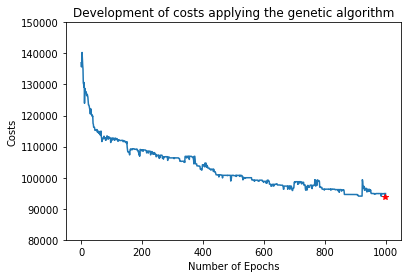

In [27]:
# plot line graph
plt.plot(solution_list)

# get minimum of genetic and set marker
val, idx = min((val, idx) for (idx, val) in enumerate(solution_list))
plt.plot(idx,val,'r*')

# Set limits of y-axis
plt.ylim(bottom=80000,top=150000)

# label axis
plt.xlabel('Number of Epochs')
plt.ylabel('Costs')

# set title
plt.title('Development of costs applying the genetic algorithm')

plt.savefig('pop20_mat8_cross07_mut01_heur10000_gen1000.png', dpi=600)

### 5.1 Vehicle Routing Problem 1 

We ran the heuristic code 200 times, starting with a route of **74880** costs. Then we ran the code for a population size 20, mating pool size 8, mutation probability 0.1 and crossover probability 0.7 20.000 times. The best solution we got was: **69826**

**car types used:**  [500, 500, 500, 100, 100, 100, 100, 300]

**Final route:**  [[0, 80, 34, 90, 65, 92, 5, 30, 11, 85, 75, 33, 68, 12, 73, 3, 4, 59, 29, 44, 99, 51, 93, 77, 25, 0], [0, 91, 13, 98, 17, 83, 21, 45, 48, 71, 96, 79, 63, 23, 74, 16, 24, 35, 40, 43, 81, 54, 31, 95, 53, 94, 9, 58, 55, 0], [0, 41, 28, 88, 49, 50, 60, 42, 97, 72, 8, 86, 61, 89, 84, 47, 57, 6, 18, 70, 82, 32, 56, 22, 67, 0], [0, 20, 52, 14, 37, 0], [0, 26, 27, 46, 69, 78, 0], [0, 64, 36, 66, 2, 62, 0], [0, 19, 87, 38, 100, 39, 0], [0, 1, 10, 15, 7, 76, 0]]

In [27]:
print('The genetic therefore made an improvement of: ',74880 - 69826)

The genetic therefore made an improvement of:  5054


![](save_pop20_mat8_cross07_mut01_heur200_gen20000.png)

### 5.2 Vehicle Routing Problem 2

#### Example 1

We ran the heuristic code 200 times, starting with a route of **106944** costs. Then we ran the code for a population size 20, mating pool size 8, mutation probability 0.1 and crossover probability 0.7 20.000 times. The best solution we got was: **100196**

**car types used:**  [300, 100, 300, 100, 500, 300, 100, 100, 100, 300]

**Final route:**  [[0, 57, 44, 53, 21, 88, 63, 70, 95, 54, 65, 41, 96, 85, 73, 82, 0], [0, 7, 67, 26, 46, 0], [0, 45, 12, 18, 27, 55, 94, 99, 14, 8, 76, 81, 80, 51, 23, 60, 0], [0, 29, 31, 78, 30, 0], [0, 2, 62, 25, 91, 16, 100, 56, 36, 64, 1, 84, 33, 58, 90, 79, 24, 10, 72, 5, 66, 49, 87, 74, 6, 69, 0], [0, 4, 3, 86, 34, 11, 61, 98, 83, 50, 92, 52, 39, 9, 43, 42, 38, 0], [0, 48, 22, 59, 89, 35, 32, 0], [0, 13, 68, 93, 75, 71, 0], [0, 20, 77, 15, 97, 0], [0, 37, 40, 19, 28, 17, 47, 0]]

In [35]:
print('The genetic therefore made an improvement of: ',106944 - 100196)

The genetic therefore made an improvement of:  6748


![](save_vrp2_pop20_mat8_cross07_mut01_heur200_gen20000.png)

#### Example 2

Same parameters but heuristic loop = 10.000 and genetic loop = 1.000

**cost before genetic:** 101664 

**best cost after genetic:** 93712

**car types used:**  [300, 300, 300, 300, 300, 100, 100, 100, 100, 100]

**Final route:**  [[0, 82, 54, 65, 41, 96, 85, 73, 95, 70, 63, 88, 21, 53, 44, 57, 0], [0, 69, 6, 46, 74, 1, 7, 67, 26, 36, 16, 91, 100, 56, 64, 0], [0, 12, 18, 99, 23, 60, 51, 80, 81, 8, 76, 14, 27, 94, 55, 45, 0], [0, 32, 47, 38, 30, 42, 29, 31, 78, 22, 48, 59, 89, 35, 17, 28, 0], [0, 25, 68, 93, 71, 10, 72, 24, 79, 90, 66, 87, 49, 5, 84, 33, 58, 0], [0, 3, 86, 61, 11, 34, 0], [0, 43, 9, 39, 52, 37, 75, 0], [0, 15, 77, 20, 2, 62, 0], [0, 4, 98, 83, 50, 92, 0], [0, 40, 19, 97, 13, 0]]

![](save_vrp2_pop20_mat8_cross07_mut01_heur10000_gen1000.png)